<a href="https://colab.research.google.com/github/terminate9298/Corona-Visualization-and-Prediction/blob/main/COVID%2019%20Visualization%20and%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://colab.research.google.com/drive/1HvnooQjlOgoL4mGvIG7K7ckq3cG5cyY4?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a></center>

In [1]:
#@markdown <h3>⬅️ Click Here to Load Libraries (Important to Run)</h3>
#@markdown <br><center><img src='https://marketplace.magento.com/media/catalog/product/cache/7230773f37a543ef738e324844b23ad1/m/m/mm_magento2_import_firebear_12.png' height="250" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Loading and Intalling Important Libraries</h2></center><br>

MODE = "Use Without Drive" #@param ["MOUNT", "UNMOUNT", "Use Without Drive"]
# Library_To_Import = "All" #@param ["All", "File Upload", "Telegram Uploader", "Youtub Downloader", "Torrent Downloader", "Unzip/UnRar", "Mega Downloader"]
#@markdown <br><h4><i>* Note - Always Run This Cell before Running Any Other Cell</i></h4>
#@markdown <h4><i>* Note - Please Dont Change Anything If you are Not Sure</i></h4>

# Importing Libraries
!pip install wget
# !pip install plotly_express
!pip install --upgrade plotly
# Basic Libraries
import wget
import json , shutil , re , datetime , requests , cv2 , os , warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import time
import math
# Plotting
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import plotly.offline as py
import plotly.express as px
from plotly.subplots import make_subplots
plt.style.use('ggplot')
sns.set_context("paper")
%matplotlib inline

# Modelling
from scipy import integrate
from scipy import optimize

# Map
import folium
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Markdown
from IPython.display import Image
from IPython.display import clear_output

from google.colab import drive
drive.mount._DEBUG = False
clear_output()
display(Markdown("<h1>Colab for Corona Virus Countinuous Updates</h1><br>"))

def refine_address(Address , default = 'Download' , file = False , make_dir = True):
  if file == False:
    if Address == '':
      Address = default
    if Address[0] =='/':
      # If Absolute Path is Provided
      if Address[-1] !='/':
        Address = Address + '/'
      else:
        pass
    # Else if Relative path is provided
    elif os.path.exists('/content/drive/My Drive/'):
      #If Drive is Mounted
      Address = '/content/drive/My Drive/'+Address
      if Address[-1] !='/':
        Address = Address + '/'
      else:
        pass
    else:
      #Else if Drive is Not Mounted
      Address = '/content/'+Address
      if Address[-1] !='/':
        Address = Address + '/'
      else:
        pass
    if make_dir:
      os.makedirs(Address, exist_ok=True)
    else:
      os.makedirs(Address, exist_ok=True)
    return Address
  else:
    if Address[0] =='/':
      return Address
    elif os.path.exists('/content/drive/My Drive/'):
      return '/content/drive/My Drive/'+ Address
    else:
      return '/content/'+Address

# if not os.path.exists('/content/drive/'):
#   drive.mount('/content/drive')

if MODE == "MOUNT":
  if not os.path.exists('/content/drive/'):
    drive.mount('/content/drive', force_remount=True)
  File_Prefix = '/content/drive/MyDrive/COVID/India/'
  display(Markdown("- <h4>Drive Mounted.....</h4><br>"))
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass
  get_ipython().system_raw("rm -rf /root/.config/Google/DriveFS")
  File_Prefix = '/content/'
  display(Markdown("- <h4>Drive Unmounted.....</h4><br>"))
else:
  File_Prefix = '/content/'
  display(Markdown("- <h4>Importing Libraries Done.....</h4><br>"))
File_Prefix = refine_address(File_Prefix)
wget.download('https://api.covid19india.org/csv/latest/states.csv',File_Prefix+'states_.csv')
wget.download('https://api.covid19india.org/csv/latest/districts.csv',File_Prefix+'districts_.csv')
wget.download('https://covid.ourworldindata.org/data/ecdc/full_data.csv',File_Prefix+'Covid_full_data.csv')
wget.download('https://covid.ourworldindata.org/data/owid-covid-data.csv',File_Prefix+'Covid_data.csv')
display(Markdown("- <h4>Files Downloaded Successfully.....</h4><br>"))

states = pd.read_csv(File_Prefix+'states_.csv')
districts = pd.read_csv(File_Prefix+'districts_.csv')
states = pd.concat([pd.DataFrame([['2020-03-01','Kerala',0,0,0,0,0]],columns = states.columns) , states] ,axis = 0)
states.sort_values(by = ['Date'])
states.fillna(0 , inplace = True)
districts.fillna(0 , inplace = True)
states['Active'] = states['Confirmed'] - (states['Recovered'] + states['Deceased'])
states['Month'] = states['Date'].apply(lambda x: x.split('-')[1])
states['Month'] = states['Month'].astype(int)
states = states[states['Month']>2]
date_unique = states.Date.unique()
date_unique = date_unique[:-1]
World_ = pd.read_csv(File_Prefix+'Covid_data.csv')
World_.fillna(0,inplace = True)
World_['date'] = pd.to_datetime(World_['date'] , format = '%Y-%m-%d')
basedate = pd.Timestamp(World_.date.min())
World_['Days_Passed'] = (World_['date'] - basedate)/86400000000000
World_['date'] = World_['date'].astype(str)
World_['Days_Passed'] = World_['Days_Passed'].astype(int)

display(Markdown("- <h4>World Data Processed...</h4><br>"))
world_dates_unique = World_.date.unique()

Completed_ = []
District_ = []
for st in states['State'].unique():
  Arr_ = states[states.State == st].values
  Confirmed_ = 0
  Recovered_ = 0
  Deceased_ = 0
  Other_ = 0 
  Tested_ = 0
  Active_ = 0
  K_ = 0
  dyas = 0
  for i in date_unique:
    if i in Arr_[:,0]:
      Completed_.append([
                         i,
                         st,
                         Arr_[K_,2],#Confirmed
                         Arr_[K_,3],#Recovered
                         Arr_[K_,4],#Deceased
                         Arr_[K_,5],#Other
                         Arr_[K_,6],#Tested
                         Arr_[K_,7],#Active
                         Arr_[K_,2] - Confirmed_,#Confirmed
                         Arr_[K_,3] - Recovered_,#Recovered
                         Arr_[K_,4] - Deceased_,#Deceased
                         Arr_[K_,5] - Other_,#Other
                         Arr_[K_,6] - Tested_,#Tested
                         Arr_[K_,7] - Active_, #Active
                         dyas #Days Passes since
      ])
      Confirmed_ = Arr_[K_,2]
      Recovered_ = Arr_[K_,3]
      Deceased_ = Arr_[K_,4]
      Other_ = Arr_[K_,5]
      Tested_ = Arr_[K_,6]
      Active_ = Arr_[K_,7]
      K_ += 1
      dyas +=1
    else:
      Completed_.append([
                         i,
                         st,
                         Confirmed_,#Confirmed
                         Recovered_,#Recovered
                         Deceased_,#Deceased
                         Other_,#Other
                         Tested_,#Tested
                         Active_,#Active
                         0,#Confirmed
                         0,#Recovered
                         0,#Deceased
                         0,#Other
                         0,#Tested
                         0,#Active
                         dyas
      ])
      dyas += 1
Completed_ = pd.DataFrame(np.array(Completed_) , columns = ['Date', 'State', 'Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_', 'Tested_', 'Active_','Days_Passed'])
for i in ['Confirmed', 'Recovered', 'Deceased', 'Other',
       'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_',
       'Tested_', 'Active_', 'Days_Passed']:
  Completed_[i] = Completed_[i].astype(str).astype(np.float64)
Completed_['Negative'] = Completed_['Tested_'] - Completed_['Confirmed_']
Completed_["Death Rate (per 100)"] = np.round(100*Completed_["Deceased"]/Completed_["Confirmed"],2)
Completed_["Cure Rate (per 100)"] = np.round(100*Completed_["Recovered"]/Completed_["Confirmed"],2)
Completed_.fillna(0,inplace = True)
India_ = Completed_[Completed_.State == 'India']
# Completed_ = Completed_[Completed_.State != 'India']
Completed_['Month'] = Completed_['Date'].apply(lambda x: x.split('-')[1])
Completed_['Month'] = Completed_['Month'].astype(int)
India_['Date'] = pd.to_datetime(India_['Date'] , format = '%Y-%m-%d')
India_['Date'] = India_['Date'].dt.strftime('%m/%d/%Y')
def clear_states(text):
  text = re.sub(r"Uttar Pradesh", "UP", text)
  text = re.sub(r"Tamil Nadu", "TN", text)
  text = re.sub(r"Jammu and Kashmir", "J&K", text)
  text = re.sub(r"Andhra Pradesh", "Andra P", text)
  text = re.sub(r"Himachal Pradesh", "HP", text)
  text = re.sub(r"Madhya Pradesh", "MP", text)
  text = re.sub(r"Andaman and Nicobar Islands", "A&N", text)
  text = re.sub(r"Arunachal Pradesh", "Arun P", text)
  text = re.sub(r"Dadra and Nagar Haveli and Daman and Diu", "D&D", text)
  text = re.sub(r"State Unassigned", "Other", text)
  return text
Completed_['State'] = Completed_['State'].apply(lambda x: clear_states(x))
states_list = Completed_.State.unique()
# India_ = India_.head(India_.shape[0]-1)
India_.reset_index(drop = True , inplace = True)
display(Markdown("- <h4>India State Level Data Processed...</h4><br>"))


districts['Date'] = pd.to_datetime(districts['Date'], format = '%Y-%m-%d')
districts['Days_Passed'] = districts['Date'] - districts['Date'].min()
districts['Days_Passed'] = ((districts['Days_Passed'].values)/86400000000000).astype(int)
districts.sort_values(by = ['District','Date'] ,inplace = True)
districts['Active'] = districts['Confirmed'] - (districts['Recovered']+districts['Deceased'])
District_ = []
for st in districts['District'].unique():
  Arr_ = districts[districts.District == st].values
  Confirmed_ = 0
  Recovered_ = 0
  Deceased_ = 0
  Other_ = 0 
  Tested_ = 0
  Active_ = 0
  for K_ in range(len(Arr_)-1):
    District_.append([
                          Arr_[K_,0],#Date
                          Arr_[K_,1],#State
                          Arr_[K_,2],#District
                          Arr_[K_,3],#Confirmed
                          Arr_[K_,4],#Recovered
                          Arr_[K_,5],#Deceased
                          Arr_[K_,6],#Other
                          Arr_[K_,7],#Tested
                          Arr_[K_,9],#Active
                          Arr_[K_,3] - Confirmed_,#Confirmed
                          Arr_[K_,4] - Recovered_,#Recovered
                          Arr_[K_,5] - Deceased_,#Deceased
                          Arr_[K_,6] - Other_,#Other
                          Arr_[K_,7] - Tested_,#Tested
                          Arr_[K_,9] - Active_, #Active
                          Arr_[K_,8],#Days Passed
        ])
    Confirmed_ = Arr_[K_,3]
    Recovered_ = Arr_[K_,4]
    Deceased_ = Arr_[K_,5]
    Other_ = Arr_[K_,6]
    Tested_ = Arr_[K_,7]
    Active_ = Arr_[K_,9]

District_ = pd.DataFrame(np.array(District_) , columns = ['Date', 'State', 'District', 'Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_', 'Tested_', 'Active_','Days_Passed'])
for i in ['Confirmed', 'Recovered', 'Deceased', 'Other',
       'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_',
       'Tested_', 'Active_', 'Days_Passed']:
  District_[i] = District_[i].astype(str).astype(np.float64)
District_['Negative'] = District_['Tested_'] - District_['Confirmed_']
District_["Death Rate (per 100)"] = np.round(100*District_["Deceased"]/District_["Confirmed"],2)
District_["Cure Rate (per 100)"] = np.round(100*District_["Recovered"]/District_["Confirmed"],2)
District_.fillna(0,inplace = True)
# Completed_ = Completed_[Completed_.State != 'India']
District_['Month'] = District_['Date'].astype(str).apply(lambda x: x.split('-')[1])
District_['Month'] = District_['Month'].astype(int)

display(Markdown("- <h4>India District Level Data Processed...</h4><br>"))

Sup_Title = "Corona Virus"
Style_Color = "rocket"
Plot_Style = "fast" 
SNS_Context = "poster" 
SNS_Style = "ticks" 
Format_To_Save = "jpg"


Graphs_Width = 29 
Graphs_Height = 19 
SNS_Font_Scale = 0.75
Plot_Saturation = 0.86 
Plot_Alpha = 0.85 
SubPlot_Top = 0.92 

plt.style.use(Plot_Style)
sns.set_context(SNS_Context , font_scale = SNS_Font_Scale)
sns.set_style(SNS_Style)
plt.tight_layout()

Style_Palettes = sns.color_palette(Style_Color)
sns.color_palette(Style_Color)
display(Markdown("- <h4>Setting To Default...</h4><br>"))

display(Markdown("- <h4>All Files Preprocessed Successfully.....</h4><br>"))



<h1>Colab for Corona Virus Countinuous Updates</h1><br>

- <h4>Importing Libraries Done.....</h4><br>

- <h4>Files Downloaded Successfully.....</h4><br>

- <h4>World Data Processed...</h4><br>

- <h4>India State Level Data Processed...</h4><br>

- <h4>India District Level Data Processed...</h4><br>

- <h4>Setting To Default...</h4><br>

- <h4>All Files Preprocessed Successfully.....</h4><br>

<Figure size 432x288 with 0 Axes>

In [ ]:
#@markdown <h3>⬅️ Click Here to Change Settings</h3>
#@markdown <br><center><img src='https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.OVRVW9ZaxOE3sHmsX7_bMAHaHa%26pid%3DApi&f=1' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Setting the Configuration</h2></center><br>
Sup_Title = "Corona Virus" #@param {type:"string"}
Style_Color = "rocket" #@param ["tab10" , "deep", "muted", "pastel", "bright", "dark", "colorblind" , "hls" , "husl" , "Set2", "Paired" , "rocket", "mako", "flare", "crest" , "magma" , "viridis" , "rocket_r" , "cubehelix" , "ch:start=.2,rot=-.3" , "ch:s=-.2,r=.6" , "dark:salmon_r" , "Blues" , "YlOrBr" , "vlag" , "icefire" , "Spectral" , "coolwarm"]
Plot_Style = "fast" #@param ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
SNS_Context = "poster" #@param ['notebook','paper','talk','poster']
SNS_Style = "ticks" #@param ['darkgrid', 'whitegrid', 'dark', 'white', 'ticks']
Format_To_Save = "jpg" #@param ["jpg", "png", "jpeg", "eps", "pdf", "svg", "raw", "rgba", "tif", "tiff"]


Graphs_Width = 29 #@param {type:"slider", min:0, max:100, step:1}
Graphs_Height = 19 #@param {type:"slider", min:0, max:100, step:1}
SNS_Font_Scale = 0.75 #@param {type:"slider", min:0, max:3, step:0.05}
Plot_Saturation = 0.86 #@param {type:"slider", min:0, max:1, step:0.01}
Plot_Alpha = 0.85 #@param {type:"slider", min:0, max:1, step:0.01}
SubPlot_Top = 0.92 #@param {type:"slider", min:0, max:1, step:0.01}

plt.style.use(Plot_Style)
sns.set_context(SNS_Context , font_scale = SNS_Font_Scale)
sns.set_style(SNS_Style)
plt.tight_layout()
display(Markdown("<h1>Using The Color Palatte</h1>"))

Style_Palettes = sns.color_palette(Style_Color)
sns.color_palette(Style_Color)

<h1>Using The Color Palatte</h1>

[(0.7643544482681183, 0.8880093482742397, 0.8886224898301243),
 (0.5855957323076926, 0.754577433964653, 0.8084040577328926),
 (0.45077610787066474, 0.5998853667443356, 0.7223838609832016),
 (0.3507228536831824, 0.43905879954313115, 0.6101002657042445),
 (0.25928311223332845, 0.27585597897961833, 0.4514198822688973),
 (0.15399146925967655, 0.128010467998463, 0.24814599518009609)]

<Figure size 432x288 with 0 Axes>

# COVID-19 Cases in World

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://cdn2.iconfinder.com/data/icons/coronavirus-118/82/coronavirus_corona-15-512.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Countries of World</h2></center><br>
Sort_By = "total_cases" #@param ['total_cases','total_cases_per_million', 'new_cases','new_cases_per_million','total_deaths','total_deaths_per_million', 'new_deaths','new_deaths_per_million']
Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "2" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Plot_Top = 15 #@param {type:"slider", min:1, max:30, step:1}

Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
if Date not in World_['date'].unique():
  Date = World_['date'].max()

display(Markdown("<h2> COUNTRY WISE CONFIRMED, DEATH AND CURED CASES of 2019-nCoV AS OF {}</h2>".format(Date)))
temp = World_[World_['location']!='World']
temp[temp['date'] == Date][['location','total_cases','total_cases_per_million', 'new_cases','new_cases_per_million','total_deaths','total_deaths_per_million', 'new_deaths','new_deaths_per_million']]\
                        .sort_values(Sort_By, ascending= False).fillna(0)\
                        .iloc[:Plot_Top].style\
                        .background_gradient(cmap='YlOrBr',subset=["total_cases"])\
                        .background_gradient(cmap='YlOrBr',subset=["total_cases_per_million"])\
                        .background_gradient(cmap='bone_r',subset=["total_deaths"])\
                        .background_gradient(cmap='bone',subset=["total_deaths_per_million"])\
                        .background_gradient(cmap='Greens',subset=["new_cases"])\
                        .background_gradient(cmap='Greens',subset=["new_cases_per_million"])\
                        .background_gradient(cmap='Blues',subset=["new_deaths"])\
                        .background_gradient(cmap='Blues',subset=["new_deaths_per_million"])\

<h2> STATE WISE CONFIRMED, DEATH AND CURED CASES of 2019-nCoV</h2>

,location,total_cases,total_cases_per_million,new_cases,new_cases_per_million,total_deaths,total_deaths_per_million,new_deaths,new_deaths_per_million
56822,United States,13921374.000000,42058.195000,200070.000000,604.436000,273799.000000,827.181000,3157.000000,9.538000
24010,India,9534964.000000,6909.372000,35551.000000,25.762000,138648.000000,100.469000,526.000000,0.381000
7559,Brazil,6436650.000000,30281.652000,49863.000000,234.584000,174515.000000,821.018000,698.000000,3.284000
43878,Russia,2327105.000000,15946.234000,25043.000000,171.604000,40630.000000,278.413000,580.000000,3.974000
18900,France,2275677.000000,34863.713000,248.000000,3.799000,52822.000000,809.241000,1.000000,0.015000
50180,Spain,1665775.000000,35627.906000,9331.000000,199.573000,45784.000000,979.237000,273.000000,5.839000
56506,United Kingdom,1663467.000000,24503.829000,16237.000000,239.180000,59796.000000,880.830000,648.000000,9.545000
26215,Italy,1641610.000000,27151.180000,20709.000000,342.514000,57045.000000,943.488000,684.000000,11.313000
2204,Argentina,1440103.000000,31863.663000,7533.000000,166.675000,39156.000000,866.364000,228.000000,5.045000
11655,Colombia,1334089.000000,26218.817000,9297.000000,182.714000,37117.000000,729.459000,183.000000,3.596000


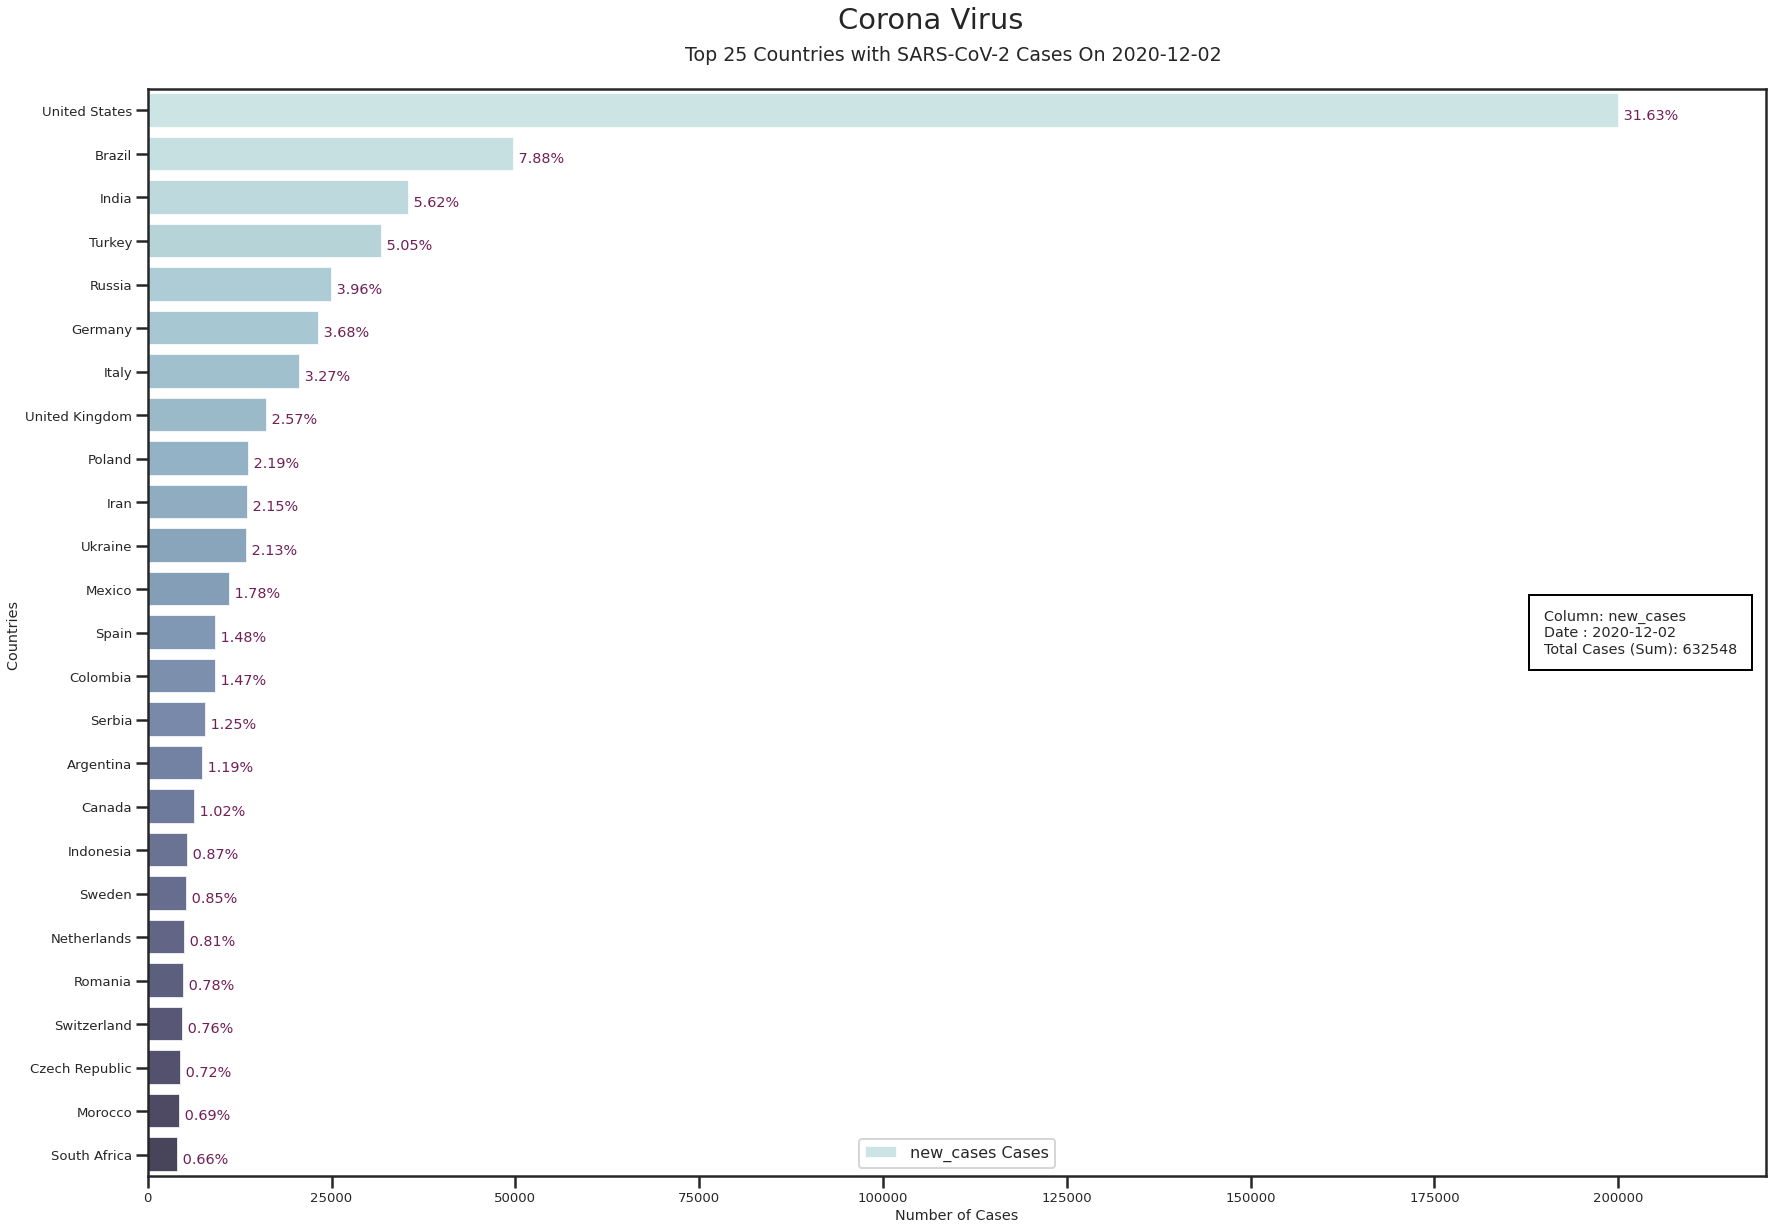

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://cdn0.iconfinder.com/data/icons/coronavirus-88/64/worldwide-global-world-virus-covid-Corona_virus-512.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in World</h2></center><br>
Save_Name = "World War Bar Plot" #@param {type:"string"}
Plot_Column = "new_cases" #@param ['total_cases', 'new_cases','new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions','weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']
Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "2" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Plot_Only = 25 #@param {type:"slider", min:0, max:100, step:1}
Plot_Least = False #@param {type:"boolean"}

Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
if Date not in world_dates_unique:
  display(Markdown('<h3> Invalid Date Encountered.. <br>Setting Date to last Date</h3>'))
  time.sleep(2)
  Date = date_unique[-1]



state_cases = World_[World_.date == Date]
state_cases = state_cases[state_cases['location']!='World']
state_cases=state_cases.sort_values(Plot_Column, ascending= False)
total_cases = state_cases[Plot_Column].sum()
if Plot_Least:
  state_cases=state_cases.tail(int(Plot_Only))
else:
  state_cases=state_cases.head(int(Plot_Only))

plt.figure(figsize=(Graphs_Width,Graphs_Height))
ax = plt.subplot(1,1,1)
plt.suptitle(Sup_Title, fontsize = 29)
plt.title('\nTop {} Countries with SARS-CoV-2 Cases On {} \n'.format(Plot_Only , Date) , fontsize = 19)

graph = sns.barplot(data=state_cases,y='location',x= Plot_Column , saturation = Plot_Saturation , alpha = Plot_Alpha, palette =Style_Color, label = Plot_Column+' Cases' , ci = 'sd' , orient = 'h')
plt.xlim(0,state_cases[Plot_Column].max()+state_cases[Plot_Column].max()/10 )

plt.ylabel('Countries ')
plt.xlabel('Number of Cases')
plt.legend(loc = 8 , fontsize = 16)
anchored_text = AnchoredText("Column: {}\nDate : {}\nTotal Cases (Sum): {}".format(Plot_Column,state_cases.date.unique()[0] ,int(total_cases)), borderpad=1.0, pad = 1.0, loc=7 , frameon= True )
ax.add_artist(anchored_text)
# plt.text(0.95, 0.01, 'colored text in axes coords',
#         verticalalignment='bottom', horizontalalignment='right',
#         color='green', fontsize=15)
for p in graph.patches[:int(Plot_Only)]:
  _x = p.get_x() + p.get_width() 
  _y = p.get_y() + p.get_height()/2 + float(0.2)
  value = ((int(p.get_width())/total_cases)*100)
  if np.isnan(value):
    value = 0.0
  graph.text(_x , _y , ' {:.2f}%'.format(value) , ha = 'left', color = sns.color_palette('rocket')[1])
plt.subplots_adjust(top=SubPlot_Top)

plt.savefig('/content/{} {} {}.{}'.format(Save_Name , Date , time.time() , Format_To_Save) , bbox_inches = 'tight')


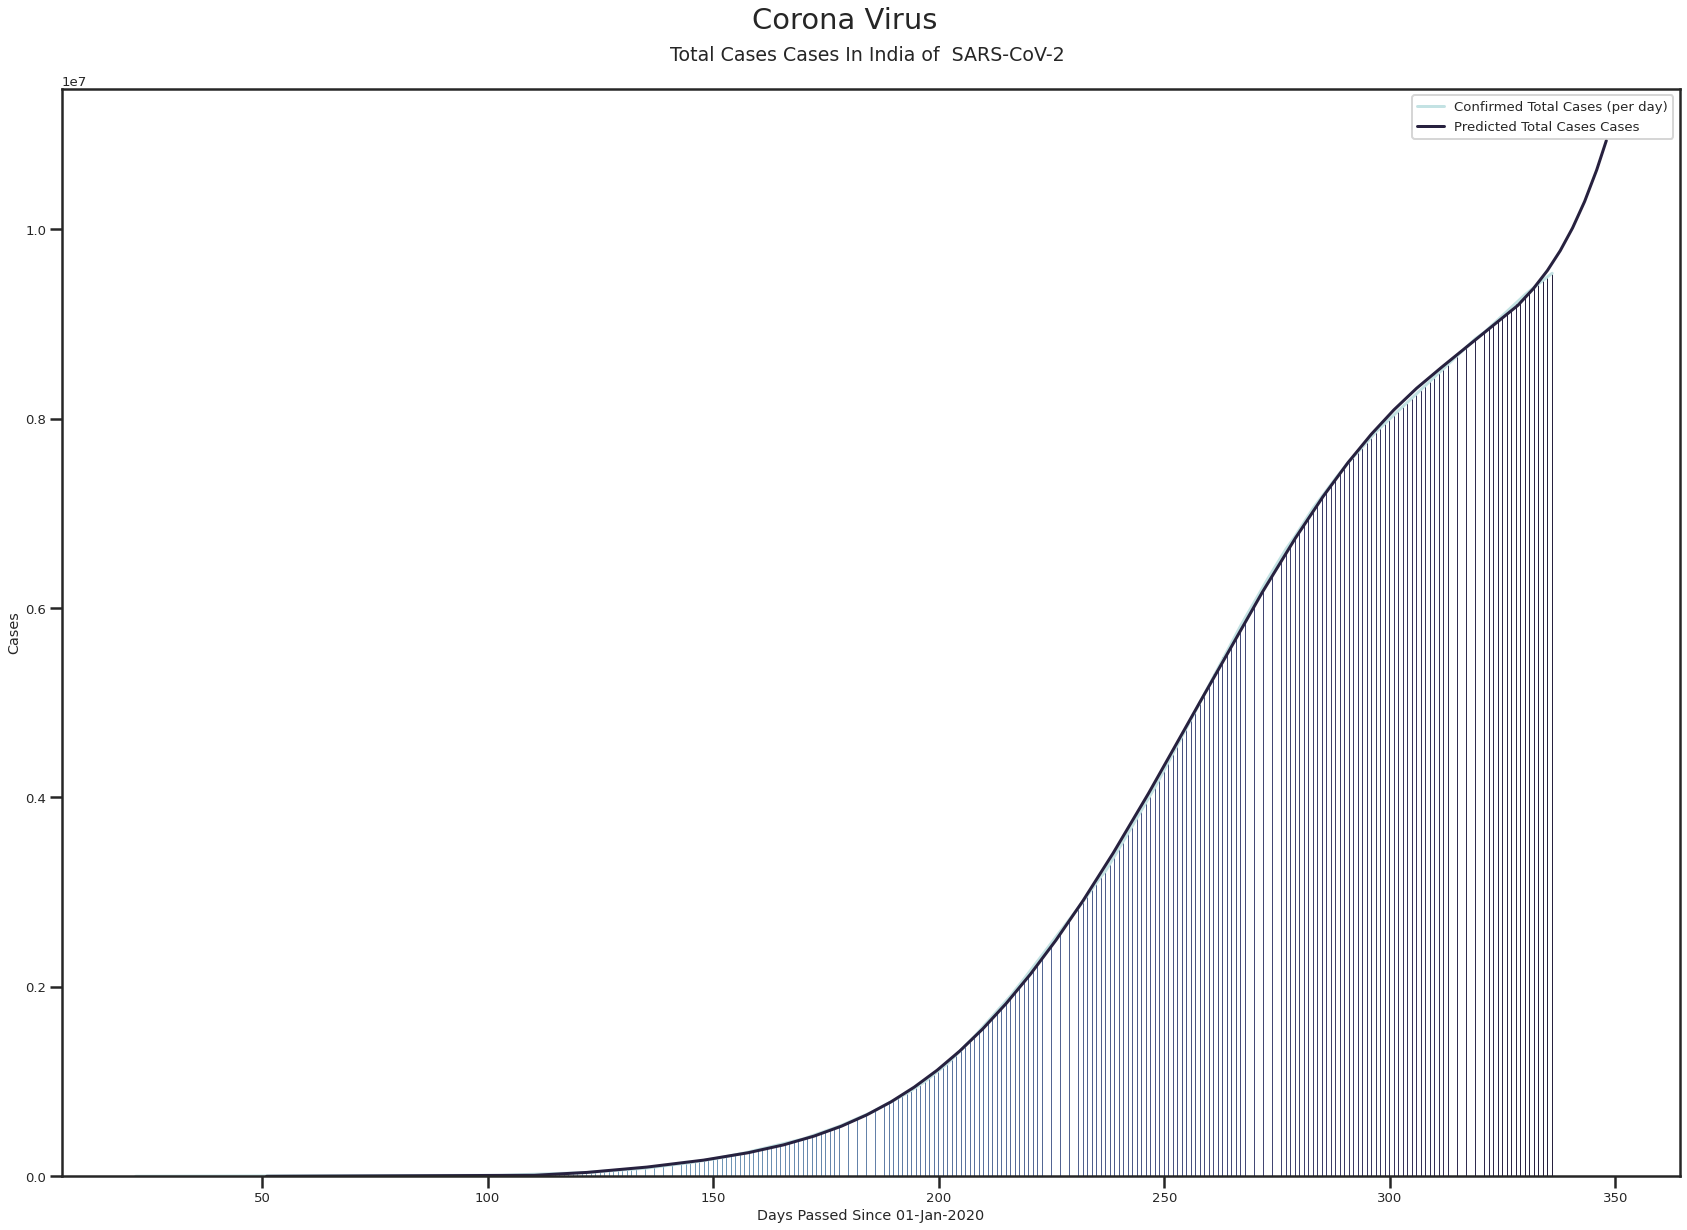

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://cdn3.iconfinder.com/data/icons/presentation-add-on-twotone/48/Paul-07-512.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in World</h2></center><br>
Save_Name = "Country  Plot" #@param {type:"string"}
Plot_Column = "total_cases" #@param ['total_cases', 'new_cases','new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions','weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']
Location = "India" #@param ["Aruba", "Afghanistan", "Angola", "Anguilla", "Albania", "Andorra","United Arab Emirates", "Argentina", "Armenia","Antigua and Barbuda", "Australia", "Austria", "Azerbaijan","Burundi", "Belgium", "Benin", "Bonaire Sint Eustatius and Saba","Burkina Faso", "Bangladesh", "Bulgaria", "Bahrain", "Bahamas","Bosnia and Herzegovina", "Belarus", "Belize", "Bermuda","Bolivia", "Brazil", "Barbados", "Brunei", "Bhutan", "Botswana","Central African Republic", "Canada", "Switzerland", "Chile","China", "Cameroon","Democratic Republic of Congo", "Congo", "Colombia", "Comoros","Cape Verde", "Costa Rica", "Cuba", "Curacao", "Cayman Islands","Cyprus", "Czech Republic", "Germany", "Djibouti", "Dominica","Denmark", "Dominican Republic", "Algeria", "Ecuador", "Egypt","Eritrea", "Western Sahara", "Spain", "Estonia", "Ethiopia","Finland", "Fiji", "Falkland Islands", "France", "Faeroe Islands","Gabon", "United Kingdom", "Georgia", "Guernsey", "Ghana","Gibraltar", "Guinea", "Gambia", "Equatorial Guinea", "Greece", "Grenada", "Greenland", "Guatemala","Guam", "Guyana", "Hong Kong", "Honduras", "Croatia", "Haiti","Hungary", "Indonesia", "Isle of Man", "India", "Ireland", "Iran","Iraq", "Iceland", "Israel", "Italy", "Jamaica", "Jersey","Jordan", "Japan", "Kazakhstan", "Kenya", "Kyrgyzstan", "Cambodia", "Saint Kitts and Nevis", "South Korea", "Kuwait", "Laos","Lebanon", "Liberia", "Libya", "Saint Lucia", "Liechtenstein","Sri Lanka", "Lesotho", "Lithuania", "Luxembourg", "Latvia","Morocco", "Monaco", "Moldova", "Madagascar", "Maldives", "Mexico","Marshall Islands", "Macedonia", "Mali", "Malta", "Myanmar","Montenegro", "Mongolia", "Northern Mariana Islands", "Mozambique","Mauritania", "Montserrat", "Mauritius", "Malawi", "Malaysia","Namibia", "New Caledonia", "Niger", "Nigeria", "Nicaragua","Netherlands", "Norway", "Nepal", "New Zealand", "Oman","Pakistan", "Panama", "Peru", "Philippines", "Papua New Guinea","Poland", "Puerto Rico", "Portugal", "Paraguay", "Palestine","French Polynesia", "Qatar", "Romania", "Russia", "Rwanda","Saudi Arabia", "Sudan", "Senegal", "Singapore", "Solomon Islands","Sierra Leone", "El Salvador", "San Marino", "Somalia", "Serbia","South Sudan", "Sao Tome and Principe", "Suriname", "Slovakia","Slovenia", "Sweden", "Swaziland" ,"Seychelles", "Syria", "Turks and Caicos Islands", "Chad", "Togo","Thailand", "Tajikistan", "Timor", "Trinidad and Tobago","Tunisia", "Turkey", "Taiwan", "Tanzania", "Uganda", "Ukraine","Uruguay", "United States", "Uzbekistan", "Vatican","Saint Vincent and the Grenadines", "Venezuela","British Virgin Islands", "United States Virgin Islands","Vietnam", "Vanuatu", "Wallis and Futuna", "Kosovo", "Yemen","South Africa", "Zambia", "Zimbabwe", "World", "International"]
Regression_Power = 7 #@param {type:"slider", min:0, max:20, step:1}
Train_on_days_from = 51 #@param {type:"slider", min:0, max:300, step:1}
Predict_of_future_days = 12 #@param {type:"slider", min:0, max:200, step:1}
Bar_Plot = True #@param {type:"boolean"}
Line_Plot = True #@param {type:"boolean"}

plot_color = list(sns.color_palette(Style_Color,n_colors=2).as_hex())
plt.figure(figsize=(Graphs_Width,Graphs_Height))
data = World_[World_.location == Location]
if Bar_Plot:
  plt.bar(data['Days_Passed'].values,data[Plot_Column].values, width = 0.2 , linewidth = 0 , color = list(sns.color_palette(Style_Color,n_colors=len(data['Days_Passed'].values)).as_hex()) )
if Line_Plot:
  plt.plot(data['Days_Passed'].values,data[Plot_Column].values, label = 'Confirmed {} (per day)'.format(Plot_Column.replace('_',' ').title()) , color = plot_color[0] )
if Regression_Power:
  model = np.poly1d(np.polyfit(data['Days_Passed'].values[Train_on_days_from:], data[Plot_Column].values[Train_on_days_from:], Regression_Power))
  polyline = np.linspace(Train_on_days_from, World_['Days_Passed'].max()+Predict_of_future_days, 5000) 
  plt.plot(polyline , [0 if i<0 else i for i in model(polyline)]  , label = 'Predicted {} Cases'.format(Plot_Column.replace('_',' ').title()) , color = plot_color[1])

plt.suptitle(Sup_Title, fontsize = 29)
plt.title('{} Cases In {} of  SARS-CoV-2 \n'.format(Plot_Column.replace('_',' ').title() , Location ) , fontsize = 19)
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Days Passed Since 01-Jan-2020')
plt.subplots_adjust(top=SubPlot_Top)

plt.savefig('/content/{} {}.{}'.format(Save_Name , time.time() , Format_To_Save) , bbox_inches = 'tight')



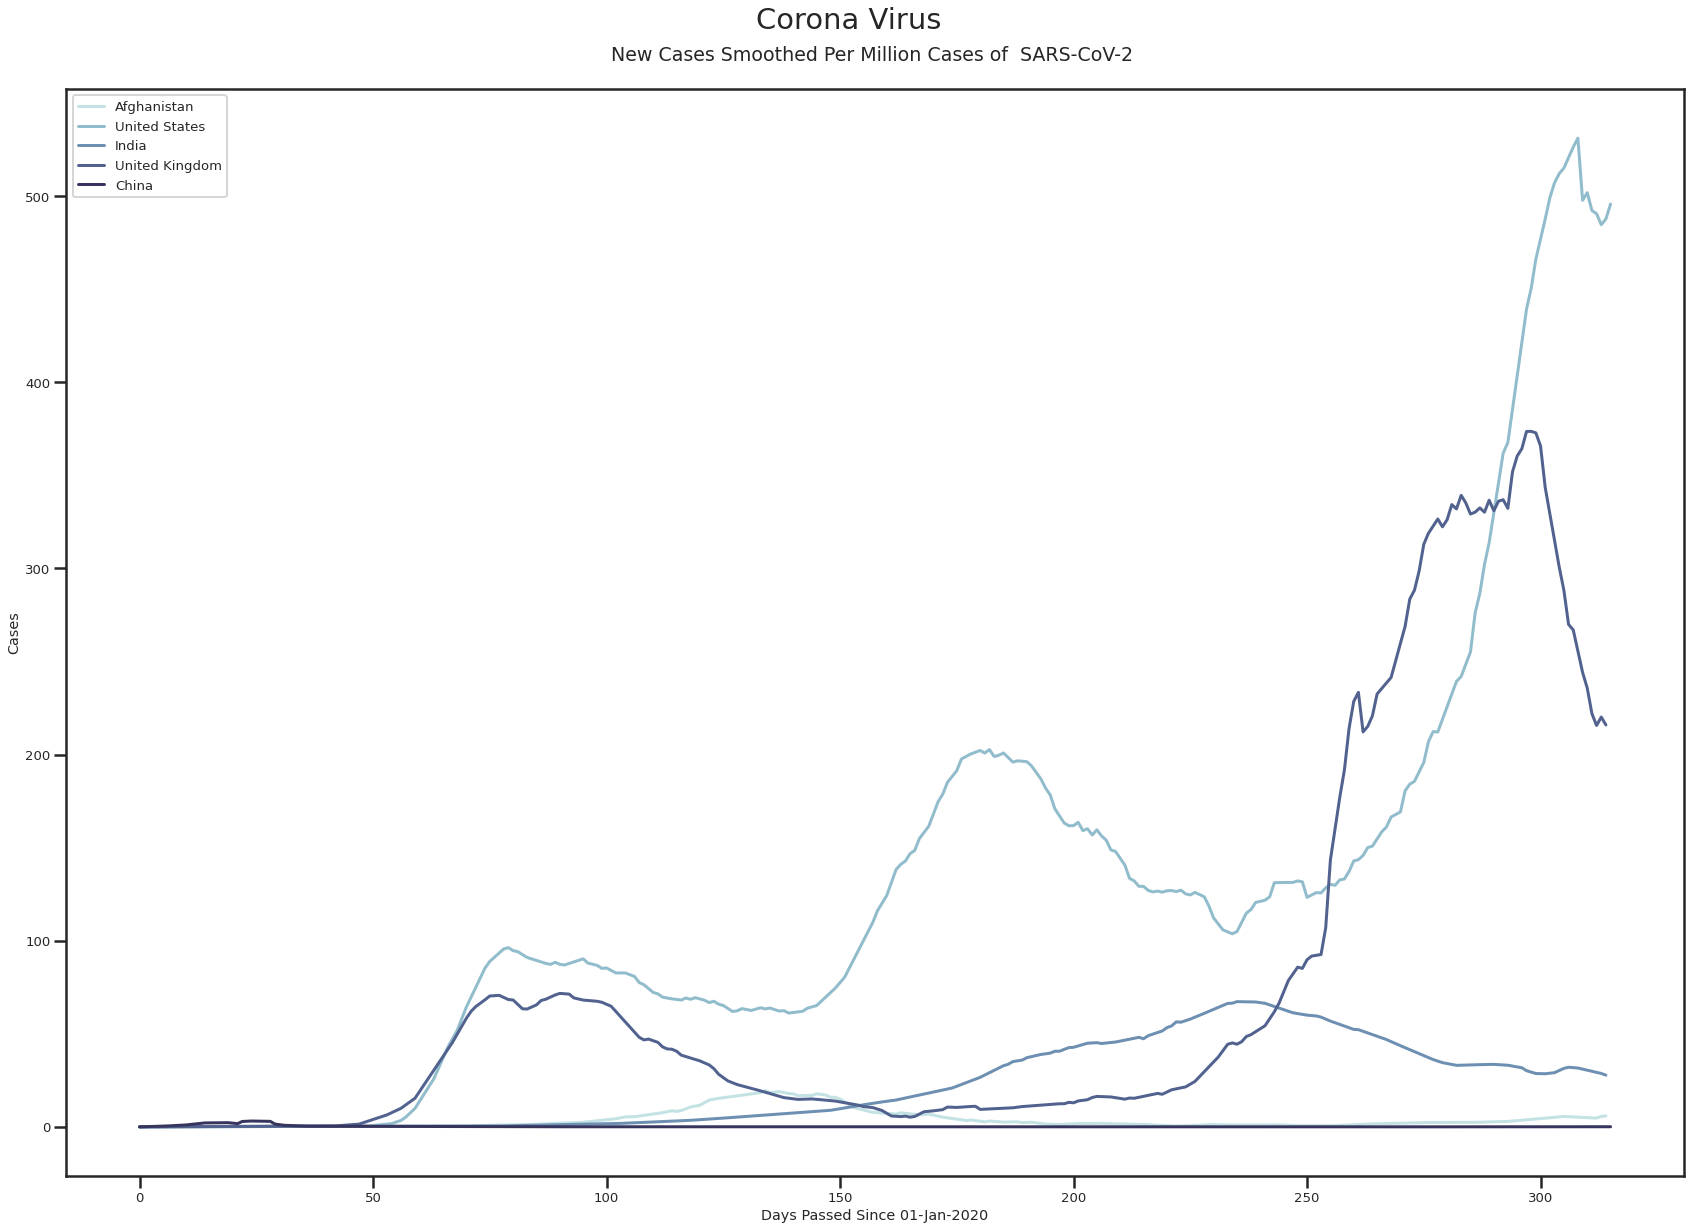

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://cdn2.iconfinder.com/data/icons/e-commerce-4/256/Select_Country-512.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Country</h2></center><br>
Save_Name = "Country  Plot" #@param {type:"string"}
Plot_Column = "new_cases_smoothed_per_million" #@param ['total_cases', 'new_cases','new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions','weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']
Location_1 = "Afghanistan" #@param ["None" ,"Aruba", "Afghanistan", "Angola", "Anguilla", "Albania", "Andorra","United Arab Emirates", "Argentina", "Armenia","Antigua and Barbuda", "Australia", "Austria", "Azerbaijan","Burundi", "Belgium", "Benin", "Bonaire Sint Eustatius and Saba","Burkina Faso", "Bangladesh", "Bulgaria", "Bahrain", "Bahamas","Bosnia and Herzegovina", "Belarus", "Belize", "Bermuda","Bolivia", "Brazil", "Barbados", "Brunei", "Bhutan", "Botswana","Central African Republic", "Canada", "Switzerland", "Chile","China", "Cameroon","Democratic Republic of Congo", "Congo", "Colombia", "Comoros","Cape Verde", "Costa Rica", "Cuba", "Curacao", "Cayman Islands","Cyprus", "Czech Republic", "Germany", "Djibouti", "Dominica","Denmark", "Dominican Republic", "Algeria", "Ecuador", "Egypt","Eritrea", "Western Sahara", "Spain", "Estonia", "Ethiopia","Finland", "Fiji", "Falkland Islands", "France", "Faeroe Islands","Gabon", "United Kingdom", "Georgia", "Guernsey", "Ghana","Gibraltar", "Guinea", "Gambia", "Equatorial Guinea", "Greece", "Grenada", "Greenland", "Guatemala","Guam", "Guyana", "Hong Kong", "Honduras", "Croatia", "Haiti","Hungary", "Indonesia", "Isle of Man", "India", "Ireland", "Iran","Iraq", "Iceland", "Israel", "Italy", "Jamaica", "Jersey","Jordan", "Japan", "Kazakhstan", "Kenya", "Kyrgyzstan", "Cambodia", "Saint Kitts and Nevis", "South Korea", "Kuwait", "Laos","Lebanon", "Liberia", "Libya", "Saint Lucia", "Liechtenstein","Sri Lanka", "Lesotho", "Lithuania", "Luxembourg", "Latvia","Morocco", "Monaco", "Moldova", "Madagascar", "Maldives", "Mexico","Marshall Islands", "Macedonia", "Mali", "Malta", "Myanmar","Montenegro", "Mongolia", "Northern Mariana Islands", "Mozambique","Mauritania", "Montserrat", "Mauritius", "Malawi", "Malaysia","Namibia", "New Caledonia", "Niger", "Nigeria", "Nicaragua","Netherlands", "Norway", "Nepal", "New Zealand", "Oman","Pakistan", "Panama", "Peru", "Philippines", "Papua New Guinea","Poland", "Puerto Rico", "Portugal", "Paraguay", "Palestine","French Polynesia", "Qatar", "Romania", "Russia", "Rwanda","Saudi Arabia", "Sudan", "Senegal", "Singapore", "Solomon Islands","Sierra Leone", "El Salvador", "San Marino", "Somalia", "Serbia","South Sudan", "Sao Tome and Principe", "Suriname", "Slovakia","Slovenia", "Sweden", "Swaziland" ,"Seychelles", "Syria", "Turks and Caicos Islands", "Chad", "Togo","Thailand", "Tajikistan", "Timor", "Trinidad and Tobago","Tunisia", "Turkey", "Taiwan", "Tanzania", "Uganda", "Ukraine","Uruguay", "United States", "Uzbekistan", "Vatican","Saint Vincent and the Grenadines", "Venezuela","British Virgin Islands", "United States Virgin Islands","Vietnam", "Vanuatu", "Wallis and Futuna", "Kosovo", "Yemen","South Africa", "Zambia", "Zimbabwe", "World", "International"]
Location_2 = "United States" #@param ["None" ,"Aruba", "Afghanistan", "Angola", "Anguilla", "Albania", "Andorra","United Arab Emirates", "Argentina", "Armenia","Antigua and Barbuda", "Australia", "Austria", "Azerbaijan","Burundi", "Belgium", "Benin", "Bonaire Sint Eustatius and Saba","Burkina Faso", "Bangladesh", "Bulgaria", "Bahrain", "Bahamas","Bosnia and Herzegovina", "Belarus", "Belize", "Bermuda","Bolivia", "Brazil", "Barbados", "Brunei", "Bhutan", "Botswana","Central African Republic", "Canada", "Switzerland", "Chile","China", "Cameroon","Democratic Republic of Congo", "Congo", "Colombia", "Comoros","Cape Verde", "Costa Rica", "Cuba", "Curacao", "Cayman Islands","Cyprus", "Czech Republic", "Germany", "Djibouti", "Dominica","Denmark", "Dominican Republic", "Algeria", "Ecuador", "Egypt","Eritrea", "Western Sahara", "Spain", "Estonia", "Ethiopia","Finland", "Fiji", "Falkland Islands", "France", "Faeroe Islands","Gabon", "United Kingdom", "Georgia", "Guernsey", "Ghana","Gibraltar", "Guinea", "Gambia", "Equatorial Guinea", "Greece", "Grenada", "Greenland", "Guatemala","Guam", "Guyana", "Hong Kong", "Honduras", "Croatia", "Haiti","Hungary", "Indonesia", "Isle of Man", "India", "Ireland", "Iran","Iraq", "Iceland", "Israel", "Italy", "Jamaica", "Jersey","Jordan", "Japan", "Kazakhstan", "Kenya", "Kyrgyzstan", "Cambodia", "Saint Kitts and Nevis", "South Korea", "Kuwait", "Laos","Lebanon", "Liberia", "Libya", "Saint Lucia", "Liechtenstein","Sri Lanka", "Lesotho", "Lithuania", "Luxembourg", "Latvia","Morocco", "Monaco", "Moldova", "Madagascar", "Maldives", "Mexico","Marshall Islands", "Macedonia", "Mali", "Malta", "Myanmar","Montenegro", "Mongolia", "Northern Mariana Islands", "Mozambique","Mauritania", "Montserrat", "Mauritius", "Malawi", "Malaysia","Namibia", "New Caledonia", "Niger", "Nigeria", "Nicaragua","Netherlands", "Norway", "Nepal", "New Zealand", "Oman","Pakistan", "Panama", "Peru", "Philippines", "Papua New Guinea","Poland", "Puerto Rico", "Portugal", "Paraguay", "Palestine","French Polynesia", "Qatar", "Romania", "Russia", "Rwanda","Saudi Arabia", "Sudan", "Senegal", "Singapore", "Solomon Islands","Sierra Leone", "El Salvador", "San Marino", "Somalia", "Serbia","South Sudan", "Sao Tome and Principe", "Suriname", "Slovakia","Slovenia", "Sweden", "Swaziland" ,"Seychelles", "Syria", "Turks and Caicos Islands", "Chad", "Togo","Thailand", "Tajikistan", "Timor", "Trinidad and Tobago","Tunisia", "Turkey", "Taiwan", "Tanzania", "Uganda", "Ukraine","Uruguay", "United States", "Uzbekistan", "Vatican","Saint Vincent and the Grenadines", "Venezuela","British Virgin Islands", "United States Virgin Islands","Vietnam", "Vanuatu", "Wallis and Futuna", "Kosovo", "Yemen","South Africa", "Zambia", "Zimbabwe", "World", "International"]
Location_3 = "India" #@param ["None" ,"Aruba", "Afghanistan", "Angola", "Anguilla", "Albania", "Andorra","United Arab Emirates", "Argentina", "Armenia","Antigua and Barbuda", "Australia", "Austria", "Azerbaijan","Burundi", "Belgium", "Benin", "Bonaire Sint Eustatius and Saba","Burkina Faso", "Bangladesh", "Bulgaria", "Bahrain", "Bahamas","Bosnia and Herzegovina", "Belarus", "Belize", "Bermuda","Bolivia", "Brazil", "Barbados", "Brunei", "Bhutan", "Botswana","Central African Republic", "Canada", "Switzerland", "Chile","China", "Cameroon","Democratic Republic of Congo", "Congo", "Colombia", "Comoros","Cape Verde", "Costa Rica", "Cuba", "Curacao", "Cayman Islands","Cyprus", "Czech Republic", "Germany", "Djibouti", "Dominica","Denmark", "Dominican Republic", "Algeria", "Ecuador", "Egypt","Eritrea", "Western Sahara", "Spain", "Estonia", "Ethiopia","Finland", "Fiji", "Falkland Islands", "France", "Faeroe Islands","Gabon", "United Kingdom", "Georgia", "Guernsey", "Ghana","Gibraltar", "Guinea", "Gambia", "Equatorial Guinea", "Greece", "Grenada", "Greenland", "Guatemala","Guam", "Guyana", "Hong Kong", "Honduras", "Croatia", "Haiti","Hungary", "Indonesia", "Isle of Man", "India", "Ireland", "Iran","Iraq", "Iceland", "Israel", "Italy", "Jamaica", "Jersey","Jordan", "Japan", "Kazakhstan", "Kenya", "Kyrgyzstan", "Cambodia", "Saint Kitts and Nevis", "South Korea", "Kuwait", "Laos","Lebanon", "Liberia", "Libya", "Saint Lucia", "Liechtenstein","Sri Lanka", "Lesotho", "Lithuania", "Luxembourg", "Latvia","Morocco", "Monaco", "Moldova", "Madagascar", "Maldives", "Mexico","Marshall Islands", "Macedonia", "Mali", "Malta", "Myanmar","Montenegro", "Mongolia", "Northern Mariana Islands", "Mozambique","Mauritania", "Montserrat", "Mauritius", "Malawi", "Malaysia","Namibia", "New Caledonia", "Niger", "Nigeria", "Nicaragua","Netherlands", "Norway", "Nepal", "New Zealand", "Oman","Pakistan", "Panama", "Peru", "Philippines", "Papua New Guinea","Poland", "Puerto Rico", "Portugal", "Paraguay", "Palestine","French Polynesia", "Qatar", "Romania", "Russia", "Rwanda","Saudi Arabia", "Sudan", "Senegal", "Singapore", "Solomon Islands","Sierra Leone", "El Salvador", "San Marino", "Somalia", "Serbia","South Sudan", "Sao Tome and Principe", "Suriname", "Slovakia","Slovenia", "Sweden", "Swaziland" ,"Seychelles", "Syria", "Turks and Caicos Islands", "Chad", "Togo","Thailand", "Tajikistan", "Timor", "Trinidad and Tobago","Tunisia", "Turkey", "Taiwan", "Tanzania", "Uganda", "Ukraine","Uruguay", "United States", "Uzbekistan", "Vatican","Saint Vincent and the Grenadines", "Venezuela","British Virgin Islands", "United States Virgin Islands","Vietnam", "Vanuatu", "Wallis and Futuna", "Kosovo", "Yemen","South Africa", "Zambia", "Zimbabwe", "World", "International"]
Location_4 = "United Kingdom" #@param ["None" ,"Aruba", "Afghanistan", "Angola", "Anguilla", "Albania", "Andorra","United Arab Emirates", "Argentina", "Armenia","Antigua and Barbuda", "Australia", "Austria", "Azerbaijan","Burundi", "Belgium", "Benin", "Bonaire Sint Eustatius and Saba","Burkina Faso", "Bangladesh", "Bulgaria", "Bahrain", "Bahamas","Bosnia and Herzegovina", "Belarus", "Belize", "Bermuda","Bolivia", "Brazil", "Barbados", "Brunei", "Bhutan", "Botswana","Central African Republic", "Canada", "Switzerland", "Chile","China", "Cameroon","Democratic Republic of Congo", "Congo", "Colombia", "Comoros","Cape Verde", "Costa Rica", "Cuba", "Curacao", "Cayman Islands","Cyprus", "Czech Republic", "Germany", "Djibouti", "Dominica","Denmark", "Dominican Republic", "Algeria", "Ecuador", "Egypt","Eritrea", "Western Sahara", "Spain", "Estonia", "Ethiopia","Finland", "Fiji", "Falkland Islands", "France", "Faeroe Islands","Gabon", "United Kingdom", "Georgia", "Guernsey", "Ghana","Gibraltar", "Guinea", "Gambia", "Equatorial Guinea", "Greece", "Grenada", "Greenland", "Guatemala","Guam", "Guyana", "Hong Kong", "Honduras", "Croatia", "Haiti","Hungary", "Indonesia", "Isle of Man", "India", "Ireland", "Iran","Iraq", "Iceland", "Israel", "Italy", "Jamaica", "Jersey","Jordan", "Japan", "Kazakhstan", "Kenya", "Kyrgyzstan", "Cambodia", "Saint Kitts and Nevis", "South Korea", "Kuwait", "Laos","Lebanon", "Liberia", "Libya", "Saint Lucia", "Liechtenstein","Sri Lanka", "Lesotho", "Lithuania", "Luxembourg", "Latvia","Morocco", "Monaco", "Moldova", "Madagascar", "Maldives", "Mexico","Marshall Islands", "Macedonia", "Mali", "Malta", "Myanmar","Montenegro", "Mongolia", "Northern Mariana Islands", "Mozambique","Mauritania", "Montserrat", "Mauritius", "Malawi", "Malaysia","Namibia", "New Caledonia", "Niger", "Nigeria", "Nicaragua","Netherlands", "Norway", "Nepal", "New Zealand", "Oman","Pakistan", "Panama", "Peru", "Philippines", "Papua New Guinea","Poland", "Puerto Rico", "Portugal", "Paraguay", "Palestine","French Polynesia", "Qatar", "Romania", "Russia", "Rwanda","Saudi Arabia", "Sudan", "Senegal", "Singapore", "Solomon Islands","Sierra Leone", "El Salvador", "San Marino", "Somalia", "Serbia","South Sudan", "Sao Tome and Principe", "Suriname", "Slovakia","Slovenia", "Sweden", "Swaziland" ,"Seychelles", "Syria", "Turks and Caicos Islands", "Chad", "Togo","Thailand", "Tajikistan", "Timor", "Trinidad and Tobago","Tunisia", "Turkey", "Taiwan", "Tanzania", "Uganda", "Ukraine","Uruguay", "United States", "Uzbekistan", "Vatican","Saint Vincent and the Grenadines", "Venezuela","British Virgin Islands", "United States Virgin Islands","Vietnam", "Vanuatu", "Wallis and Futuna", "Kosovo", "Yemen","South Africa", "Zambia", "Zimbabwe", "World", "International"]
Location_5 = "China" #@param ["None" ,"Aruba", "Afghanistan", "Angola", "Anguilla", "Albania", "Andorra","United Arab Emirates", "Argentina", "Armenia","Antigua and Barbuda", "Australia", "Austria", "Azerbaijan","Burundi", "Belgium", "Benin", "Bonaire Sint Eustatius and Saba","Burkina Faso", "Bangladesh", "Bulgaria", "Bahrain", "Bahamas","Bosnia and Herzegovina", "Belarus", "Belize", "Bermuda","Bolivia", "Brazil", "Barbados", "Brunei", "Bhutan", "Botswana","Central African Republic", "Canada", "Switzerland", "Chile","China", "Cameroon","Democratic Republic of Congo", "Congo", "Colombia", "Comoros","Cape Verde", "Costa Rica", "Cuba", "Curacao", "Cayman Islands","Cyprus", "Czech Republic", "Germany", "Djibouti", "Dominica","Denmark", "Dominican Republic", "Algeria", "Ecuador", "Egypt","Eritrea", "Western Sahara", "Spain", "Estonia", "Ethiopia","Finland", "Fiji", "Falkland Islands", "France", "Faeroe Islands","Gabon", "United Kingdom", "Georgia", "Guernsey", "Ghana","Gibraltar", "Guinea", "Gambia", "Equatorial Guinea", "Greece", "Grenada", "Greenland", "Guatemala","Guam", "Guyana", "Hong Kong", "Honduras", "Croatia", "Haiti","Hungary", "Indonesia", "Isle of Man", "India", "Ireland", "Iran","Iraq", "Iceland", "Israel", "Italy", "Jamaica", "Jersey","Jordan", "Japan", "Kazakhstan", "Kenya", "Kyrgyzstan", "Cambodia", "Saint Kitts and Nevis", "South Korea", "Kuwait", "Laos","Lebanon", "Liberia", "Libya", "Saint Lucia", "Liechtenstein","Sri Lanka", "Lesotho", "Lithuania", "Luxembourg", "Latvia","Morocco", "Monaco", "Moldova", "Madagascar", "Maldives", "Mexico","Marshall Islands", "Macedonia", "Mali", "Malta", "Myanmar","Montenegro", "Mongolia", "Northern Mariana Islands", "Mozambique","Mauritania", "Montserrat", "Mauritius", "Malawi", "Malaysia","Namibia", "New Caledonia", "Niger", "Nigeria", "Nicaragua","Netherlands", "Norway", "Nepal", "New Zealand", "Oman","Pakistan", "Panama", "Peru", "Philippines", "Papua New Guinea","Poland", "Puerto Rico", "Portugal", "Paraguay", "Palestine","French Polynesia", "Qatar", "Romania", "Russia", "Rwanda","Saudi Arabia", "Sudan", "Senegal", "Singapore", "Solomon Islands","Sierra Leone", "El Salvador", "San Marino", "Somalia", "Serbia","South Sudan", "Sao Tome and Principe", "Suriname", "Slovakia","Slovenia", "Sweden", "Swaziland" ,"Seychelles", "Syria", "Turks and Caicos Islands", "Chad", "Togo","Thailand", "Tajikistan", "Timor", "Trinidad and Tobago","Tunisia", "Turkey", "Taiwan", "Tanzania", "Uganda", "Ukraine","Uruguay", "United States", "Uzbekistan", "Vatican","Saint Vincent and the Grenadines", "Venezuela","British Virgin Islands", "United States Virgin Islands","Vietnam", "Vanuatu", "Wallis and Futuna", "Kosovo", "Yemen","South Africa", "Zambia", "Zimbabwe", "World", "International"]
Locations = [Location_1 ,Location_2 ,Location_3 ,Location_4 ,Location_5]

Regression_Power = 0 #@param {type:"slider", min:0, max:20, step:1}
Train_on_days_from = 0 #@param {type:"slider", min:0, max:300, step:1}
Predict_of_future_days = 4 #@param {type:"slider", min:0, max:200, step:1}
Line_Plot = True #@param {type:"boolean"}

plot_color = list(sns.color_palette(Style_Color,n_colors=len(Locations*2)).as_hex())

plt.figure(figsize=(Graphs_Width,Graphs_Height))
for i,Location in enumerate(Locations):
  if Location in World_.location.unique():
    data = World_[World_.location == Location]
    if Line_Plot:
      plt.plot(data[Plot_Column].values, label = '{}'.format(Location) , color = plot_color[i*2] )
    if Regression_Power:
      model = np.poly1d(np.polyfit(data['Days_Passed'].values[Train_on_days_from:], data[Plot_Column].values[Train_on_days_from:], Regression_Power))
      polyline = np.linspace(Train_on_days_from, World_['Days_Passed'].max()+Predict_of_future_days, 5000) 
      plt.plot(polyline , [0 if i<0 else i for i in model(polyline)] , label = '{} (Fitted)'.format(Location) , color = plot_color[i*2+1])
    
plt.suptitle(Sup_Title, fontsize = 29)
plt.title('{} Cases of  SARS-CoV-2 \n'.format(Plot_Column.replace('_',' ').title() ) , fontsize = 19)
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Days Passed Since 01-Jan-2020')
plt.subplots_adjust(top=SubPlot_Top)
plt.savefig('/content/{} {}.{}'.format(Save_Name , time.time() , Format_To_Save) , bbox_inches = 'tight')


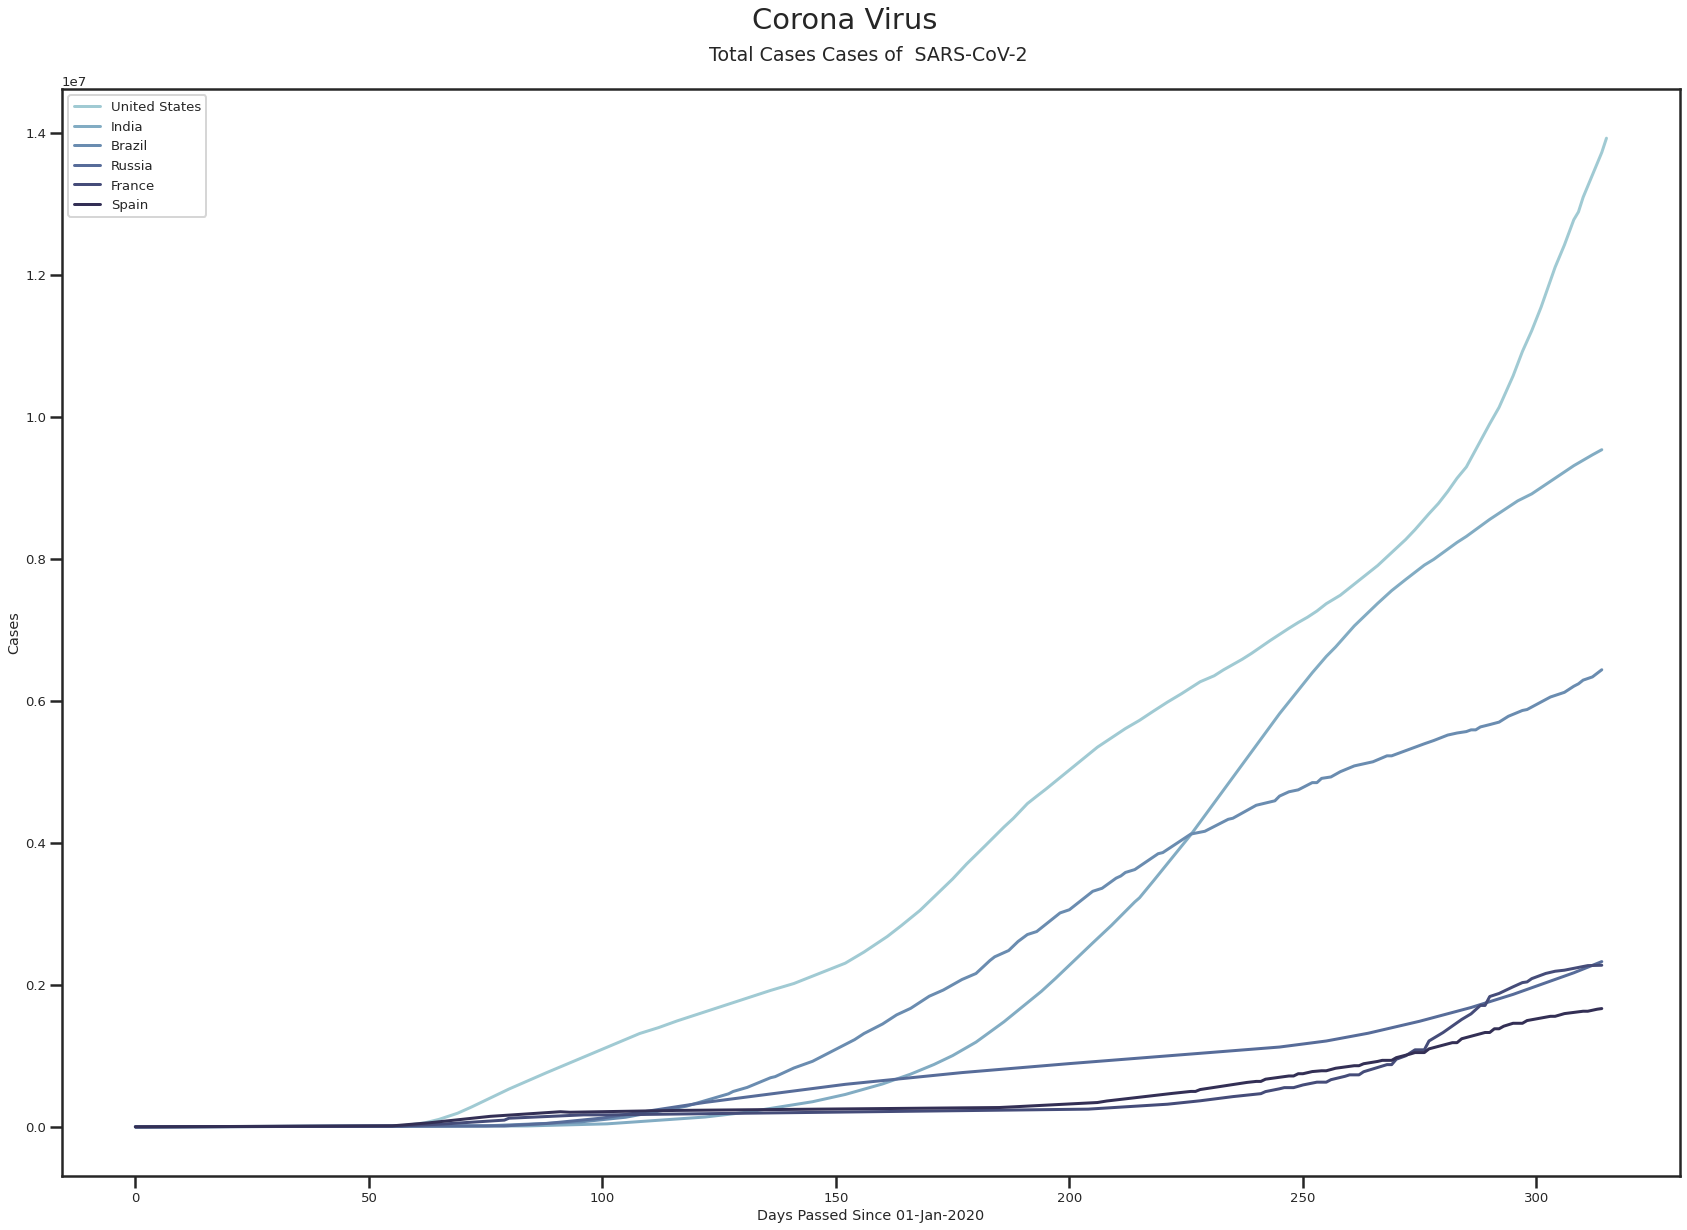

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://assets.website-files.com/5d9ba0eb5f6edb77992a99d0/5e62506c9394b24aa66cf385_iconfinder_connection-route-spread-virus-global_5728179.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Country</h2></center><br>
Save_Name = "Country  Plot" #@param {type:"string"}
Plot_Column = "total_cases" #@param ['total_cases', 'new_cases','new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions','weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']
Use_Method = "sum" #@param ["sum", "mean", "max", "median", "min", "std", "var"]
Plot_top = 6 #@param {type:"slider", min:0, max:100, step:1}
Regression_Power = 0 #@param {type:"slider", min:0, max:20, step:1}
Train_on_days_from = 42 #@param {type:"slider", min:0, max:300, step:1}
Predict_of_future_days = 6 #@param {type:"slider", min:0, max:200, step:1}
Line_Plot = True #@param {type:"boolean"}


Locations = World_.groupby('location').agg({Plot_Column:Use_Method}).sort_values(by=[Plot_Column] , ascending = False).reset_index()['location'].head(Plot_top+1).values

plot_color = list(sns.color_palette(Style_Color,n_colors=len(Locations)*2).as_hex())

plt.figure(figsize=(Graphs_Width,Graphs_Height))
for i,Location in enumerate(Locations):
  if Location in World_.location.unique() and Location != 'World' :
    data = World_[World_.location == Location]
    if Line_Plot:
      plt.plot(data[Plot_Column].values, label = '{}'.format(Location) , color = plot_color[i*2] )
    if Regression_Power:
      model = np.poly1d(np.polyfit(data['Days_Passed'].values[Train_on_days_from:], data[Plot_Column].values[Train_on_days_from:], Regression_Power))
      polyline = np.linspace(Train_on_days_from, World_['Days_Passed'].max()+Predict_of_future_days, 5000) 
      plt.plot(polyline , [0 if i<0 else i for i in model(polyline)]  , label = '{} (Fitted)'.format(Location) , color = plot_color[i*2+1])
    
plt.suptitle(Sup_Title, fontsize = 29)
plt.title('{} Cases of  SARS-CoV-2 \n'.format(Plot_Column.replace('_',' ').title() ) , fontsize = 19)
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Days Passed Since 01-Jan-2020')
plt.subplots_adjust(top=SubPlot_Top)
plt.savefig('/content/{} {}.{}'.format(Save_Name , time.time() , Format_To_Save) , bbox_inches = 'tight')


In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://images.vexels.com/media/users/3/151175/isolated/preview/c8cccfd752a2c029daaa084aca6bb2bc-percent-pie-chart-doodle-by-vexels.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Countries of World (Pie Chart)</h2></center><br>
Plot_By = "new_cases_per_million" #@param ['total_cases','total_cases_per_million', 'new_cases','new_cases_per_million','total_deaths','total_deaths_per_million', 'new_deaths','new_deaths_per_million']
Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "16" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']

Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
if Date not in World_['date'].unique():
  Date = World_['date'].max()
display(Markdown("<h2> COUNTRY WISE PIE CHART CASES of 2019-nCoV AS OF {}</h2>".format(Date)))

temp = World_[World_['location']!= 'World']
fig = px.sunburst(temp[temp['date'] == Date].sort_values(by=Plot_By, ascending=False).reset_index(drop=True), 
                  path=["continent", "location"], values=Plot_By, height=700,
                 title='Number of {} Reported As Of {}'.format(Plot_By.replace('_',' ').title(), Date),
                 color_discrete_sequence = px.colors.qualitative.Prism ,)
fig.data[0].textinfo = 'label+text+value'
fig.show()

<h2> COUNTRY WISE PIE CHART CASES of 2019-nCoV AS OF 2020-12-02</h2>

#COVID - 19 Analysis in India


In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://cdn2.iconfinder.com/data/icons/coronavirus-118/82/coronavirus_corona-15-512.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in States of India</h2></center><br>
Sort_By = "Deceased_" #@param ['Confirmed', 'Recovered', 'Deceased','Active','Confirmed_','Recovered_','Deceased_','Tested','Death Rate (per 100)','Cure Rate (per 100)']
Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "14" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Plot_Top = 20 #@param {type:"slider", min:1, max:30, step:1}

Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
if Date not in Completed_['Date'].unique():
  Date = Completed_['Date'].max()
display(Markdown("<h2> STATE WISE CONFIRMED, DEATH AND CURED CASES of 2019-nCoV AS OF {}</h2>".format(Date)))


temp = Completed_[Completed_['State']!='India']
temp[temp['Date'] == Date][['State','Confirmed', 'Recovered', 'Deceased','Active','Confirmed_','Recovered_','Deceased_','Tested','Death Rate (per 100)','Cure Rate (per 100)']]\
                        .sort_values(Sort_By, ascending= False).fillna(0)\
                        .iloc[:Plot_Top].style\
                        .background_gradient(cmap='YlOrBr',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deceased"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Reds',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Greens',subset=["Cure Rate (per 100)"])\
                        .background_gradient(cmap='crest',subset=["Confirmed_"])\
                        .background_gradient(cmap='PuRd',subset=["Recovered_"])\
                        .background_gradient(cmap='Blues',subset=["Deceased_"])\
                        .background_gradient(cmap='rocket',subset=["Tested"])\

<h2> STATE WISE CONFIRMED, DEATH AND CURED CASES of 2019-nCoV AS OF 2020-12-02</h2>

,State,Confirmed,Recovered,Deceased,Active,Confirmed_,Recovered_,Deceased_,Tested,Death Rate (per 100),Cure Rate (per 100)
3323,Maharashtra,1832176.000000,1695208.000000,47357.000000,89611.000000,3350.000000,3796.000000,111.000000,10989496.000000,2.580000,92.520000
553,Delhi,578324.000000,538680.000000,9342.000000,30302.000000,3944.000000,5329.000000,82.000000,6425470.000000,1.620000,93.150000
5262,West Bengal,490070.000000,457377.000000,8527.000000,24166.000000,3271.000000,3275.000000,51.000000,5958798.000000,1.740000,93.330000
1661,Haryana,237604.000000,218443.000000,2488.000000,16673.000000,1607.000000,2646.000000,32.000000,3633138.000000,1.050000,91.940000
1938,UP,547308.000000,516694.000000,7817.000000,22797.000000,1763.000000,2607.000000,29.000000,19618283.000000,1.430000,94.410000
276,Kerala,614674.000000,550788.000000,2299.000000,61587.000000,6316.000000,5924.000000,28.000000,6378278.000000,0.370000,89.610000
5816,Chhattisgarh,240863.000000,218195.000000,2919.000000,19749.000000,1648.000000,1205.000000,27.000000,2631183.000000,1.210000,90.590000
3600,Punjab,153308.000000,140772.000000,4842.000000,7694.000000,599.000000,518.000000,21.000000,3237858.000000,3.160000,91.820000
1384,Rajasthan,272400.000000,243340.000000,2350.000000,26710.000000,1990.000000,3235.000000,19.000000,4472909.000000,0.860000,89.330000
6370,MP,208924.000000,191618.000000,3287.000000,14019.000000,1439.000000,1838.000000,17.000000,3809683.000000,1.570000,91.720000


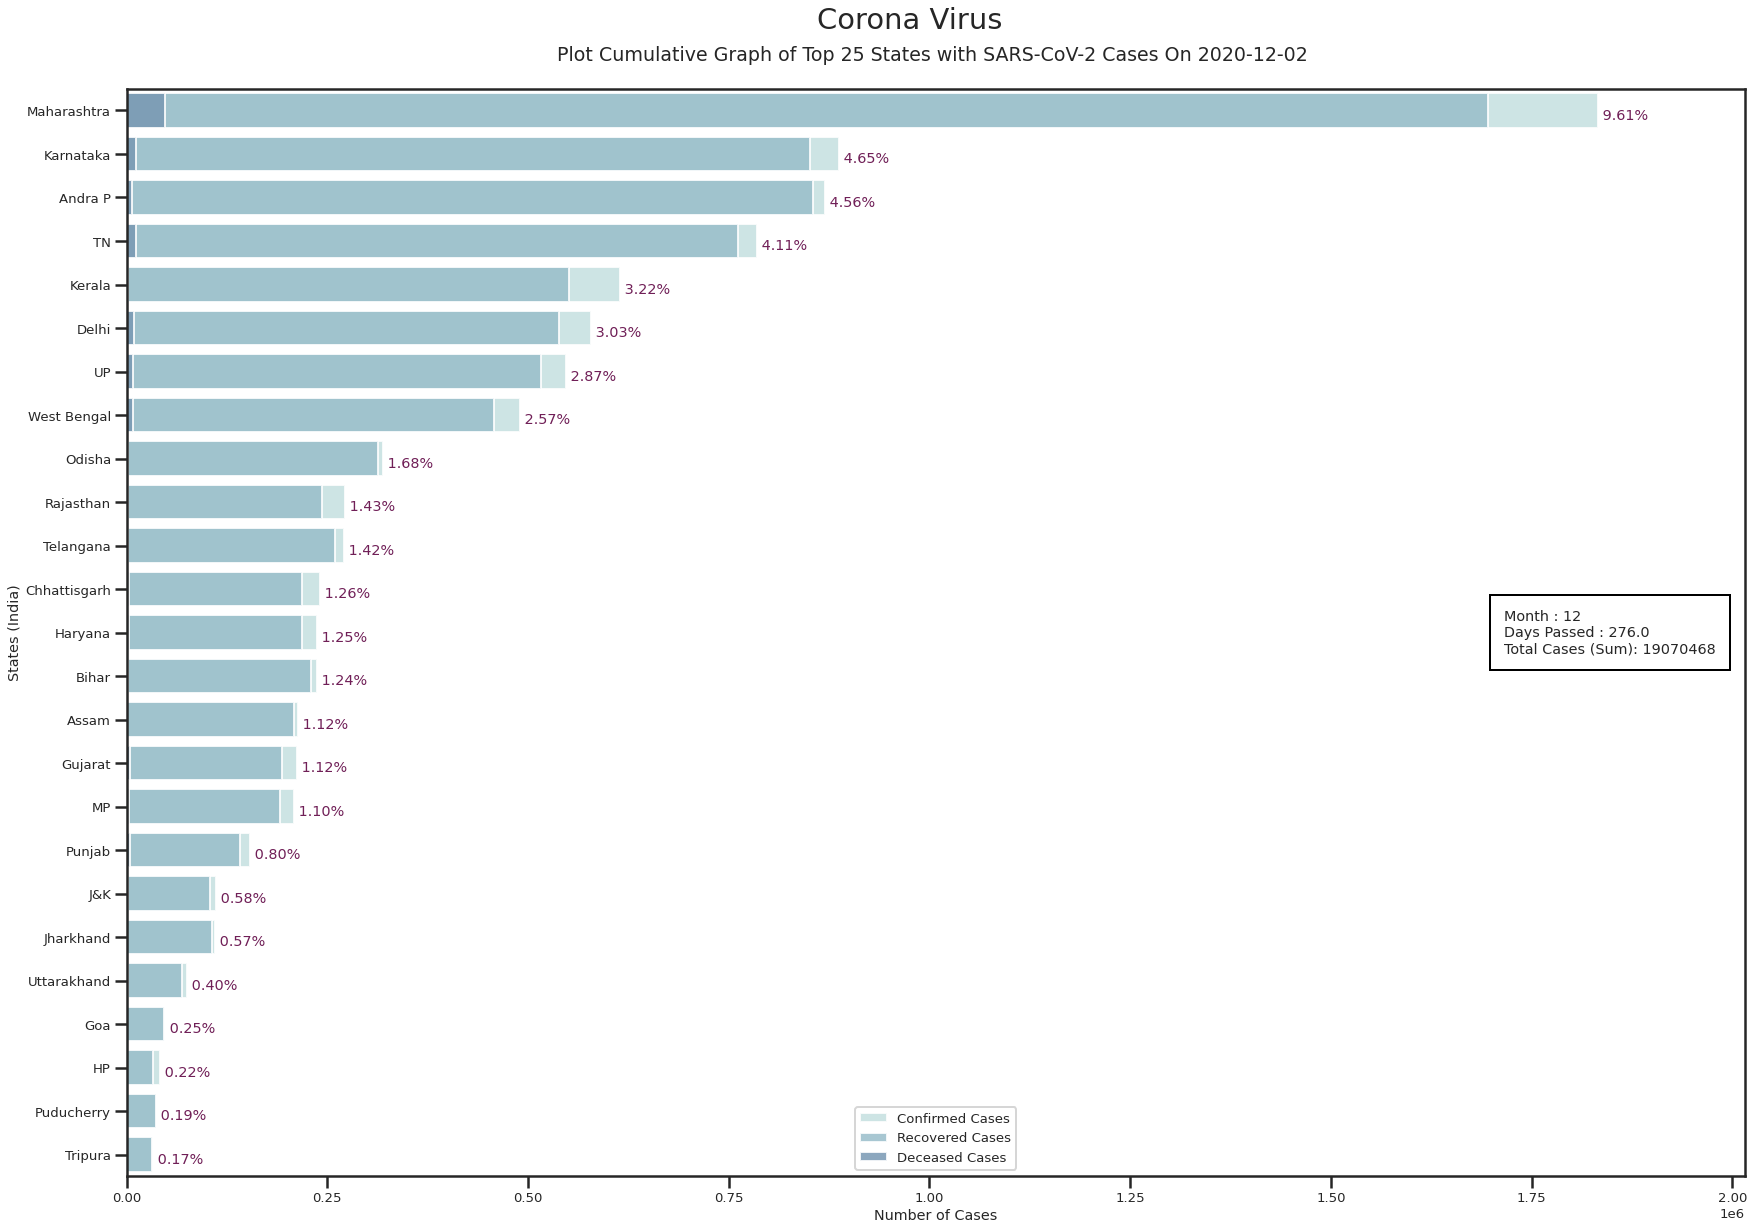

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://media.9curry.com/uploads/state/image/2/Uttar_Pradesh.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in States of India</h2></center><br>
Save_Name = "State War Bar Plot" #@param {type:"string"}
Plot_Status = "Plot Cumulative Graph" #@param ["Plot Cumulative Graph" , "Plot Today's Graph"]
Plot_Only = "Confirmed, Recovered and Deceased Cases" #@param ["Confirmed, Recovered and Deceased Cases", "Confirmed Cases", "Recovered Cases", "Deceased Cases", "Other Cases" , "Tests Cases", "Active Cases"]
Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "2" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Plot_Top = 25 #@param {type:"slider", min:0, max:30, step:1}

Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
if Date not in date_unique:
  display(Markdown('<h3> Invalid Date Encountered.. <br>Setting Date to last Date</h3>'))
  time.sleep(2)
  Date = date_unique[-1]
if Plot_Status == 'Plot Cumulative Graph':
  plot_using = ['Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested', 'Active']
else:
  plot_using = ['Confirmed_', 'Recovered_', 'Deceased_', 'Other_', 'Tested_', 'Active']

state_cases = Completed_[Completed_.Date == Date]
if Plot_Only == "Confirmed, Recovered and Deceased Cases":
  state_cases=state_cases.sort_values(plot_using[0], ascending= False)
  total_cases = state_cases[plot_using[0]].sum()
elif Plot_Only == 'Confirmed Cases':
  state_cases=state_cases.sort_values(plot_using[0], ascending= False)
  total_cases = state_cases[plot_using[0]].sum()
elif Plot_Only == 'Recovered Cases':
  state_cases=state_cases.sort_values(plot_using[1], ascending= False)
  total_cases = state_cases[plot_using[1]].sum()
elif Plot_Only == 'Deceased Cases':
  state_cases=state_cases.sort_values(plot_using[2], ascending= False)
  total_cases = state_cases[plot_using[2]].sum()
elif Plot_Only == 'Other Cases':
  state_cases=state_cases.sort_values(plot_using[3], ascending= False)
  total_cases = state_cases[plot_using[3]].sum()
elif Plot_Only == 'Tests Cases':
  state_cases=state_cases.sort_values(plot_using[4], ascending= False)
  total_cases = state_cases[plot_using[4]].sum()
else:
  state_cases=state_cases.sort_values(plot_using[5], ascending= False)
  total_cases = state_cases[plot_using[5]].sum()

# state_cases=state_cases.sort_values(plot_using[0], ascending= False)
# total_cases = state_cases[plot_using[0]].sum()
state_cases=state_cases[state_cases.State!='India'].head(int(Plot_Top))
plt.figure(figsize=(Graphs_Width,Graphs_Height))
ax = plt.subplot(1,1,1)
plt.suptitle(Sup_Title, fontsize = 29)
plt.title('\n{} of Top {} States with SARS-CoV-2 Cases On {} \n'.format(Plot_Status , Plot_Top , Date) , fontsize = 19)
if Plot_Only == "Confirmed, Recovered and Deceased Cases":
  graph = sns.barplot(data = state_cases , y='State', x = plot_using[0] , saturation = Plot_Saturation, alpha = Plot_Alpha , color =Style_Palettes[0] , label = plot_using[0]+' Cases' , ci = 'sd' , orient = 'h')
  sns.barplot(data=state_cases,y='State',x = plot_using[1] , saturation = Plot_Saturation, alpha = Plot_Alpha, color =Style_Palettes[1], label = plot_using[1]+' Cases' , ci = 'sd' , orient = 'h')
  sns.barplot(data=state_cases,y='State',x= plot_using[2] , saturation = Plot_Saturation , alpha = Plot_Alpha, color =Style_Palettes[2], label = plot_using[2]+' Cases' , ci = 'sd' , orient = 'h')
  plt.xlim(0,state_cases[plot_using[0]].max()+state_cases[plot_using[0]].max()/10 )

elif Plot_Only == 'Confirmed Cases':
  graph = sns.barplot(data = state_cases , y='State', x = plot_using[0] , saturation = Plot_Saturation, alpha = Plot_Alpha , palette =Style_Color , label = plot_using[0]+' Cases' , ci = 'sd' , orient = 'h')
  plt.xlim(0,state_cases[plot_using[0]].max()+state_cases[plot_using[0]].max()/10 )
elif Plot_Only == 'Recovered Cases':
  graph = sns.barplot(data=state_cases,y='State',x = plot_using[1] , saturation = Plot_Saturation, alpha = Plot_Alpha, palette =Style_Color, label = plot_using[1]+' Cases' , ci = 'sd' , orient = 'h')
  plt.xlim(0,state_cases[plot_using[1]].max()+state_cases[plot_using[1]].max()/10 )

elif Plot_Only == 'Deceased Cases':
  graph = sns.barplot(data=state_cases,y='State',x= plot_using[2] , saturation = Plot_Saturation , alpha = Plot_Alpha, palette =Style_Color, label = plot_using[2]+' Cases' , ci = 'sd' , orient = 'h')
  plt.xlim(0,state_cases[plot_using[2]].max()+state_cases[plot_using[2]].max()/10 )

elif Plot_Only == 'Other Cases':
  graph = sns.barplot(data=state_cases,y='State',x= plot_using[3] , saturation = Plot_Saturation , alpha = Plot_Alpha, palette =Style_Color, label = plot_using[3]+' Cases' , ci = 'sd' , orient = 'h')
  plt.xlim(0,state_cases[plot_using[3]].max()+state_cases[plot_using[3]].max()/10 )

elif Plot_Only == 'Tests Cases':
  graph = sns.barplot(data=state_cases,y='State',x= plot_using[4] , saturation = Plot_Saturation , alpha = Plot_Alpha, palette =Style_Color, label = plot_using[4]+' Cases' , ci = 'sd' , orient = 'h')
  plt.xlim(0,state_cases[plot_using[4]].max()+state_cases[plot_using[4]].max()/10 )

else:
  graph = sns.barplot(data=state_cases,y='State',x= plot_using[5] , saturation = Plot_Saturation , alpha = Plot_Alpha, palette =Style_Color, label = plot_using[5]+' Cases' , ci = 'sd' , orient = 'h')
  plt.xlim(0,state_cases[plot_using[5]].max()+state_cases[plot_using[5]].max()/10 )


# plt.xticks(rotation=90)
plt.ylabel('States (India)')
plt.xlabel('Number of Cases')
# plt.xlim(0,Completed_['Confirmed'].max()+Completed_['Confirmed'].max()/10 )
# plt.xlim(0,state_cases[plot_using[0]].max()+state_cases[plot_using[0]].max()/10 )
plt.legend(loc = 8)
anchored_text = AnchoredText("Month : {}\nDays Passed : {}\nTotal Cases (Sum): {}".format(state_cases.Month.unique()[0] ,  state_cases.Days_Passed.unique()[0],int(total_cases)), borderpad=1.0, pad = 1.0, loc=7 , frameon= True )
ax.add_artist(anchored_text)
# plt.text(0.95, 0.01, 'colored text in axes coords',
#         verticalalignment='bottom', horizontalalignment='right',
#         color='green', fontsize=15)
for p in graph.patches[:int(Plot_Top)]:
  _x = p.get_x() + p.get_width() 
  _y = p.get_y() + p.get_height()/2 + float(0.2)
  value = ((int(p.get_width())/total_cases)*100)
  if np.isnan(value):
    value = 0.0
  graph.text(_x , _y , ' {:.2f}%'.format(value) , ha = 'left', color = sns.color_palette('rocket')[1])
plt.subplots_adjust(top=SubPlot_Top)

plt.savefig('/content/{} {} {}.{}'.format(Save_Name , Date , time.time() , Format_To_Save) , bbox_inches = 'tight')

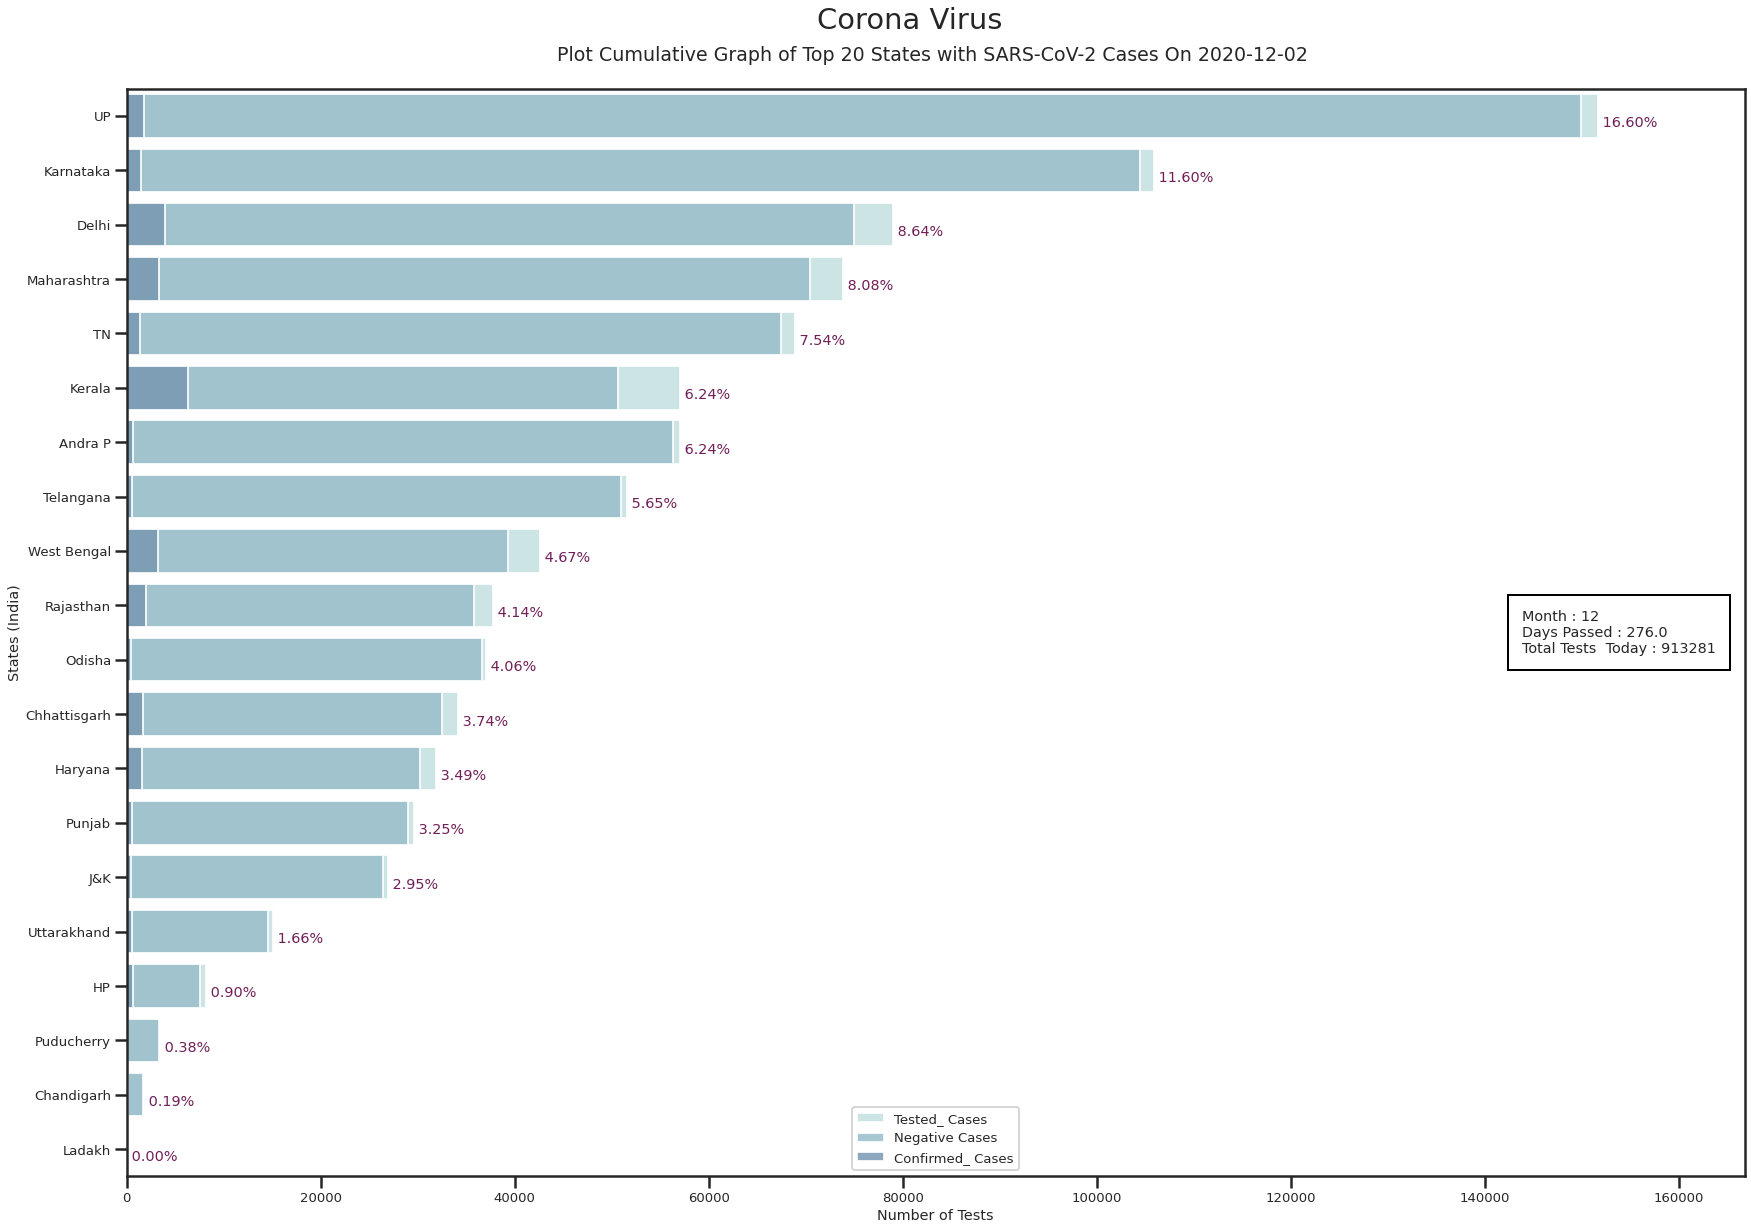

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://cdn4.iconfinder.com/data/icons/coronavirus-1/512/wuhan-coronavirus-virus-outbreak-14-512.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Test of COVID-19 Virus in States of India</h2></center><br>
Save_Name = "State War Bar Plot" #@param {type:"string"}

Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "2" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Plot_Top = 20 #@param {type:"slider", min:0, max:30, step:1}

Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
if Date not in date_unique:
  display(Markdown('<h3> Invalid Date Encountered.. <br>Setting Date to last Date</h3>'))
  time.sleep(2)
  Date = date_unique[-1]

plot_using = ['Tested_', 'Negative' , 'Confirmed_']

state_cases = Completed_[Completed_.Date == Date]
state_cases=state_cases[state_cases.State!='India'].head(int(Plot_Top))

state_cases=state_cases.sort_values('Tested_', ascending= False)
state_cases=state_cases.head(20)
total_cases = state_cases['Tested_'].sum()
plt.figure(figsize=(Graphs_Width,Graphs_Height))
ax = plt.subplot(1,1,1)
plt.suptitle(Sup_Title, fontsize = 29)
plt.title('\n{} of Top {} States with SARS-CoV-2 Cases On {} \n'.format(Plot_Status , Plot_Top , Date) , fontsize = 19)

graph = sns.barplot(data = state_cases , y='State', x = plot_using[0] , saturation = Plot_Saturation, alpha = Plot_Alpha , color =Style_Palettes[0] , label = plot_using[0]+' Cases' , ci = 'sd' , orient = 'h')
sns.barplot(data=state_cases,y='State',x = plot_using[1] , saturation = Plot_Saturation, alpha = Plot_Alpha, color =Style_Palettes[1], label = plot_using[1]+' Cases' , ci = 'sd' , orient = 'h')
sns.barplot(data=state_cases,y='State',x= plot_using[2] , saturation = Plot_Saturation , alpha = Plot_Alpha, color =Style_Palettes[2], label = plot_using[2]+' Cases' , ci = 'sd' , orient = 'h')
plt.xlim(0,state_cases[plot_using[0]].max()+state_cases[plot_using[0]].max()/10 )

plt.ylabel('States (India)')
plt.xlabel('Number of Tests')

plt.legend(loc = 8)
anchored_text = AnchoredText("Month : {}\nDays Passed : {}\nTotal Tests  Today : {}".format(state_cases.Month.unique()[0] ,  state_cases.Days_Passed.unique()[0],int(total_cases)), borderpad=1.0, pad = 1.0, loc=7 , frameon= True )
ax.add_artist(anchored_text)

for p in graph.patches[:20]:
  _x = p.get_x() + p.get_width() 
  _y = p.get_y() + p.get_height()/2 + float(0.2)
  value = ((int(p.get_width())/total_cases)*100)
  if np.isnan(value):
    value = 0.0
  graph.text(_x , _y , ' {:.2f}%'.format(value) , ha = 'left', color = sns.color_palette('rocket')[1])
plt.subplots_adjust(top=SubPlot_Top)

plt.savefig('/content/{} {} {}.{}'.format(Save_Name , Date , time.time() , Format_To_Save) , bbox_inches = 'tight')


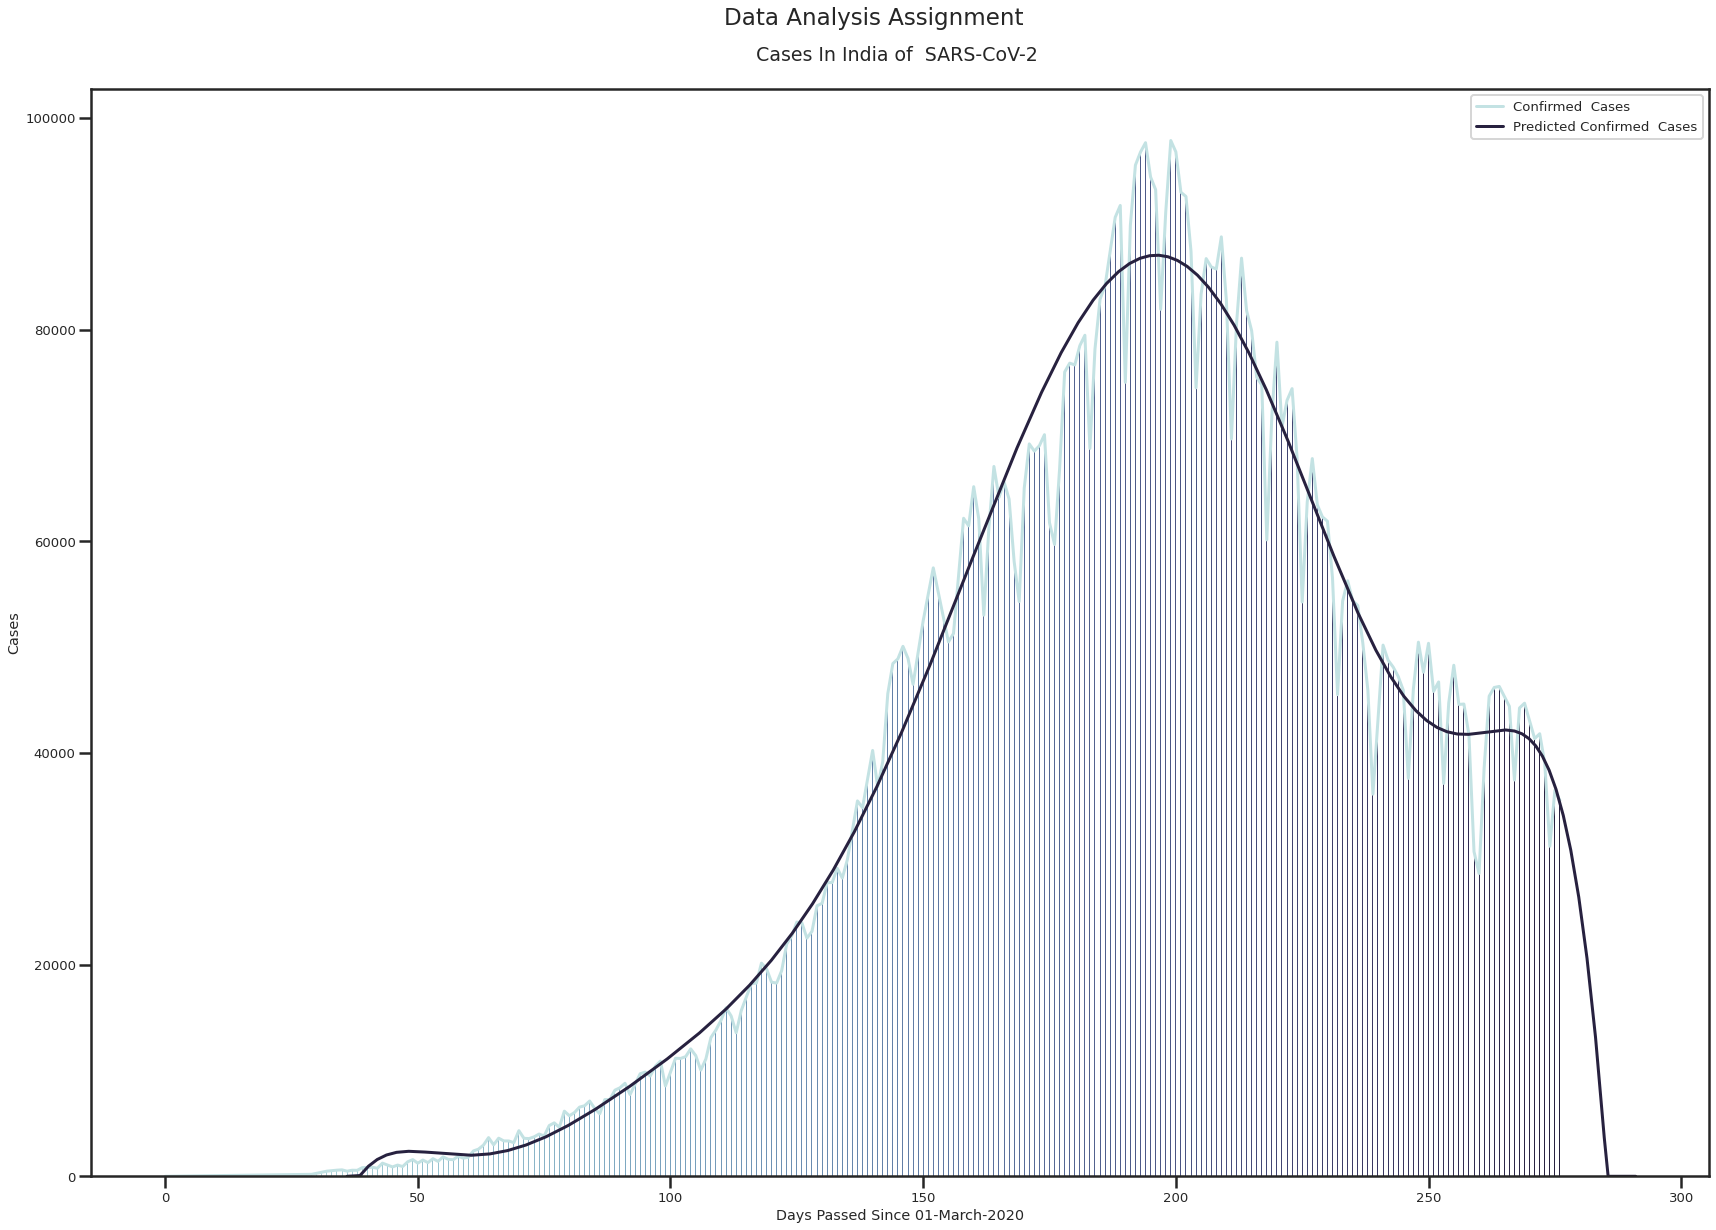

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://cdn.pixabay.com/photo/2013/07/13/12/36/india-159941_960_720.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in India</h2></center><br>
Save_Name = "State Plot" #@param {type:"string"}
Plot_Column = "Confirmed_" #@param ['C/R/D' , 'C/R/D/A', 'C/R/D(Daily)' ,'Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_','Tested_', 'Active_', 'Negative']
Location = "India" #@param ['Kerala', 'Delhi', 'Telangana', 'India', 'Rajasthan', 'Haryana','UP', 'Ladakh', 'TN', 'J&K', 'Karnataka', 'Maharashtra', 'Punjab','Andra P', 'HP', 'Uttarakhand', 'Odisha', 'Puducherry','West Bengal', 'Chandigarh', 'Chhattisgarh', 'Gujarat', 'MP','Bihar', 'Manipur', 'Goa', 'Mizoram', 'A&N', 'Assam', 'Jharkhand','Arun P', 'Nagaland', 'Tripura', 'D&D', 'Meghalaya', 'Sikkim','Other']
Regression_Power = 8 #@param {type:"slider", min:0, max:20, step:1}
Train_on_days_from = 36 #@param {type:"slider", min:0, max:300, step:1}
Predict_of_future_days = 15 #@param {type:"slider", min:0, max:200, step:1}
Bar_Plot = True #@param {type:"boolean"}
Line_Plot = True #@param {type:"boolean"}

if Plot_Column == 'C/R/D':
  Plot_Column = ['Confirmed' , 'Recovered' , 'Deceased']
elif Plot_Column == 'C/R/D/A':
  Plot_Column = ['Confirmed' , 'Recovered' , 'Deceased' , 'Active']
elif Plot_Column == 'C/R/D(Daily)':
  Plot_Column = ['Confirmed_' , 'Recovered_' , 'Deceased_']
else:
  Plot_Column = [Plot_Column]

data = Completed_[Completed_.State == Location]

plot_color = list(sns.color_palette(Style_Color,n_colors=len(Plot_Column)*2).as_hex())
plt.figure(figsize=(Graphs_Width,Graphs_Height))
if Bar_Plot:
  if len(Plot_Column) == 1:
    plt.bar(data['Days_Passed'].values,data[Plot_Column[0]].values, width = 0.2 , linewidth = 0 , color = list(sns.color_palette(Style_Color,n_colors=len(data['Days_Passed'].values)).as_hex()) )
for col,i in enumerate(Plot_Column):
  if Line_Plot:
    plt.plot(data[i].values, label = '{} Cases '.format(i.replace('_',' ').title()) , color = plot_color[col*2] )
  if Regression_Power:
    model = np.poly1d(np.polyfit(data['Days_Passed'].values[Train_on_days_from:], data[i].values[Train_on_days_from:], Regression_Power))
    polyline = np.linspace(Train_on_days_from, data['Days_Passed'].max()+Predict_of_future_days, 5000) 
    plt.plot(polyline , [0 if i<0 else i for i in model(polyline)]  , label = 'Predicted {} Cases'.format(i.replace('_',' ').title()) , color = plot_color[col*2+1])

plt.suptitle('Data Analysis Assignment', fontsize = 23)
plt.title('Cases In {} of  SARS-CoV-2 \n'.format(Location) , fontsize = 19)
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Days Passed Since 01-March-2020')
plt.subplots_adjust(top=SubPlot_Top)

plt.savefig('/content/{} {}.{}'.format(Save_Name , time.time() , Format_To_Save) , bbox_inches = 'tight')



In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://images.vexels.com/media/users/3/151175/isolated/preview/c8cccfd752a2c029daaa084aca6bb2bc-percent-pie-chart-doodle-by-vexels.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Countries of India (Pie Chart)</h2></center><br>
Plot_By = "Tested" #@param ['Confirmed', 'Recovered', 'Deceased','Tested','Active','Confirmed_', 'Recovered_', 'Deceased_','Death Rate (per 100)','Cure Rate (per 100)']
Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "1" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']

Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
if Date not in Completed_['Date'].unique():
  Date = Completed_['Date'].max()
display(Markdown("<h2> COUNTRY WISE PIE CHART CASES of 2019-nCoV AS OF {}</h2>".format(Date )))

temp = Completed_[Completed_['State']!= 'India']
fig = px.sunburst(temp[temp['Date'] == Date].sort_values(by=Plot_By, ascending=False).reset_index(drop=True), 
                  path=["State"], values=Plot_By, height=700,
                 title='Number of {} Reported as of {}'.format(Plot_By.replace('_',' (New) ').title() , Date),
                 color_discrete_sequence = px.colors.qualitative.Prism ,)
fig.data[0].textinfo = 'label+text+value'
fig.show()



<h2> COUNTRY WISE PIE CHART CASES of 2019-nCoV AS OF 2020-12-01</h2>

In [ ]:
Completed_.columns

Index(['Date', 'State', 'Confirmed', 'Recovered', 'Deceased', 'Other',
       'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_',
       'Tested_', 'Active_', 'Days_Passed', 'Negative', 'Death Rate (per 100)',
       'Cure Rate (per 100)', 'Month'],
      dtype='object')

In [ ]:
Use_Method = "mean" #@param ["sum", "mean", "max", "median", "min", "std", "var"]
Plot_Column = "Death Rate (per 100)" #@param ['Confirmed', 'Recovered', 'Deceased', 'Other','Tested', 'Active', 'Death Rate (per 100)','Cure Rate (per 100)']
Month_After_State = False #@param {type:"boolean"}

temp = Completed_.groupby(['Month','State'], as_index = False).agg({ Plot_Column:[Use_Method] })
temp.columns =  [' '.join(col).strip() for col in temp.columns.values]

if Month_After_State:
  Paths = [ "State" , "Month"]
else:
  Paths = [ "Month" , "State"]

fig = px.sunburst(temp[temp['State']!='India'].sort_values(by=Plot_Column + ' ' + Use_Method, ascending=False).reset_index(drop=True), 
                  path=Paths, values=Plot_Column  + ' ' +  Use_Method, height=700,
                 title='Number of {} Reported'.format((Plot_Column  + ' ' + Use_Method).replace('_',' (New) ').title()),
                 color_discrete_sequence = px.colors.qualitative.Prism ,)
fig.data[0].textinfo = 'label+text+value'
fig.show()

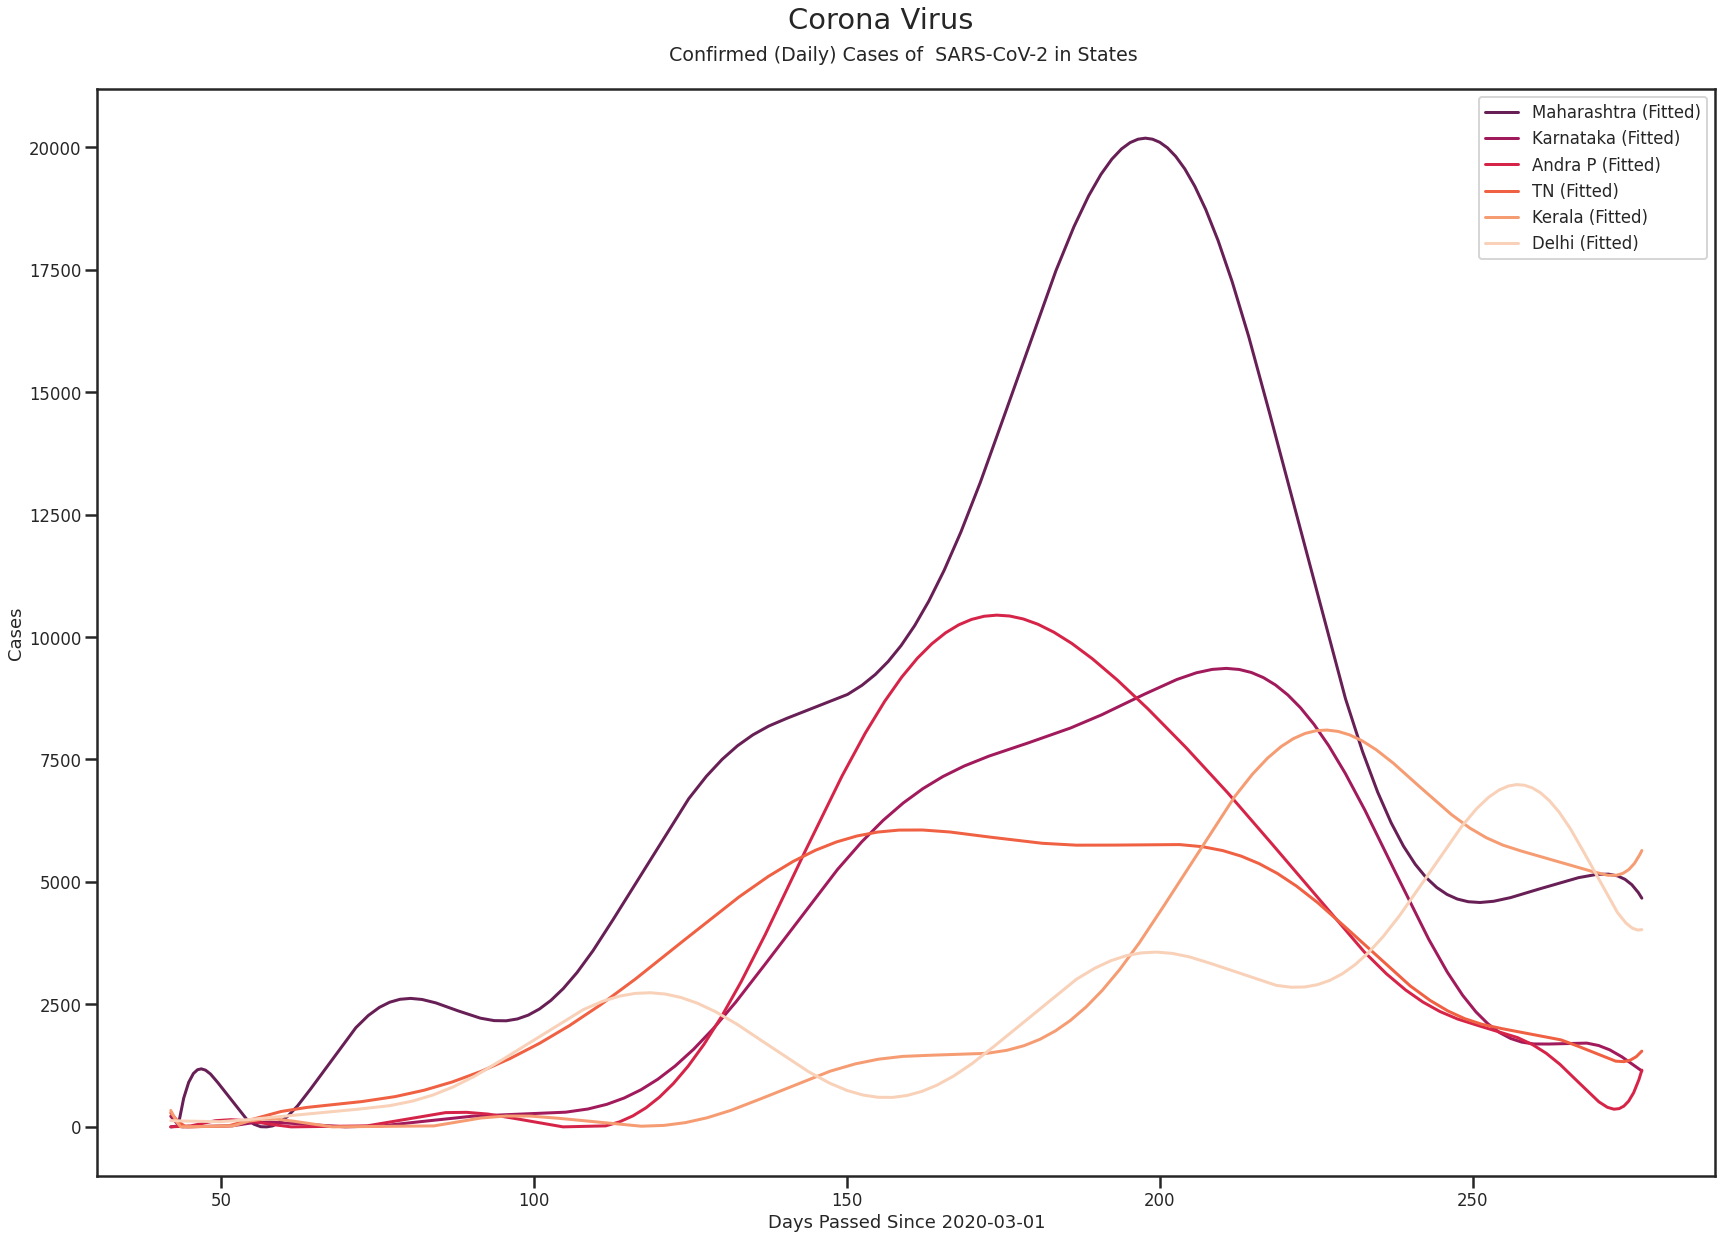

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://assets.website-files.com/5d9ba0eb5f6edb77992a99d0/5e62506c9394b24aa66cf385_iconfinder_connection-route-spread-virus-global_5728179.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Country</h2></center><br>
Save_Name = "State  Plot" #@param {type:"string"}

Plot_By = "Confirmed_" #@param ['Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_','Tested_', 'Active_', 'Negative']
Use_Method = "mean" #@param ["sum", "mean", "max", "median", "min", "std", "var"]
Plot_top = 6 #@param {type:"slider", min:0, max:100, step:1}
Regression_Power = 12 #@param {type:"slider", min:0, max:20, step:1}
Train_on_days_from = 42 #@param {type:"slider", min:0, max:300, step:1}
Predict_of_future_days = 0 #@param {type:"slider", min:0, max:200, step:1}
Line_Plot = False #@param {type:"boolean"}

Locations = Completed_.groupby('State').agg({Plot_By:Use_Method}).sort_values(by=[Plot_By] , ascending = False).reset_index()['State'].head(Plot_top+1).values

plot_color = list(sns.color_palette(Style_Color,n_colors=len(Locations)*2).as_hex())

plt.figure(figsize=(Graphs_Width,Graphs_Height))
for i,Location in enumerate(Locations):
  if Location in Completed_.State.unique() and Location != 'India' :
    data = Completed_[Completed_.State == Location]
    if Line_Plot:
      plt.plot(data[Plot_By].values, label = '{}'.format(Location) , color = plot_color[i*2] )
    if Regression_Power:
      model = np.poly1d(np.polyfit(data['Days_Passed'].values[Train_on_days_from:], data[Plot_By].values[Train_on_days_from:], Regression_Power))
      polyline = np.linspace(Train_on_days_from, Completed_['Days_Passed'].max()+Predict_of_future_days, 5000) 
      plt.plot(polyline , [0 if i<0 else i for i in model(polyline)]  , label = '{} (Fitted)'.format(Location) , color = plot_color[i*2+1])
    
plt.suptitle(Sup_Title, fontsize = 29)
plt.title('{} Cases of  SARS-CoV-2 in States \n'.format(Plot_By.replace('_',' (Daily)').title() ) , fontsize = 19)
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Days Passed Since {}'.format(Completed_['Date'].min()))
plt.subplots_adjust(top=SubPlot_Top)
plt.savefig('/content/{} {}.{}'.format(Save_Name , time.time() , Format_To_Save) , bbox_inches = 'tight')


# COVID-19 Analysis At District Level (India)

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://images.vexels.com/media/users/3/151175/isolated/preview/c8cccfd752a2c029daaa084aca6bb2bc-percent-pie-chart-doodle-by-vexels.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Countries of Districts of India (Pie Chart)</h2></center><br>
Plot_By = "Confirmed" #@param ['Confirmed', 'Recovered', 'Deceased','Tested','Active']
Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "2" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']

Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
display(Markdown("<h2> District WISE PIE CHART CASES of 2019-nCoV</h2>"))
if Date not in District_['Date'].astype(str).unique():
  Date = District_['Date'].max()

temp = District_[District_['District']!= 'Unknown']
fig = px.sunburst(temp[temp['Date'] == Date].sort_values(by=Plot_By, ascending=False).reset_index(drop=True), 
                  path=["State" , "District"], values=Plot_By, height=700,
                 title='Number of {} Reported as {}'.format(Plot_By.replace('_',' (New) ').title() , Date),
                 color_discrete_sequence = px.colors.qualitative.Prism ,)
fig.data[0].textinfo = 'label+text+value'
fig.show()



<h2> District WISE PIE CHART CASES of 2019-nCoV</h2>

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='http://www.pngpix.com/wp-content/uploads/2016/10/PNGPIX-COM-Pie-Chart-PNG-Transparent-Image.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in District on Day (Pie Chart)</h2></center><br>
Plot_District = "Delhi" #@param ['Agar Malwa', 'Agra', 'Ahmedabad', 'Ahmednagar','Airport Quarantine', 'Aizawl', 'Ajmer', 'Akola', 'Alappuzha','Aligarh', 'Alipurduar', 'Alirajpur', 'Almora', 'Alwar', 'Ambala','Ambedkar Nagar', 'Amethi', 'Amravati', 'Amreli', 'Amritsar','Amroha', 'Anand', 'Anantapur', 'Anantnag', 'Angul', 'Anjaw','Anuppur', 'Araria', 'Aravalli', 'Ariyalur', 'Arwal', 'Ashoknagar','Auraiya', 'Aurangabad', 'Ayodhya', 'Azamgarh', 'BSF Camp','Bagalkote', 'Bageshwar', 'Baghpat', 'Bahraich', 'Balaghat','Balangir', 'Balasore', 'Ballari', 'Ballia', 'Balod','Baloda Bazar', 'Balrampur', 'Bametara', 'Banaskantha', 'Banda','Bandipora', 'Banka', 'Bankura', 'Banswara', 'Barabanki','Baramulla', 'Baran', 'Bareilly', 'Bargarh', 'Barmer', 'Barnala','Barwani', 'Bastar', 'Basti', 'Bathinda', 'Beed', 'Begusarai','Belagavi', 'Bengaluru Rural', 'Bengaluru Urban', 'Betul','Bhadohi', 'Bhadrak', 'Bhagalpur', 'Bhandara', 'Bharatpur','Bharuch', 'Bhavnagar', 'Bhilwara', 'Bhind', 'Bhiwani', 'Bhojpur','Bhopal', 'Bidar', 'Bijapur', 'Bijnor', 'Bikaner', 'Bilaspur','Birbhum', 'Bokaro', 'Botad', 'Boudh', 'Budaun', 'Budgam','Bulandshahr', 'Buldhana', 'Bundi', 'Burhanpur', 'Buxar','Capital Complex', 'Chamarajanagara', 'Chamba', 'Chamoli','Champawat', 'Champhai', 'Chandauli', 'Chandigarh', 'Chandrapur','Changlang', 'Charkhi Dadri', 'Chatra', 'Chengalpattu', 'Chennai','Chhatarpur', 'Chhindwara', 'Chhota Udaipur', 'Chikkaballapura','Chikkamagaluru', 'Chitradurga', 'Chitrakoot', 'Chittoor','Chittorgarh', 'Churu', 'Coimbatore', 'Cooch Behar', 'Cuddalore','Cuttack', 'Dadra and Nagar Haveli', 'Dahod','Dakshin Bastar Dantewada', 'Dakshin Dinajpur', 'Dakshina Kannada','Daman', 'Damoh', 'Dang', 'Darbhanga', 'Darjeeling', 'Datia','Dausa', 'Davanagere', 'Dehradun', 'Delhi', 'Deogarh', 'Deoghar','Deoria', 'Devbhumi Dwarka', 'Dewas', 'Dhalai', 'Dhamtari','Dhanbad', 'Dhar', 'Dharmapuri', 'Dharwad', 'Dhenkanal', 'Dholpur','Dhule', 'Dimapur', 'Dindigul', 'Dindori', 'Diu', 'Doda', 'Dumka','Dungarpur', 'Durg', 'East Champaran', 'East Garo Hills','East Godavari', 'East Jaintia Hills', 'East Kameng','East Khasi Hills', 'East Siang', 'East Singhbhum', 'Ernakulam','Erode', 'Etah', 'Etawah', 'Evacuees', 'Faridabad', 'Faridkot','Farrukhabad', 'Fatehabad', 'Fatehgarh Sahib', 'Fatehpur','Fazilka', 'Ferozepur', 'Firozabad', 'Foreign Evacuees', 'Gadag','Gadchiroli', 'Gajapati', 'Ganderbal', 'Gandhinagar', 'Ganganagar','Ganjam', 'Garhwa', 'Gariaband', 'Gaurela Pendra Marwahi','Gautam Buddha Nagar', 'Gaya', 'Ghaziabad', 'Ghazipur','Gir Somnath', 'Giridih', 'Godda', 'Gomati', 'Gonda', 'Gondia','Gopalganj', 'Gorakhpur', 'Gumla', 'Guna', 'Guntur', 'Gurdaspur','Gurugram', 'Gwalior', 'Hamirpur', 'Hanumangarh', 'Hapur', 'Harda','Hardoi', 'Haridwar', 'Hassan', 'Hathras', 'Haveri', 'Hazaribagh','Hingoli', 'Hisar', 'Hnahthial', 'Hooghly', 'Hoshangabad','Hoshiarpur', 'Howrah', 'Idukki', 'Indore', 'Italians', 'Jabalpur','Jagatsinghpur', 'Jaipur', 'Jaisalmer', 'Jajpur', 'Jalandhar','Jalaun', 'Jalgaon', 'Jalna', 'Jalore', 'Jalpaiguri', 'Jammu','Jamnagar', 'Jamtara', 'Jamui', 'Janjgir Champa', 'Jashpur','Jaunpur', 'Jehanabad', 'Jhabua', 'Jhajjar', 'Jhalawar', 'Jhansi','Jhargram', 'Jharsuguda', 'Jhunjhunu', 'Jind', 'Jodhpur','Junagadh', 'Kabeerdham', 'Kaimur', 'Kaithal', 'Kalaburagi','Kalahandi', 'Kalimpong', 'Kallakurichi', 'Kamle', 'Kancheepuram','Kandhamal', 'Kangra', 'Kannauj', 'Kannur', 'Kanpur Dehat','Kanpur Nagar', 'Kanyakumari', 'Kapurthala', 'Karaikal', 'Karauli','Kargil', 'Karnal', 'Karur', 'Kasaragod', 'Kasganj', 'Kathua','Katihar', 'Katni', 'Kaushambi', 'Kendrapara', 'Kendujhar','Khagaria', 'Khandwa', 'Khargone', 'Khawzawl', 'Kheda', 'Khordha','Khowai', 'Khunti', 'Kinnaur', 'Kiphire', 'Kishanganj', 'Kishtwar','Kodagu', 'Koderma', 'Kohima', 'Kolar', 'Kolasib', 'Kolhapur','Kolkata', 'Kollam', 'Kondagaon', 'Koppal', 'Koraput', 'Korba','Koriya', 'Kota', 'Kottayam', 'Kozhikode', 'Kra Daadi', 'Krishna','Krishnagiri', 'Kulgam', 'Kullu', 'Kupwara', 'Kurnool','Kurukshetra', 'Kurung Kumey', 'Kushinagar', 'Kutch','Lahaul and Spiti', 'Lakhimpur Kheri', 'Lakhisarai', 'Lalitpur','Latehar', 'Latur', 'Lawngtlai', 'Leh', 'Lepa Rada', 'Lohardaga','Lohit', 'Longding', 'Longleng', 'Lower Dibang Valley','Lower Siang', 'Lower Subansiri', 'Lucknow', 'Ludhiana', 'Lunglei','Madhepura', 'Madhubani', 'Madurai', 'Maharajganj', 'Mahasamund','Mahe', 'Mahendragarh', 'Mahisagar', 'Mahoba', 'Mainpuri','Malappuram', 'Malda', 'Malkangiri', 'Mamit', 'Mandi', 'Mandla','Mandsaur', 'Mandya', 'Mansa', 'Mathura', 'Mau', 'Mayurbhanj','Meerut', 'Mehsana', 'Mirzapur', 'Moga', 'Mokokchung', 'Mon','Moradabad', 'Morbi', 'Morena', 'Mumbai', 'Mungeli', 'Munger','Murshidabad', 'Muzaffarnagar', 'Muzaffarpur', 'Mysuru','Nabarangapur', 'Nadia', 'Nagapattinam', 'Nagaur', 'Nagpur','Nainital', 'Nalanda', 'Namakkal', 'Namsai', 'Nanded', 'Nandurbar','Narayanpur', 'Narmada', 'Narsinghpur', 'Nashik', 'Navsari','Nawada', 'Nayagarh', 'Neemuch', 'Nilgiris', 'Niwari','North 24 Parganas', 'North Garo Hills', 'North Tripura','Nuapada', 'Nuh', 'Osmanabad', 'Other Region', 'Other State','Others', 'Pakke Kessang', 'Pakur', 'Palakkad', 'Palamu','Palghar', 'Pali', 'Palwal', 'Panchkula', 'Panchmahal', 'Panipat','Panna', 'Papum Pare', 'Parbhani', 'Paschim Bardhaman','Paschim Medinipur', 'Patan', 'Pathanamthitta', 'Pathankot','Patiala', 'Patna', 'Pauri Garhwal', 'Perambalur', 'Peren', 'Phek','Pilibhit', 'Pithoragarh', 'Porbandar', 'Prakasam', 'Pratapgarh','Prayagraj', 'Puducherry', 'Pudukkottai', 'Pulwama', 'Punch','Pune', 'Purba Bardhaman', 'Purba Medinipur', 'Puri', 'Purnia','Purulia', 'Rae Bareli', 'Raichur', 'Raigad', 'Raigarh','Railway Quarantine', 'Raipur', 'Raisen', 'Rajgarh', 'Rajkot','Rajnandgaon', 'Rajouri', 'Rajsamand', 'Ramanagara','Ramanathapuram', 'Ramban', 'Ramgarh', 'Rampur', 'Ranchi','Ranipet', 'Ratlam', 'Ratnagiri', 'Rayagada', 'Reasi', 'Rewa','Rewari', 'Ribhoi', 'Rohtak', 'Rohtas', 'Rudraprayag', 'Rupnagar','S.A.S. Nagar', 'S.P.S. Nellore', 'Sabarkantha', 'Sagar','Saharanpur', 'Saharsa', 'Sahibganj', 'Saiha', 'Saitual', 'Salem','Samastipur', 'Samba', 'Sambalpur', 'Sambhal', 'Sangli', 'Sangrur','Sant Kabir Nagar', 'Saraikela-Kharsawan', 'Saran', 'Satara','Satna', 'Sawai Madhopur', 'Sehore', 'Seoni', 'Serchhip','Shahdol', 'Shahid Bhagat Singh Nagar', 'Shahjahanpur', 'Shajapur','Shamli', 'Sheikhpura', 'Sheohar', 'Sheopur', 'Shi Yomi', 'Shimla','Shivamogga', 'Shivpuri', 'Shopiyan', 'Shrawasti', 'Siang','Siddharthnagar', 'Sidhi', 'Sikar', 'Simdega', 'Sindhudurg','Singrauli', 'Sipahijala', 'Sirmaur', 'Sirohi', 'Sirsa','Sitamarhi', 'Sitapur', 'Sivaganga', 'Siwan', 'Solan', 'Solapur','Sonbhadra', 'Sonipat', 'South 24 Parganas', 'South Garo Hills','South Tripura', 'South West Garo Hills', 'South West Khasi Hills','Sri Muktsar Sahib', 'Srikakulam', 'Srinagar', 'State Pool','Subarnapur', 'Sukma', 'Sultanpur', 'Sundargarh', 'Supaul','Surajpur', 'Surat', 'Surendranagar', 'Surguja', 'Tapi','Tarn Taran', 'Tawang', 'Tehri Garhwal', 'Tenkasi', 'Thane','Thanjavur', 'Theni', 'Thiruvallur', 'Thiruvananthapuram','Thiruvarur', 'Thoothukkudi', 'Thrissur', 'Tikamgarh', 'Tirap','Tiruchirappalli', 'Tirunelveli', 'Tirupathur', 'Tiruppur','Tiruvannamalai', 'Tonk', 'Tuensang', 'Tumakuru', 'Udaipur','Udham Singh Nagar', 'Udhampur', 'Udupi', 'Ujjain', 'Umaria','Una', 'Unknown', 'Unnao', 'Unokoti', 'Upper Dibang Valley','Upper Siang', 'Upper Subansiri', 'Uttar Bastar Kanker','Uttar Dinajpur', 'Uttara Kannada', 'Uttarkashi', 'Vadodara','Vaishali', 'Valsad', 'Varanasi', 'Vellore', 'Vidisha','Vijayapura', 'Viluppuram', 'Virudhunagar', 'Visakhapatnam','Vizianagaram', 'Wardha', 'Washim', 'Wayanad', 'West Champaran','West Garo Hills', 'West Godavari', 'West Jaintia Hills','West Kameng', 'West Khasi Hills', 'West Siang', 'West Singhbhum','West Tripura', 'Wokha', 'Y.S.R. Kadapa', 'Yadgir', 'Yamunanagar','Yanam', 'Yavatmal', 'Zunheboto']
Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "3" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']


Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
# display(Markdown("<h2> District WISE PIE CHART CASES of 2019-nCoV</h2>"))
if Date not in District_['Date'].astype(str).unique():
  Date = District_['Date'].max()

Plot_Pie = True
if Plot_Pie:
  
  temp = District_[District_['District'] == Plot_District]
  temp = temp[temp['Date'] == Date]
  dic_temp = dict(
              total_values = temp[['Confirmed', 'Recovered', 'Deceased']].values[0],
              daily_values = temp[['Confirmed_', 'Recovered_', 'Deceased_']].values[0],
              names = ['Confirmed', 'Recovered', 'Deceased'],
              par = ['Corona Cases','Corona Cases','Corona Cases']
              )
  fig = make_subplots(1, 2, specs=[[{"type": "domain"}, {"type": "domain"}]],)
  fig = px.sunburst(dic_temp, names = 'names',
                   parents = 'par',
                   values='daily_values', height=700,
                 title='Number of {} Cases Reported as {}'.format('New' , Date),
                 color_discrete_sequence = px.colors.qualitative.T10)
  fig.data[0].textinfo = 'label+text+value'
  fig.show()
  fig = px.sunburst(dic_temp, names = 'names',
                   parents = 'par',
                   values='total_values', height=700,
                 title='Number of {} Cases Reported as {}'.format('Total' , Date),
                 color_discrete_sequence = px.colors.qualitative.T10)

  fig.data[0].textinfo = 'label+text+value'
  fig.show()

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='http://icons.iconarchive.com/icons/paomedia/small-n-flat/512/file-excel-icon.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in District (Table View)</h2></center><br>
Plot_District = "Delhi" #@param ['Agar Malwa', 'Agra', 'Ahmedabad', 'Ahmednagar','Airport Quarantine', 'Aizawl', 'Ajmer', 'Akola', 'Alappuzha','Aligarh', 'Alipurduar', 'Alirajpur', 'Almora', 'Alwar', 'Ambala','Ambedkar Nagar', 'Amethi', 'Amravati', 'Amreli', 'Amritsar','Amroha', 'Anand', 'Anantapur', 'Anantnag', 'Angul', 'Anjaw','Anuppur', 'Araria', 'Aravalli', 'Ariyalur', 'Arwal', 'Ashoknagar','Auraiya', 'Aurangabad', 'Ayodhya', 'Azamgarh', 'BSF Camp','Bagalkote', 'Bageshwar', 'Baghpat', 'Bahraich', 'Balaghat','Balangir', 'Balasore', 'Ballari', 'Ballia', 'Balod','Baloda Bazar', 'Balrampur', 'Bametara', 'Banaskantha', 'Banda','Bandipora', 'Banka', 'Bankura', 'Banswara', 'Barabanki','Baramulla', 'Baran', 'Bareilly', 'Bargarh', 'Barmer', 'Barnala','Barwani', 'Bastar', 'Basti', 'Bathinda', 'Beed', 'Begusarai','Belagavi', 'Bengaluru Rural', 'Bengaluru Urban', 'Betul','Bhadohi', 'Bhadrak', 'Bhagalpur', 'Bhandara', 'Bharatpur','Bharuch', 'Bhavnagar', 'Bhilwara', 'Bhind', 'Bhiwani', 'Bhojpur','Bhopal', 'Bidar', 'Bijapur', 'Bijnor', 'Bikaner', 'Bilaspur','Birbhum', 'Bokaro', 'Botad', 'Boudh', 'Budaun', 'Budgam','Bulandshahr', 'Buldhana', 'Bundi', 'Burhanpur', 'Buxar','Capital Complex', 'Chamarajanagara', 'Chamba', 'Chamoli','Champawat', 'Champhai', 'Chandauli', 'Chandigarh', 'Chandrapur','Changlang', 'Charkhi Dadri', 'Chatra', 'Chengalpattu', 'Chennai','Chhatarpur', 'Chhindwara', 'Chhota Udaipur', 'Chikkaballapura','Chikkamagaluru', 'Chitradurga', 'Chitrakoot', 'Chittoor','Chittorgarh', 'Churu', 'Coimbatore', 'Cooch Behar', 'Cuddalore','Cuttack', 'Dadra and Nagar Haveli', 'Dahod','Dakshin Bastar Dantewada', 'Dakshin Dinajpur', 'Dakshina Kannada','Daman', 'Damoh', 'Dang', 'Darbhanga', 'Darjeeling', 'Datia','Dausa', 'Davanagere', 'Dehradun', 'Delhi', 'Deogarh', 'Deoghar','Deoria', 'Devbhumi Dwarka', 'Dewas', 'Dhalai', 'Dhamtari','Dhanbad', 'Dhar', 'Dharmapuri', 'Dharwad', 'Dhenkanal', 'Dholpur','Dhule', 'Dimapur', 'Dindigul', 'Dindori', 'Diu', 'Doda', 'Dumka','Dungarpur', 'Durg', 'East Champaran', 'East Garo Hills','East Godavari', 'East Jaintia Hills', 'East Kameng','East Khasi Hills', 'East Siang', 'East Singhbhum', 'Ernakulam','Erode', 'Etah', 'Etawah', 'Evacuees', 'Faridabad', 'Faridkot','Farrukhabad', 'Fatehabad', 'Fatehgarh Sahib', 'Fatehpur','Fazilka', 'Ferozepur', 'Firozabad', 'Foreign Evacuees', 'Gadag','Gadchiroli', 'Gajapati', 'Ganderbal', 'Gandhinagar', 'Ganganagar','Ganjam', 'Garhwa', 'Gariaband', 'Gaurela Pendra Marwahi','Gautam Buddha Nagar', 'Gaya', 'Ghaziabad', 'Ghazipur','Gir Somnath', 'Giridih', 'Godda', 'Gomati', 'Gonda', 'Gondia','Gopalganj', 'Gorakhpur', 'Gumla', 'Guna', 'Guntur', 'Gurdaspur','Gurugram', 'Gwalior', 'Hamirpur', 'Hanumangarh', 'Hapur', 'Harda','Hardoi', 'Haridwar', 'Hassan', 'Hathras', 'Haveri', 'Hazaribagh','Hingoli', 'Hisar', 'Hnahthial', 'Hooghly', 'Hoshangabad','Hoshiarpur', 'Howrah', 'Idukki', 'Indore', 'Italians', 'Jabalpur','Jagatsinghpur', 'Jaipur', 'Jaisalmer', 'Jajpur', 'Jalandhar','Jalaun', 'Jalgaon', 'Jalna', 'Jalore', 'Jalpaiguri', 'Jammu','Jamnagar', 'Jamtara', 'Jamui', 'Janjgir Champa', 'Jashpur','Jaunpur', 'Jehanabad', 'Jhabua', 'Jhajjar', 'Jhalawar', 'Jhansi','Jhargram', 'Jharsuguda', 'Jhunjhunu', 'Jind', 'Jodhpur','Junagadh', 'Kabeerdham', 'Kaimur', 'Kaithal', 'Kalaburagi','Kalahandi', 'Kalimpong', 'Kallakurichi', 'Kamle', 'Kancheepuram','Kandhamal', 'Kangra', 'Kannauj', 'Kannur', 'Kanpur Dehat','Kanpur Nagar', 'Kanyakumari', 'Kapurthala', 'Karaikal', 'Karauli','Kargil', 'Karnal', 'Karur', 'Kasaragod', 'Kasganj', 'Kathua','Katihar', 'Katni', 'Kaushambi', 'Kendrapara', 'Kendujhar','Khagaria', 'Khandwa', 'Khargone', 'Khawzawl', 'Kheda', 'Khordha','Khowai', 'Khunti', 'Kinnaur', 'Kiphire', 'Kishanganj', 'Kishtwar','Kodagu', 'Koderma', 'Kohima', 'Kolar', 'Kolasib', 'Kolhapur','Kolkata', 'Kollam', 'Kondagaon', 'Koppal', 'Koraput', 'Korba','Koriya', 'Kota', 'Kottayam', 'Kozhikode', 'Kra Daadi', 'Krishna','Krishnagiri', 'Kulgam', 'Kullu', 'Kupwara', 'Kurnool','Kurukshetra', 'Kurung Kumey', 'Kushinagar', 'Kutch','Lahaul and Spiti', 'Lakhimpur Kheri', 'Lakhisarai', 'Lalitpur','Latehar', 'Latur', 'Lawngtlai', 'Leh', 'Lepa Rada', 'Lohardaga','Lohit', 'Longding', 'Longleng', 'Lower Dibang Valley','Lower Siang', 'Lower Subansiri', 'Lucknow', 'Ludhiana', 'Lunglei','Madhepura', 'Madhubani', 'Madurai', 'Maharajganj', 'Mahasamund','Mahe', 'Mahendragarh', 'Mahisagar', 'Mahoba', 'Mainpuri','Malappuram', 'Malda', 'Malkangiri', 'Mamit', 'Mandi', 'Mandla','Mandsaur', 'Mandya', 'Mansa', 'Mathura', 'Mau', 'Mayurbhanj','Meerut', 'Mehsana', 'Mirzapur', 'Moga', 'Mokokchung', 'Mon','Moradabad', 'Morbi', 'Morena', 'Mumbai', 'Mungeli', 'Munger','Murshidabad', 'Muzaffarnagar', 'Muzaffarpur', 'Mysuru','Nabarangapur', 'Nadia', 'Nagapattinam', 'Nagaur', 'Nagpur','Nainital', 'Nalanda', 'Namakkal', 'Namsai', 'Nanded', 'Nandurbar','Narayanpur', 'Narmada', 'Narsinghpur', 'Nashik', 'Navsari','Nawada', 'Nayagarh', 'Neemuch', 'Nilgiris', 'Niwari','North 24 Parganas', 'North Garo Hills', 'North Tripura','Nuapada', 'Nuh', 'Osmanabad', 'Other Region', 'Other State','Others', 'Pakke Kessang', 'Pakur', 'Palakkad', 'Palamu','Palghar', 'Pali', 'Palwal', 'Panchkula', 'Panchmahal', 'Panipat','Panna', 'Papum Pare', 'Parbhani', 'Paschim Bardhaman','Paschim Medinipur', 'Patan', 'Pathanamthitta', 'Pathankot','Patiala', 'Patna', 'Pauri Garhwal', 'Perambalur', 'Peren', 'Phek','Pilibhit', 'Pithoragarh', 'Porbandar', 'Prakasam', 'Pratapgarh','Prayagraj', 'Puducherry', 'Pudukkottai', 'Pulwama', 'Punch','Pune', 'Purba Bardhaman', 'Purba Medinipur', 'Puri', 'Purnia','Purulia', 'Rae Bareli', 'Raichur', 'Raigad', 'Raigarh','Railway Quarantine', 'Raipur', 'Raisen', 'Rajgarh', 'Rajkot','Rajnandgaon', 'Rajouri', 'Rajsamand', 'Ramanagara','Ramanathapuram', 'Ramban', 'Ramgarh', 'Rampur', 'Ranchi','Ranipet', 'Ratlam', 'Ratnagiri', 'Rayagada', 'Reasi', 'Rewa','Rewari', 'Ribhoi', 'Rohtak', 'Rohtas', 'Rudraprayag', 'Rupnagar','S.A.S. Nagar', 'S.P.S. Nellore', 'Sabarkantha', 'Sagar','Saharanpur', 'Saharsa', 'Sahibganj', 'Saiha', 'Saitual', 'Salem','Samastipur', 'Samba', 'Sambalpur', 'Sambhal', 'Sangli', 'Sangrur','Sant Kabir Nagar', 'Saraikela-Kharsawan', 'Saran', 'Satara','Satna', 'Sawai Madhopur', 'Sehore', 'Seoni', 'Serchhip','Shahdol', 'Shahid Bhagat Singh Nagar', 'Shahjahanpur', 'Shajapur','Shamli', 'Sheikhpura', 'Sheohar', 'Sheopur', 'Shi Yomi', 'Shimla','Shivamogga', 'Shivpuri', 'Shopiyan', 'Shrawasti', 'Siang','Siddharthnagar', 'Sidhi', 'Sikar', 'Simdega', 'Sindhudurg','Singrauli', 'Sipahijala', 'Sirmaur', 'Sirohi', 'Sirsa','Sitamarhi', 'Sitapur', 'Sivaganga', 'Siwan', 'Solan', 'Solapur','Sonbhadra', 'Sonipat', 'South 24 Parganas', 'South Garo Hills','South Tripura', 'South West Garo Hills', 'South West Khasi Hills','Sri Muktsar Sahib', 'Srikakulam', 'Srinagar', 'State Pool','Subarnapur', 'Sukma', 'Sultanpur', 'Sundargarh', 'Supaul','Surajpur', 'Surat', 'Surendranagar', 'Surguja', 'Tapi','Tarn Taran', 'Tawang', 'Tehri Garhwal', 'Tenkasi', 'Thane','Thanjavur', 'Theni', 'Thiruvallur', 'Thiruvananthapuram','Thiruvarur', 'Thoothukkudi', 'Thrissur', 'Tikamgarh', 'Tirap','Tiruchirappalli', 'Tirunelveli', 'Tirupathur', 'Tiruppur','Tiruvannamalai', 'Tonk', 'Tuensang', 'Tumakuru', 'Udaipur','Udham Singh Nagar', 'Udhampur', 'Udupi', 'Ujjain', 'Umaria','Una', 'Unknown', 'Unnao', 'Unokoti', 'Upper Dibang Valley','Upper Siang', 'Upper Subansiri', 'Uttar Bastar Kanker','Uttar Dinajpur', 'Uttara Kannada', 'Uttarkashi', 'Vadodara','Vaishali', 'Valsad', 'Varanasi', 'Vellore', 'Vidisha','Vijayapura', 'Viluppuram', 'Virudhunagar', 'Visakhapatnam','Vizianagaram', 'Wardha', 'Washim', 'Wayanad', 'West Champaran','West Garo Hills', 'West Godavari', 'West Jaintia Hills','West Kameng', 'West Khasi Hills', 'West Siang', 'West Singhbhum','West Tripura', 'Wokha', 'Y.S.R. Kadapa', 'Yadgir', 'Yamunanagar','Yanam', 'Yavatmal', 'Zunheboto']
# For Tabular Plot
Sort_By = "Confirmed" #@param ['Confirmed', 'Recovered', 'Deceased','Tested','Active','Confirmed_', 'Recovered_', 'Deceased_','Death Rate (per 100)', 'Cure Rate (per 100)']
Plot_Last = 14 #@param {type:"slider", min:1, max:100, step:1}

display(Markdown("<h2> STATE WISE CONFIRMED, DEATH AND CURED CASES of 2019-nCoV AS OF {}</h2>".format(Date)))
temp = District_[District_['District'] == Plot_District]
temp['Date'] = temp['Date'].astype(str)
# tabular_index = temp[temp['Date'] == Date].index.values[0]
temp[['Date','District','Confirmed', 'Recovered', 'Deceased','Active','Confirmed_','Recovered_','Deceased_','Tested','Death Rate (per 100)','Cure Rate (per 100)']]\
                          .sort_values(Sort_By, ascending= False).fillna(0)\
                          .head(Plot_Last)\
                          .style\
                          .background_gradient(cmap='YlOrBr',subset=["Confirmed"])\
                          .background_gradient(cmap='Reds',subset=["Deceased"])\
                          .background_gradient(cmap='Greens',subset=["Recovered"])\
                          .background_gradient(cmap='Blues',subset=["Active"])\
                          .background_gradient(cmap='Reds',subset=["Death Rate (per 100)"])\
                          .background_gradient(cmap='Greens',subset=["Cure Rate (per 100)"])\
                          .background_gradient(cmap='crest',subset=["Confirmed_"])\
                          .background_gradient(cmap='PuRd',subset=["Recovered_"])\
                          .background_gradient(cmap='Blues',subset=["Deceased_"])\
                          .background_gradient(cmap='rocket',subset=["Tested"])


<h2> STATE WISE CONFIRMED, DEATH AND CURED CASES of 2019-nCoV AS OF 2020-12-03</h2>

,Date,District,Confirmed,Recovered,Deceased,Active,Confirmed_,Recovered_,Deceased_,Tested,Death Rate (per 100),Cure Rate (per 100)
31670,2020-12-03,Delhi,582058.000000,543514.000000,9424.000000,29120.000000,3734.000000,4834.000000,82.000000,6500700.000000,1.620000,93.380000
31669,2020-12-02,Delhi,578324.000000,538680.000000,9342.000000,30302.000000,3944.000000,5329.000000,82.000000,6425470.000000,1.620000,93.150000
31668,2020-12-01,Delhi,574380.000000,533351.000000,9260.000000,31769.000000,4006.000000,5036.000000,86.000000,6346521.000000,1.610000,92.860000
31667,2020-11-30,Delhi,570374.000000,528315.000000,9174.000000,32885.000000,3726.000000,5824.000000,108.000000,6288065.000000,1.610000,92.630000
31666,2020-11-29,Delhi,566648.000000,522491.000000,9066.000000,35091.000000,4906.000000,6325.000000,68.000000,6237395.000000,1.600000,92.210000
31665,2020-11-28,Delhi,561742.000000,516166.000000,8998.000000,36578.000000,4998.000000,6512.000000,89.000000,6173209.000000,1.600000,91.890000
31664,2020-11-27,Delhi,556744.000000,509654.000000,8909.000000,38181.000000,5482.000000,5937.000000,98.000000,6104158.000000,1.600000,91.540000
31663,2020-11-26,Delhi,551262.000000,503717.000000,8811.000000,38734.000000,5475.000000,4937.000000,91.000000,6039703.000000,1.600000,91.380000
31662,2020-11-25,Delhi,545787.000000,498780.000000,8720.000000,38287.000000,5246.000000,5361.000000,99.000000,5976437.000000,1.600000,91.390000
31661,2020-11-24,Delhi,540541.000000,493419.000000,8621.000000,38501.000000,6224.000000,4943.000000,109.000000,5914659.000000,1.590000,91.280000


<h2> District WISE PIE CHART CASES of 2019-nCoV</h2>

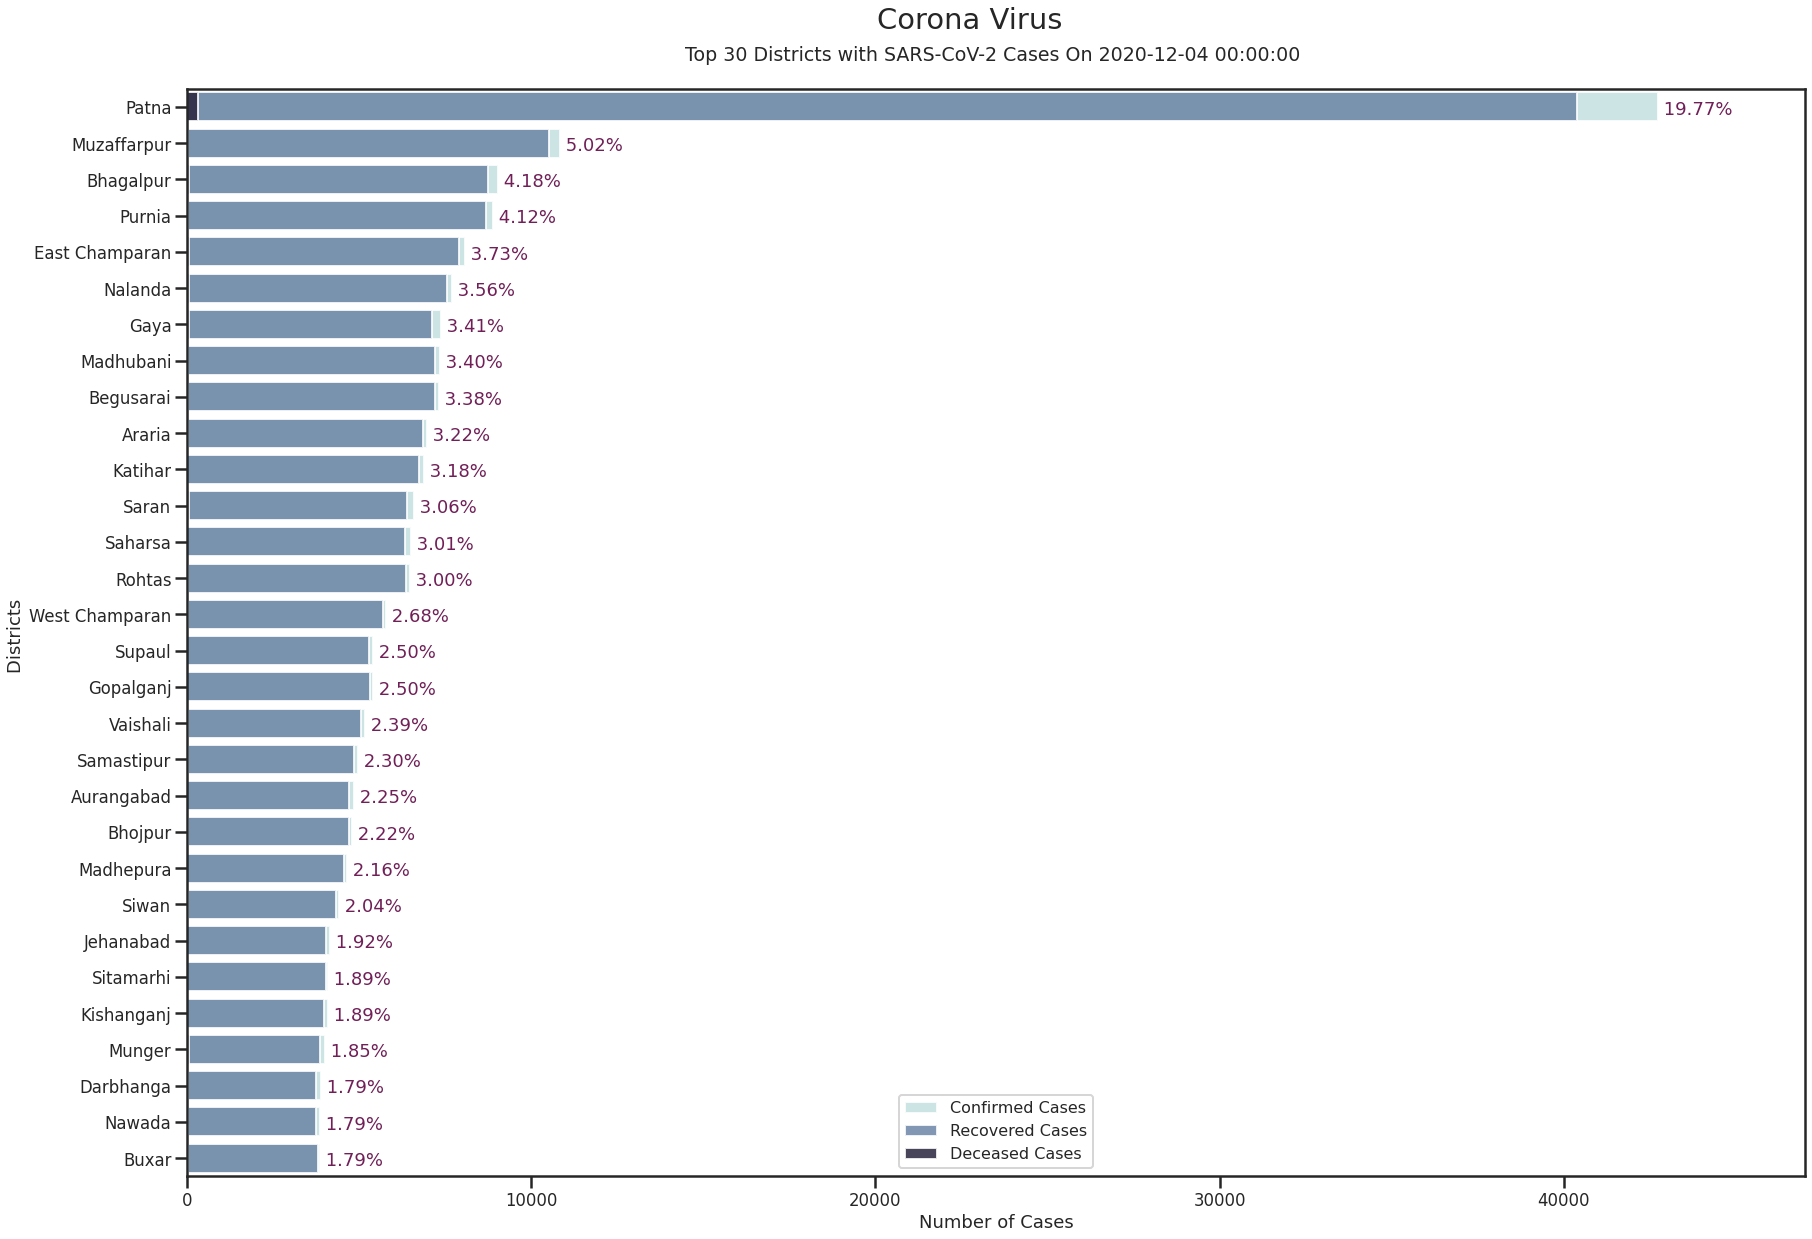

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://images.vexels.com/media/users/3/151175/isolated/preview/c8cccfd752a2c029daaa084aca6bb2bc-percent-pie-chart-doodle-by-vexels.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Countries of Districts of India (Pie Chart)</h2></center><br>
Plot_State = "Bihar" #@param ["India",'Andaman and Nicobar Islands', 'Andhra Pradesh','Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh','Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu','Gujarat', 'Haryana', 'Himachal Pradesh','Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh','Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram','Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh','Uttarakhand', 'West Bengal']
Plot_By = "Confirmed Recovered Deceased" #@param ['Confirmed', 'Recovered', 'Deceased','Tested','Active','Confirmed Recovered Deceased' , 'Confirmed_','Recovered_', 'Deceased_' , 'Confirmed_ Recovered_ Deceased_']
Plot_Month = "12" #@param ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
Plot_Date = "7" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Plot_Top = 30 #@param {type:"slider", min:1, max:100, step:1}


Date = '2020-'+Plot_Month.zfill(2)+'-'+Plot_Date.zfill(2)
display(Markdown("<h2> District WISE PIE CHART CASES of 2019-nCoV</h2>"))
if Date not in District_['Date'].astype(str).unique():
  Date = District_['Date'].max()
Plot_By = Plot_By.split(' ')

if Plot_State == 'India':
  data = District_[District_['Date'] == Date].sort_values(Plot_By[0] , ascending = False).head(Plot_Top)
else:
  data = District_[District_['State'] == Plot_State]
  data = data[data['Date'] == Date].sort_values(Plot_By[0] , ascending = False).head(Plot_Top)

plt.figure(figsize=(Graphs_Width,Graphs_Height))
ax = plt.subplot(1,1,1)
plt.suptitle(Sup_Title, fontsize = 29)
plt.title('\nTop {} Districts with SARS-CoV-2 Cases On {} \n'.format(Plot_Top , Date) , fontsize = 19)

Plot_Top = min(Plot_Top , data.shape[0])
if len(Plot_By) ==1:
  plt_by = Plot_By[0]
  graph = sns.barplot(data=data,y='District',x= plt_by , saturation = Plot_Saturation , alpha = Plot_Alpha, palette =Style_Color, label = plt_by.replace('_', ' Daily ')+' Cases' , orient = 'h')

else:
  plot_color = list(sns.color_palette(Style_Color,n_colors=len(Plot_By)).as_hex())
  for i,plt_by in enumerate(Plot_By):
    graph = sns.barplot(data=data,y='District',x= plt_by , saturation = Plot_Saturation , alpha = Plot_Alpha, color = plot_color[i], label = plt_by.replace('_', ' Daily ')+' Cases' , orient = 'h')
plt.xlim(0,data[Plot_By[0]].max()+data[Plot_By[0]].max()/10 )
plt.ylabel('Districts ')
plt.xlabel('Number of Cases')
plt.legend(loc = 8 , fontsize = 16)
total_cases = data[Plot_By[0]].sum()
for p in graph.patches[:int(Plot_Top)]:
  _x = p.get_x() + p.get_width() 
  _y = p.get_y() + p.get_height()/2 + float(0.2)
  value = ((int(p.get_width())/total_cases)*100)
  if np.isnan(value):
    value = 0.0
  graph.text(_x , _y , ' {:.2f}%'.format(value) , ha = 'left', color = sns.color_palette('rocket')[1])
plt.subplots_adjust(top=SubPlot_Top)

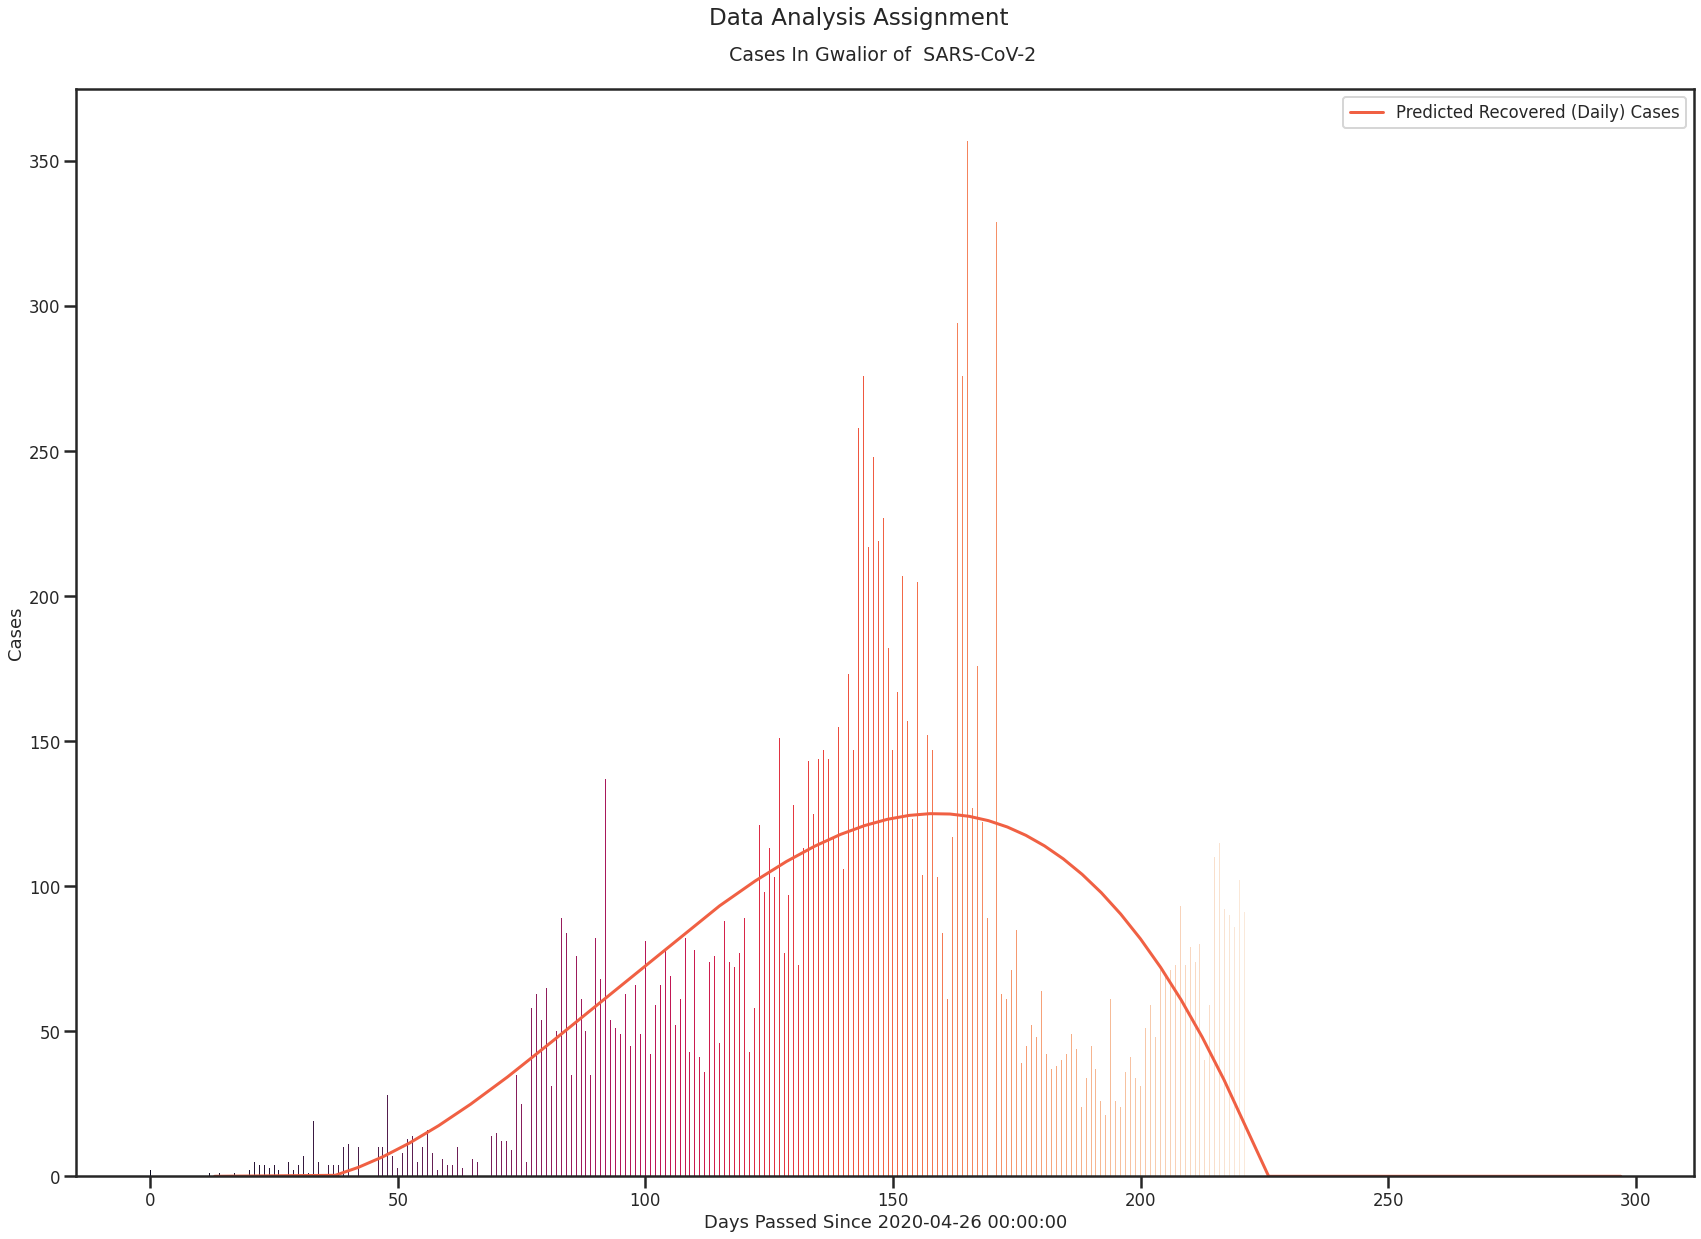

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://cdn.pixabay.com/photo/2013/07/13/12/36/india-159941_960_720.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Districts of India</h2></center><br>
Save_Name = "District Plot" #@param {type:"string"}
Plot_Column = "Recovered_" #@param ['C/R/D' , 'C/R/D/A', 'C/R/D(Daily)' ,'Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_','Tested_', 'Active_', 'Negative']
Plot_District = "Gwalior" #@param ['Agar Malwa', 'Agra', 'Ahmedabad', 'Ahmednagar','Airport Quarantine', 'Aizawl', 'Ajmer', 'Akola', 'Alappuzha','Aligarh', 'Alipurduar', 'Alirajpur', 'Almora', 'Alwar', 'Ambala','Ambedkar Nagar', 'Amethi', 'Amravati', 'Amreli', 'Amritsar','Amroha', 'Anand', 'Anantapur', 'Anantnag', 'Angul', 'Anjaw','Anuppur', 'Araria', 'Aravalli', 'Ariyalur', 'Arwal', 'Ashoknagar','Auraiya', 'Aurangabad', 'Ayodhya', 'Azamgarh', 'BSF Camp','Bagalkote', 'Bageshwar', 'Baghpat', 'Bahraich', 'Balaghat','Balangir', 'Balasore', 'Ballari', 'Ballia', 'Balod','Baloda Bazar', 'Balrampur', 'Bametara', 'Banaskantha', 'Banda','Bandipora', 'Banka', 'Bankura', 'Banswara', 'Barabanki','Baramulla', 'Baran', 'Bareilly', 'Bargarh', 'Barmer', 'Barnala','Barwani', 'Bastar', 'Basti', 'Bathinda', 'Beed', 'Begusarai','Belagavi', 'Bengaluru Rural', 'Bengaluru Urban', 'Betul','Bhadohi', 'Bhadrak', 'Bhagalpur', 'Bhandara', 'Bharatpur','Bharuch', 'Bhavnagar', 'Bhilwara', 'Bhind', 'Bhiwani', 'Bhojpur','Bhopal', 'Bidar', 'Bijapur', 'Bijnor', 'Bikaner', 'Bilaspur','Birbhum', 'Bokaro', 'Botad', 'Boudh', 'Budaun', 'Budgam','Bulandshahr', 'Buldhana', 'Bundi', 'Burhanpur', 'Buxar','Capital Complex', 'Chamarajanagara', 'Chamba', 'Chamoli','Champawat', 'Champhai', 'Chandauli', 'Chandigarh', 'Chandrapur','Changlang', 'Charkhi Dadri', 'Chatra', 'Chengalpattu', 'Chennai','Chhatarpur', 'Chhindwara', 'Chhota Udaipur', 'Chikkaballapura','Chikkamagaluru', 'Chitradurga', 'Chitrakoot', 'Chittoor','Chittorgarh', 'Churu', 'Coimbatore', 'Cooch Behar', 'Cuddalore','Cuttack', 'Dadra and Nagar Haveli', 'Dahod','Dakshin Bastar Dantewada', 'Dakshin Dinajpur', 'Dakshina Kannada','Daman', 'Damoh', 'Dang', 'Darbhanga', 'Darjeeling', 'Datia','Dausa', 'Davanagere', 'Dehradun', 'Delhi', 'Deogarh', 'Deoghar','Deoria', 'Devbhumi Dwarka', 'Dewas', 'Dhalai', 'Dhamtari','Dhanbad', 'Dhar', 'Dharmapuri', 'Dharwad', 'Dhenkanal', 'Dholpur','Dhule', 'Dimapur', 'Dindigul', 'Dindori', 'Diu', 'Doda', 'Dumka','Dungarpur', 'Durg', 'East Champaran', 'East Garo Hills','East Godavari', 'East Jaintia Hills', 'East Kameng','East Khasi Hills', 'East Siang', 'East Singhbhum', 'Ernakulam','Erode', 'Etah', 'Etawah', 'Evacuees', 'Faridabad', 'Faridkot','Farrukhabad', 'Fatehabad', 'Fatehgarh Sahib', 'Fatehpur','Fazilka', 'Ferozepur', 'Firozabad', 'Foreign Evacuees', 'Gadag','Gadchiroli', 'Gajapati', 'Ganderbal', 'Gandhinagar', 'Ganganagar','Ganjam', 'Garhwa', 'Gariaband', 'Gaurela Pendra Marwahi','Gautam Buddha Nagar', 'Gaya', 'Ghaziabad', 'Ghazipur','Gir Somnath', 'Giridih', 'Godda', 'Gomati', 'Gonda', 'Gondia','Gopalganj', 'Gorakhpur', 'Gumla', 'Guna', 'Guntur', 'Gurdaspur','Gurugram', 'Gwalior', 'Hamirpur', 'Hanumangarh', 'Hapur', 'Harda','Hardoi', 'Haridwar', 'Hassan', 'Hathras', 'Haveri', 'Hazaribagh','Hingoli', 'Hisar', 'Hnahthial', 'Hooghly', 'Hoshangabad','Hoshiarpur', 'Howrah', 'Idukki', 'Indore', 'Italians', 'Jabalpur','Jagatsinghpur', 'Jaipur', 'Jaisalmer', 'Jajpur', 'Jalandhar','Jalaun', 'Jalgaon', 'Jalna', 'Jalore', 'Jalpaiguri', 'Jammu','Jamnagar', 'Jamtara', 'Jamui', 'Janjgir Champa', 'Jashpur','Jaunpur', 'Jehanabad', 'Jhabua', 'Jhajjar', 'Jhalawar', 'Jhansi','Jhargram', 'Jharsuguda', 'Jhunjhunu', 'Jind', 'Jodhpur','Junagadh', 'Kabeerdham', 'Kaimur', 'Kaithal', 'Kalaburagi','Kalahandi', 'Kalimpong', 'Kallakurichi', 'Kamle', 'Kancheepuram','Kandhamal', 'Kangra', 'Kannauj', 'Kannur', 'Kanpur Dehat','Kanpur Nagar', 'Kanyakumari', 'Kapurthala', 'Karaikal', 'Karauli','Kargil', 'Karnal', 'Karur', 'Kasaragod', 'Kasganj', 'Kathua','Katihar', 'Katni', 'Kaushambi', 'Kendrapara', 'Kendujhar','Khagaria', 'Khandwa', 'Khargone', 'Khawzawl', 'Kheda', 'Khordha','Khowai', 'Khunti', 'Kinnaur', 'Kiphire', 'Kishanganj', 'Kishtwar','Kodagu', 'Koderma', 'Kohima', 'Kolar', 'Kolasib', 'Kolhapur','Kolkata', 'Kollam', 'Kondagaon', 'Koppal', 'Koraput', 'Korba','Koriya', 'Kota', 'Kottayam', 'Kozhikode', 'Kra Daadi', 'Krishna','Krishnagiri', 'Kulgam', 'Kullu', 'Kupwara', 'Kurnool','Kurukshetra', 'Kurung Kumey', 'Kushinagar', 'Kutch','Lahaul and Spiti', 'Lakhimpur Kheri', 'Lakhisarai', 'Lalitpur','Latehar', 'Latur', 'Lawngtlai', 'Leh', 'Lepa Rada', 'Lohardaga','Lohit', 'Longding', 'Longleng', 'Lower Dibang Valley','Lower Siang', 'Lower Subansiri', 'Lucknow', 'Ludhiana', 'Lunglei','Madhepura', 'Madhubani', 'Madurai', 'Maharajganj', 'Mahasamund','Mahe', 'Mahendragarh', 'Mahisagar', 'Mahoba', 'Mainpuri','Malappuram', 'Malda', 'Malkangiri', 'Mamit', 'Mandi', 'Mandla','Mandsaur', 'Mandya', 'Mansa', 'Mathura', 'Mau', 'Mayurbhanj','Meerut', 'Mehsana', 'Mirzapur', 'Moga', 'Mokokchung', 'Mon','Moradabad', 'Morbi', 'Morena', 'Mumbai', 'Mungeli', 'Munger','Murshidabad', 'Muzaffarnagar', 'Muzaffarpur', 'Mysuru','Nabarangapur', 'Nadia', 'Nagapattinam', 'Nagaur', 'Nagpur','Nainital', 'Nalanda', 'Namakkal', 'Namsai', 'Nanded', 'Nandurbar','Narayanpur', 'Narmada', 'Narsinghpur', 'Nashik', 'Navsari','Nawada', 'Nayagarh', 'Neemuch', 'Nilgiris', 'Niwari','North 24 Parganas', 'North Garo Hills', 'North Tripura','Nuapada', 'Nuh', 'Osmanabad', 'Other Region', 'Other State','Others', 'Pakke Kessang', 'Pakur', 'Palakkad', 'Palamu','Palghar', 'Pali', 'Palwal', 'Panchkula', 'Panchmahal', 'Panipat','Panna', 'Papum Pare', 'Parbhani', 'Paschim Bardhaman','Paschim Medinipur', 'Patan', 'Pathanamthitta', 'Pathankot','Patiala', 'Patna', 'Pauri Garhwal', 'Perambalur', 'Peren', 'Phek','Pilibhit', 'Pithoragarh', 'Porbandar', 'Prakasam', 'Pratapgarh','Prayagraj', 'Puducherry', 'Pudukkottai', 'Pulwama', 'Punch','Pune', 'Purba Bardhaman', 'Purba Medinipur', 'Puri', 'Purnia','Purulia', 'Rae Bareli', 'Raichur', 'Raigad', 'Raigarh','Railway Quarantine', 'Raipur', 'Raisen', 'Rajgarh', 'Rajkot','Rajnandgaon', 'Rajouri', 'Rajsamand', 'Ramanagara','Ramanathapuram', 'Ramban', 'Ramgarh', 'Rampur', 'Ranchi','Ranipet', 'Ratlam', 'Ratnagiri', 'Rayagada', 'Reasi', 'Rewa','Rewari', 'Ribhoi', 'Rohtak', 'Rohtas', 'Rudraprayag', 'Rupnagar','S.A.S. Nagar', 'S.P.S. Nellore', 'Sabarkantha', 'Sagar','Saharanpur', 'Saharsa', 'Sahibganj', 'Saiha', 'Saitual', 'Salem','Samastipur', 'Samba', 'Sambalpur', 'Sambhal', 'Sangli', 'Sangrur','Sant Kabir Nagar', 'Saraikela-Kharsawan', 'Saran', 'Satara','Satna', 'Sawai Madhopur', 'Sehore', 'Seoni', 'Serchhip','Shahdol', 'Shahid Bhagat Singh Nagar', 'Shahjahanpur', 'Shajapur','Shamli', 'Sheikhpura', 'Sheohar', 'Sheopur', 'Shi Yomi', 'Shimla','Shivamogga', 'Shivpuri', 'Shopiyan', 'Shrawasti', 'Siang','Siddharthnagar', 'Sidhi', 'Sikar', 'Simdega', 'Sindhudurg','Singrauli', 'Sipahijala', 'Sirmaur', 'Sirohi', 'Sirsa','Sitamarhi', 'Sitapur', 'Sivaganga', 'Siwan', 'Solan', 'Solapur','Sonbhadra', 'Sonipat', 'South 24 Parganas', 'South Garo Hills','South Tripura', 'South West Garo Hills', 'South West Khasi Hills','Sri Muktsar Sahib', 'Srikakulam', 'Srinagar', 'State Pool','Subarnapur', 'Sukma', 'Sultanpur', 'Sundargarh', 'Supaul','Surajpur', 'Surat', 'Surendranagar', 'Surguja', 'Tapi','Tarn Taran', 'Tawang', 'Tehri Garhwal', 'Tenkasi', 'Thane','Thanjavur', 'Theni', 'Thiruvallur', 'Thiruvananthapuram','Thiruvarur', 'Thoothukkudi', 'Thrissur', 'Tikamgarh', 'Tirap','Tiruchirappalli', 'Tirunelveli', 'Tirupathur', 'Tiruppur','Tiruvannamalai', 'Tonk', 'Tuensang', 'Tumakuru', 'Udaipur','Udham Singh Nagar', 'Udhampur', 'Udupi', 'Ujjain', 'Umaria','Una', 'Unknown', 'Unnao', 'Unokoti', 'Upper Dibang Valley','Upper Siang', 'Upper Subansiri', 'Uttar Bastar Kanker','Uttar Dinajpur', 'Uttara Kannada', 'Uttarkashi', 'Vadodara','Vaishali', 'Valsad', 'Varanasi', 'Vellore', 'Vidisha','Vijayapura', 'Viluppuram', 'Virudhunagar', 'Visakhapatnam','Vizianagaram', 'Wardha', 'Washim', 'Wayanad', 'West Champaran','West Garo Hills', 'West Godavari', 'West Jaintia Hills','West Kameng', 'West Khasi Hills', 'West Siang', 'West Singhbhum','West Tripura', 'Wokha', 'Y.S.R. Kadapa', 'Yadgir', 'Yamunanagar','Yanam', 'Yavatmal', 'Zunheboto']
Regression_Power = 3 #@param {type:"slider", min:0, max:20, step:1}
Train_on_days_from = 13 #@param {type:"slider", min:0, max:300, step:1}
Predict_of_future_days = 76 #@param {type:"slider", min:0, max:200, step:1}
Bar_Plot = True #@param {type:"boolean"}
Line_Plot = False #@param {type:"boolean"}

if Plot_Column == 'C/R/D':
  Plot_Column = ['Confirmed' , 'Recovered' , 'Deceased']
elif Plot_Column == 'C/R/D/A':
  Plot_Column = ['Confirmed' , 'Recovered' , 'Deceased' , 'Active']
elif Plot_Column == 'C/R/D(Daily)':
  Plot_Column = ['Confirmed_' , 'Recovered_' , 'Deceased_']
else:
  Plot_Column = [Plot_Column]

data = District_[District_.District == Plot_District]

plot_color = list(sns.color_palette(Style_Color,n_colors=len(Plot_Column)*2).as_hex())
plt.figure(figsize=(Graphs_Width,Graphs_Height))
if Bar_Plot:
  if len(Plot_Column) == 1:
    plt.bar(data['Days_Passed'].values,data[Plot_Column[0]].values, width = 0.2 , linewidth = 0 , color = list(sns.color_palette(Style_Color,n_colors=len(data['Days_Passed'].values)).as_hex()) )
for col,i in enumerate(Plot_Column):
  if Line_Plot:
    plt.plot(data[i].values, label = '{} Cases '.format(i.replace('_',' (Daily)').title()) , color = plot_color[col*2] )
  if Regression_Power:
    model = np.poly1d(np.polyfit(data['Days_Passed'].values[Train_on_days_from:], data[i].values[Train_on_days_from:], Regression_Power))
    polyline = np.linspace(Train_on_days_from, data['Days_Passed'].max()+Predict_of_future_days, 5000) 
    plt.plot(polyline , [0 if i<0 else i for i in model(polyline)]  , label = 'Predicted {} Cases'.format(i.replace('_',' (Daily)').title()) , color = plot_color[col*2+1])

plt.suptitle('Data Analysis Assignment', fontsize = 23)
plt.title('Cases In {} of  SARS-CoV-2 \n'.format(Plot_District) , fontsize = 19)
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Days Passed Since {}'.format(District_['Date'].min()))
plt.subplots_adjust(top=SubPlot_Top)

plt.savefig('/content/{} {}.{}'.format(Save_Name , time.time() , Format_To_Save) , bbox_inches = 'tight')



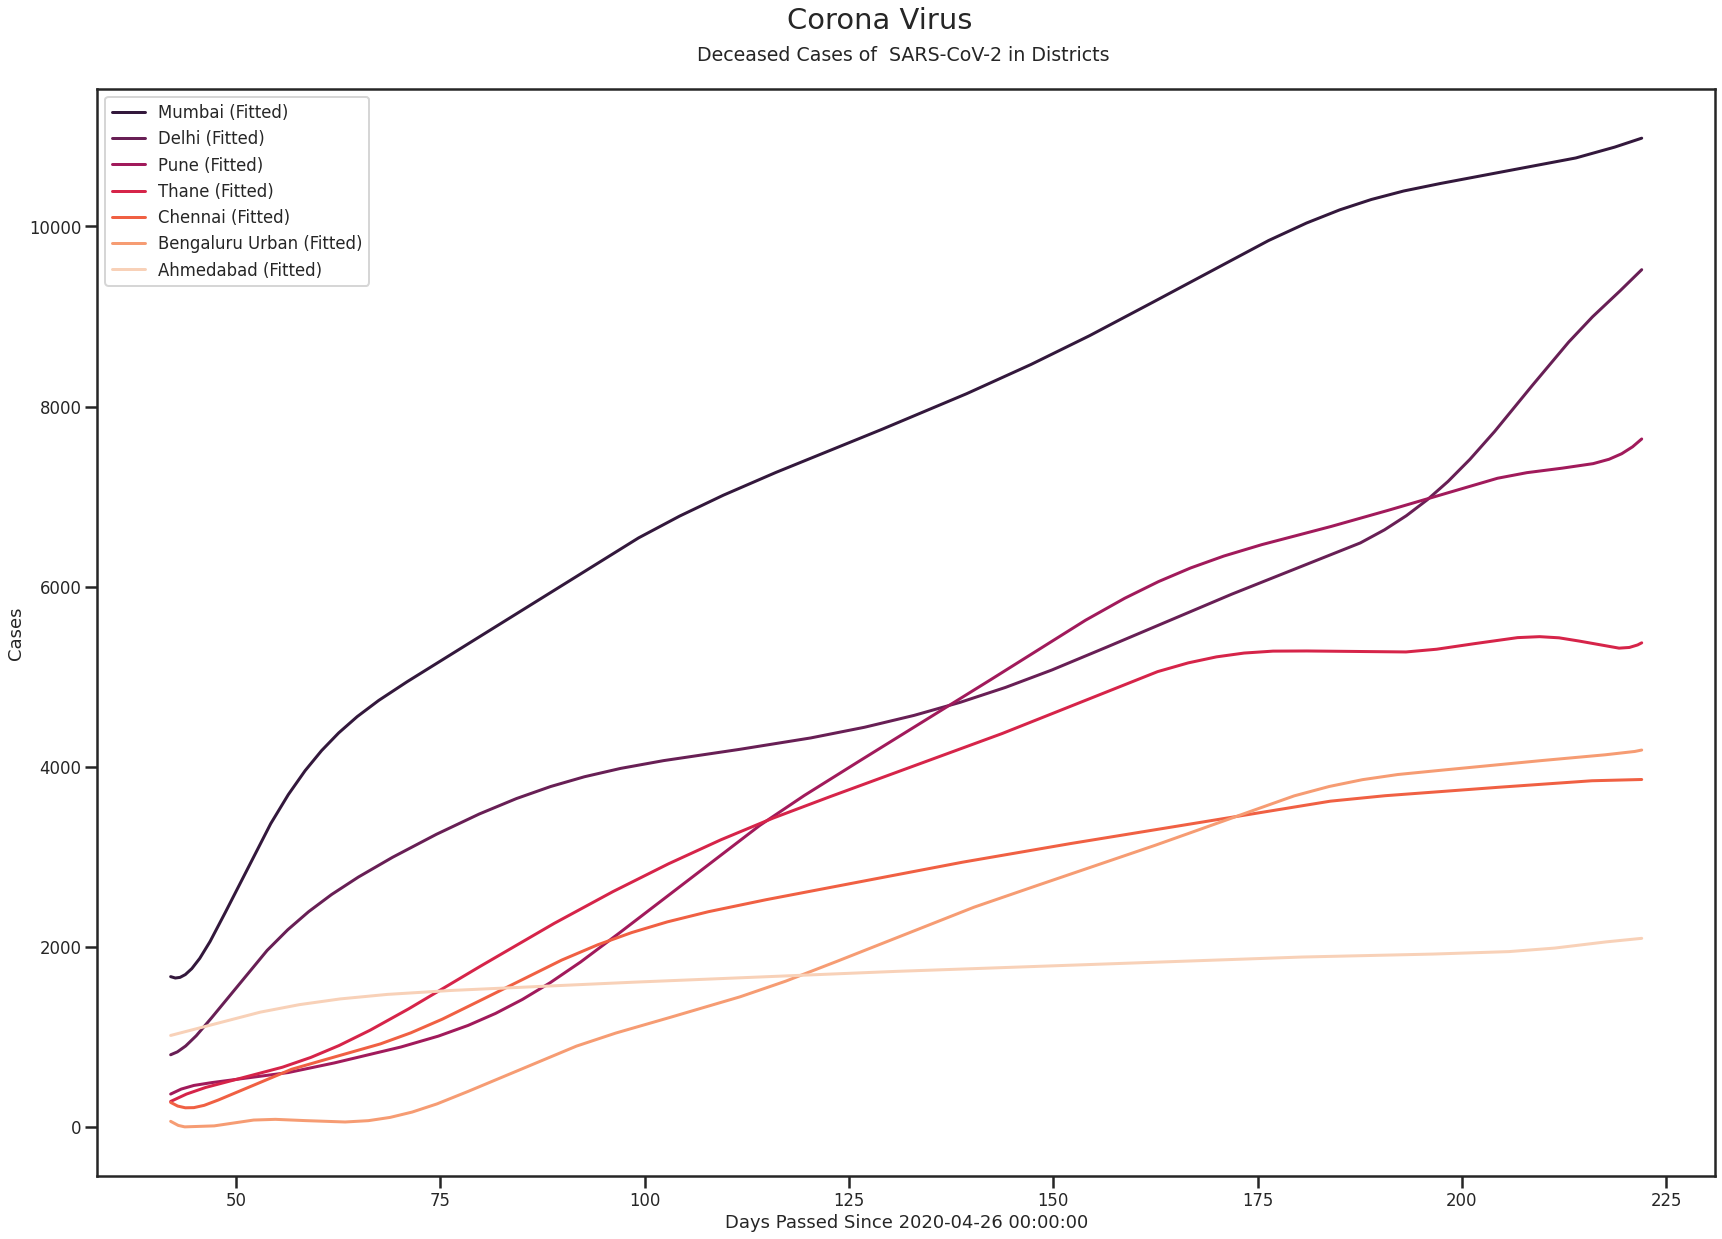

In [ ]:
#@markdown <h3>⬅️ Click Here to START Plotting</h3>
#@markdown <br><center><img src='https://assets.website-files.com/5d9ba0eb5f6edb77992a99d0/5e62506c9394b24aa66cf385_iconfinder_connection-route-spread-virus-global_5728179.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Plot Corona Virus Cases in Country</h2></center><br>
Save_Name = "District  Plot" #@param {type:"string"}
Plot_State = "India" #@param ["India",'Andaman and Nicobar Islands', 'Andhra Pradesh','Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh','Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu','Gujarat', 'Haryana', 'Himachal Pradesh','Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh','Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram','Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh','Uttarakhand', 'West Bengal']
Plot_By = "Deceased" #@param ['Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_','Tested_', 'Active_', 'Negative']
Use_Method = "mean" #@param ["sum", "mean", "max", "median", "min", "std", "var"]
Plot_top = 6 #@param {type:"slider", min:0, max:100, step:1}
Regression_Power = 12 #@param {type:"slider", min:0, max:20, step:1}
Train_on_days_from = 42 #@param {type:"slider", min:0, max:300, step:1}
Predict_of_future_days = 0 #@param {type:"slider", min:0, max:200, step:1}
Line_Plot = False #@param {type:"boolean"}

if Plot_State == 'India':
  Locations = District_.groupby('District').agg({Plot_By:Use_Method}).sort_values(by=[Plot_By] , ascending = False).reset_index()['District'].head(Plot_top+1).values
else:
  Locations = District_[District_['State']==Plot_State].groupby('District').agg({Plot_By:Use_Method}).sort_values(by=[Plot_By] , ascending = False).reset_index()['District'].head(Plot_top+1).values

plot_color = list(sns.color_palette(Style_Color,n_colors=len(Locations)*2).as_hex())

plt.figure(figsize=(Graphs_Width,Graphs_Height))
for i,Location in enumerate(Locations):
  if Location in District_.District.unique() and Location != 'Unknown' :
    data = District_[District_.District == Location]
    if Line_Plot:
      plt.plot(data[Plot_By].values, label = '{}'.format(Location) , color = plot_color[i*2] )
    if Regression_Power:
      model = np.poly1d(np.polyfit(data['Days_Passed'].values[Train_on_days_from:], data[Plot_By].values[Train_on_days_from:], Regression_Power))
      polyline = np.linspace(Train_on_days_from, District_['Days_Passed'].max()+Predict_of_future_days, 5000) 
      plt.plot(polyline , [0 if i<0 else i for i in model(polyline)]  , label = '{} (Fitted)'.format(Location) , color = plot_color[i*2+1])
    
plt.suptitle(Sup_Title, fontsize = 29)
plt.title('{} Cases of  SARS-CoV-2 in Districts \n'.format(Plot_By.replace('_',' (Daily)').title() ) , fontsize = 19)
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Days Passed Since {}'.format(District_['Date'].min()))
plt.subplots_adjust(top=SubPlot_Top)
plt.savefig('/content/{} {}.{}'.format(Save_Name , time.time() , Format_To_Save) , bbox_inches = 'tight')


# Forecasting and Best Fit

##SEIR Model

## India In Intial Phase
Optimized infection rate:  0.8255680895736905
Optimized recovered rate:  -0.021930628787529566
Optimized exposed rate:  0.07490603293465342
Optimized reinfection rate:  9.005065119369617


## India after Phase
Optimize infection rate:  0.4439266926427083
Optimize recovered rate:  0.19098986817212765
Optimize exposed rate:  0.16085410577838868
Optimized reinfection rate:  0.20593278928265063


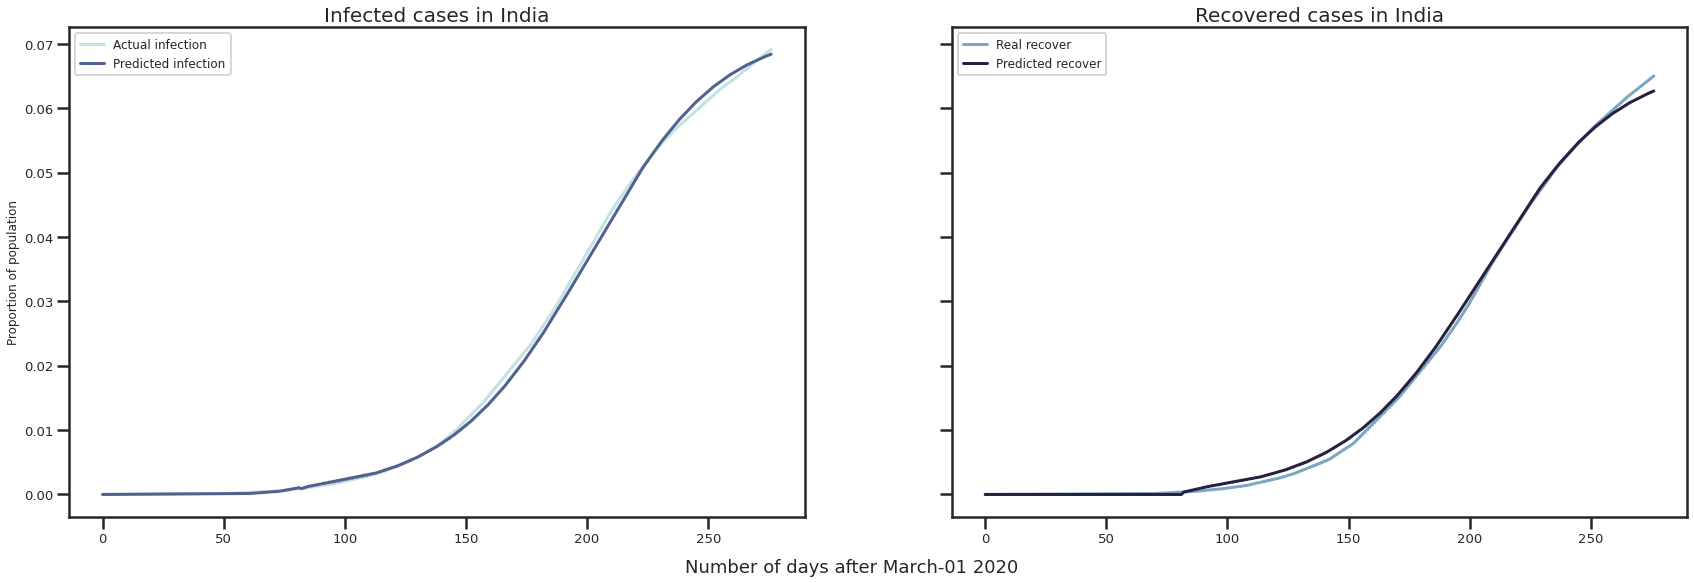

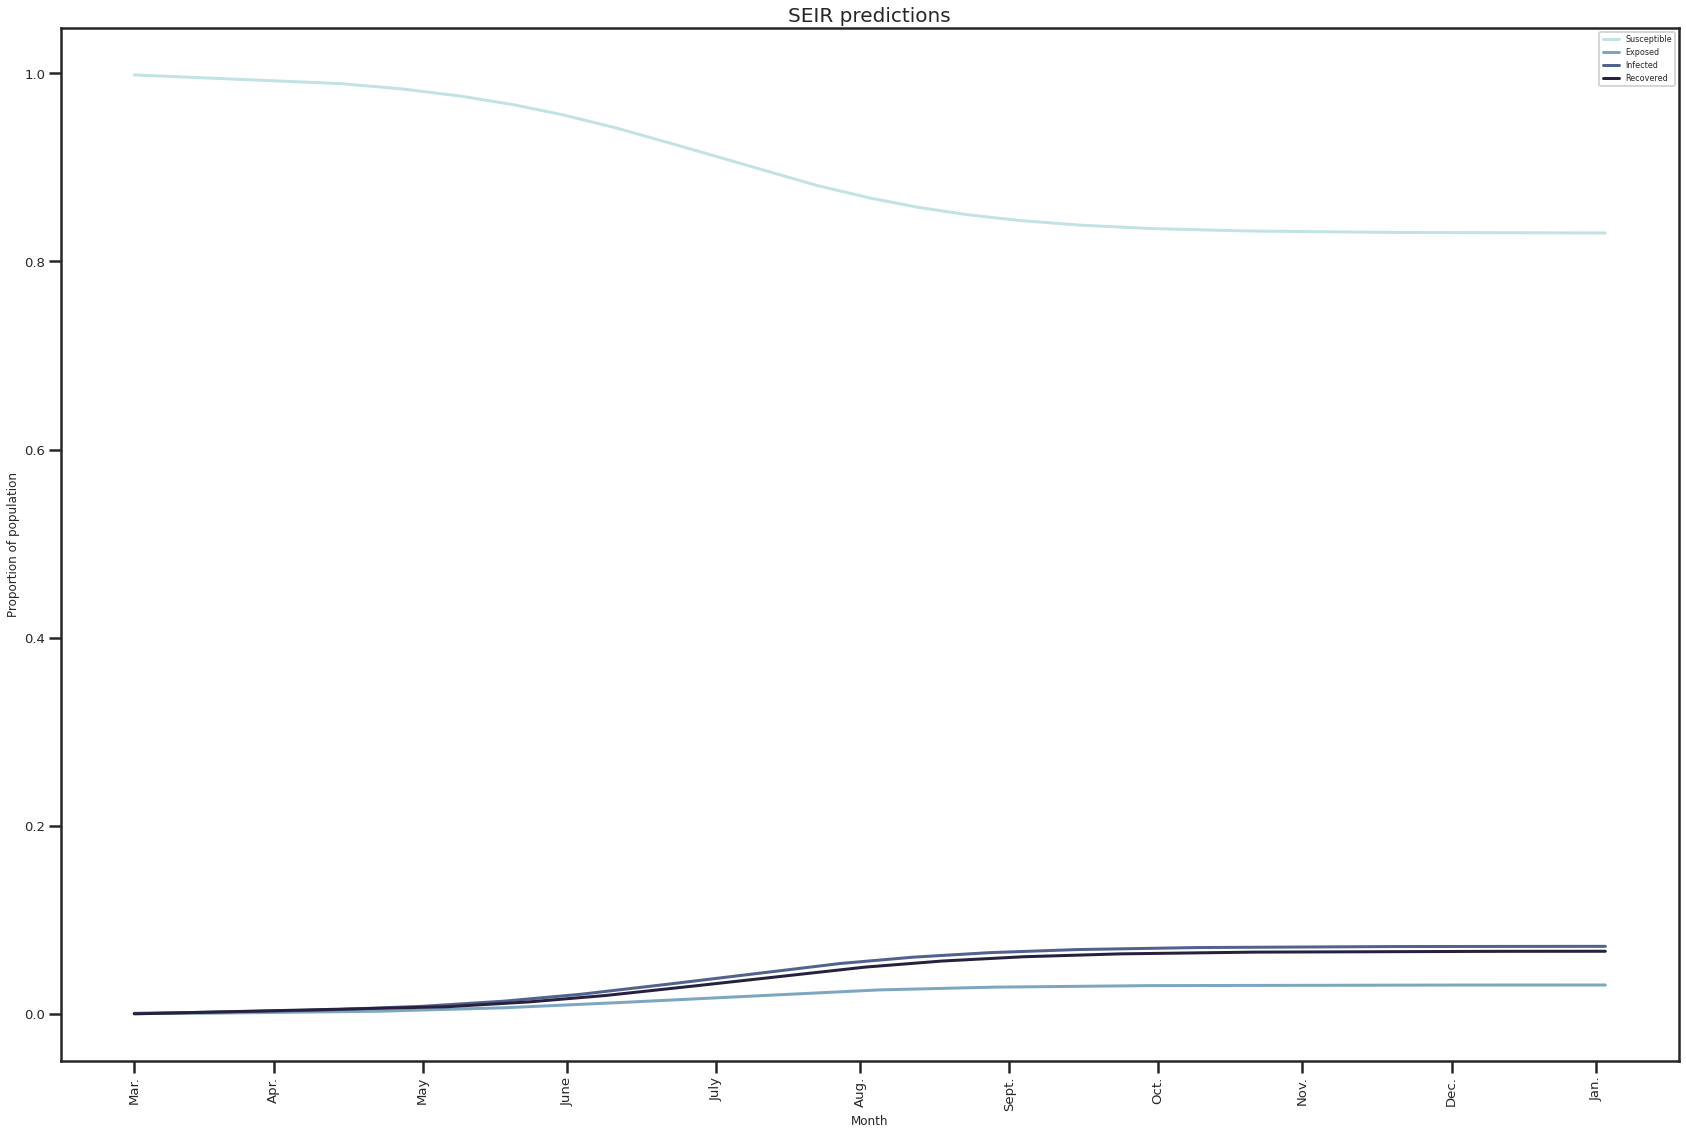

In [ ]:
#@markdown <h3>⬅️ Click Here to START Fitting</h3>
#@markdown <br><center><img src='https://file.scirp.org/Html/3-7401490/5c6169a0-4c91-4bdc-be3e-3c9ba7cf13ce.jpg' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2><br>Predict Corona Virus Cases in Country With SEIR Model</h2></center><br>
Days_From_Exposed_To_Infected = 10 #@param {type:"slider", min:0, max:21, step:1}
Phase_Differnce = 81 #@param {type:"slider", min:0, max:300, step:1}


def seir_model_ode(y, t, params): 
  infection_rate = params[0]
  recovery_rate = params[1]
  exposed_rate = params[2]
  reinfection_rate = params[3]
  
  s = y[0]
  e = y[1]
  i = y[2]
  r = y[3]

  dsdt = -exposed_rate*s*(i+e) + reinfection_rate*r
  dedt = (exposed_rate*s*(i+e)) - (infection_rate*e)
  didt = (infection_rate*e) - (recovery_rate*i)
  drdt = recovery_rate*i - reinfection_rate*r

  return (dsdt, dedt, didt, drdt)

def calculate_seir_model(params, t, initial_condition):
  seir_ode = lambda y,t:seir_model_ode(y,t, params)
  ode_result = integrate.odeint(func=seir_ode, y0=initial_condition, t=t)
  return ode_result

def fit_seir_model(params_to_fit, t, initial_condition, i_r_true):
  fit_result = calculate_seir_model(params_to_fit, t, initial_condition)
  residual_i = i_r_true[0] - fit_result[:,2]
  residual_r = i_r_true[1] - fit_result[:,3]
  residual = np.concatenate((residual_i, residual_r))
  return residual 

def country2Divided(N, status,lockdownDay,countryName):
  plot_color = list(sns.color_palette(Style_Color,n_colors=4).as_hex())
  I_start = status.loc[0, 'Confirmed']/N
  E_start = (status.loc[Days_From_Exposed_To_Infected, 'Confirmed'] - status.loc[0, 'Confirmed'])/N
  S_start = 1 - E_start - I_start
  R_start = status.loc[0, 'Recovered']/N

  ic = (S_start, E_start, I_start, R_start)

  beforelockdown=status.loc[0:lockdownDay]
  afterlockdown=status.loc[lockdownDay+1:]
  i_r_true_bf = (list(beforelockdown['Confirmed']/N), list(beforelockdown['Recovered']/N))
  i_r_true_af = (list(afterlockdown['Confirmed']/N), list(afterlockdown['Recovered']/N))

  time_opt_bf = range(0, lockdownDay+1)
  time_opt_af = range(0, len(afterlockdown))
  time_opt =range(0,len(status))

  E_start_day = min(len(status['Days_Passed']),len(beforelockdown)+14)
  
  E_start_af = (status.loc[E_start_day, 'Confirmed'] - status.loc[len(beforelockdown), 'Confirmed'])/N
  I_start_af = status.loc[len(beforelockdown), 'Confirmed']/N
  S_start_af = 1 - E_start_af - I_start_af
  R_start_af = status.loc[len(beforelockdown), 'Recovered']/N

  ic_af = (S_start_af, E_start_af, I_start_af, R_start_af)
  
  params_start_guess = [0.01, 0.001, 0.01, 0.001]
  optimal_params, success = optimize.leastsq(fit_seir_model,
    x0=params_start_guess,
    args=(time_opt_bf, ic, i_r_true_bf),
    ftol=1.49012e-22)
  optimal_params_af, success = optimize.leastsq(fit_seir_model,
    x0=params_start_guess,
    args=(time_opt_af, ic_af, i_r_true_af),
    ftol=1.49012e-22)
  
  print('## '+countryName+' In Intial Phase')
  print('Optimized infection rate: ', optimal_params[0])
  print('Optimized recovered rate: ', optimal_params[1])
  print('Optimized exposed rate: ', optimal_params[2])
  print('Optimized reinfection rate: ', optimal_params[3])
  print('\n')
  print('## '+countryName+' after Phase')
  print('Optimize infection rate: ', optimal_params_af[0])
  print('Optimize recovered rate: ', optimal_params_af[1])
  print('Optimize exposed rate: ', optimal_params_af[2])
  print('Optimized reinfection rate: ', optimal_params_af[3])
  ir = optimal_params[0]
  rr = optimal_params[1]
  er = optimal_params[2]
  rir = optimal_params[3]
  ir_af = optimal_params_af[0]
  rr_af = optimal_params_af[1]
  er_af = optimal_params_af[2]
  rir_af = optimal_params_af[3]

  fit_result_bf = calculate_seir_model((ir, rr, er, rir), time_opt_bf, ic)
  fit_result_af = calculate_seir_model((ir_af, rr_af, er_af, rir_af), time_opt_af, ic_af)
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=[Graphs_Width,int(Graphs_Height/2)])
  fig.text(0.5, 0.04, 'Number of days after March-01 2020', ha='center', fontsize=18)

  ax1.set_title('Infected cases in '+ countryName,fontsize=20)
  ax1.plot(time_opt, i_r_true_bf[0]+i_r_true_af[0], 'o-', color= plot_color[0] , markersize = 0.3)
  ax1.plot(time_opt, np.hstack((fit_result_bf[:,2],fit_result_af[:,2])), 'o-', color= plot_color[2] , markersize=0.3)
  ax1.legend(['Actual infection', 'Predicted infection'],loc=2, fontsize=12)
  ax1.set_ylabel('Proportion of population', fontsize=12)
  
  ax2.set_title('Recovered cases in '+countryName,fontsize=20)    
  ax2.plot(time_opt, i_r_true_bf[1]+i_r_true_af[1], 'o-', color= plot_color[1] ,  markersize = .3)
  ax2.plot(time_opt, np.hstack((fit_result_bf[:,3],fit_result_af[:,3])), 'o-', color= plot_color[3],markersize=0.3)
  ax2.legend(['Real recover', 'Predicted recover'],loc=2, fontsize=12)
  datetime_pred = pd.date_range(start="2020-03-01",end="2021-01-01", freq='D')
  pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
  pred_range = range(0, len(pred_time))
  pred_result = calculate_seir_model((ir_af, rr_af, er_af, rir_af), pred_range, ic_af)
  time_axis = [pred_time[i] for i in[0, 29, 60, 90, 121, 151, 182, 213, 243, 274, 304]]
  time_labels = ['Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.', 'Jan.']
  ## Plot SEIDR
  fig, ax = plt.subplots(figsize=[Graphs_Width,Graphs_Height])

  ax.plot(pred_time, pred_result[:,0],color=plot_color[0] ) #susceptible
  ax.plot(pred_time, pred_result[:,1],color=plot_color[1] ) #exposed
  ax.plot(pred_time, pred_result[:,2],color=plot_color[2] ) #infected
  ax.plot(pred_time, pred_result[:,3], color = plot_color[3] ) #recovered
  ax.legend(loc=1, labels=['Susceptible', 'Exposed', 'Infected', 'Recovered'], fontsize=8)
  ax.set_title('SEIR predictions', fontsize=20)
  ax.set_xlabel('Month', fontsize=12)
  ax.set_ylabel('Proportion of population', fontsize=12)
  plt.xticks(time_axis, time_labels, rotation='vertical');

country2Divided(138*1e6 ,India_, Phase_Differnce, 'India');

Text(0.5, 0, 'Days Passed Since 01-Jan-2020')

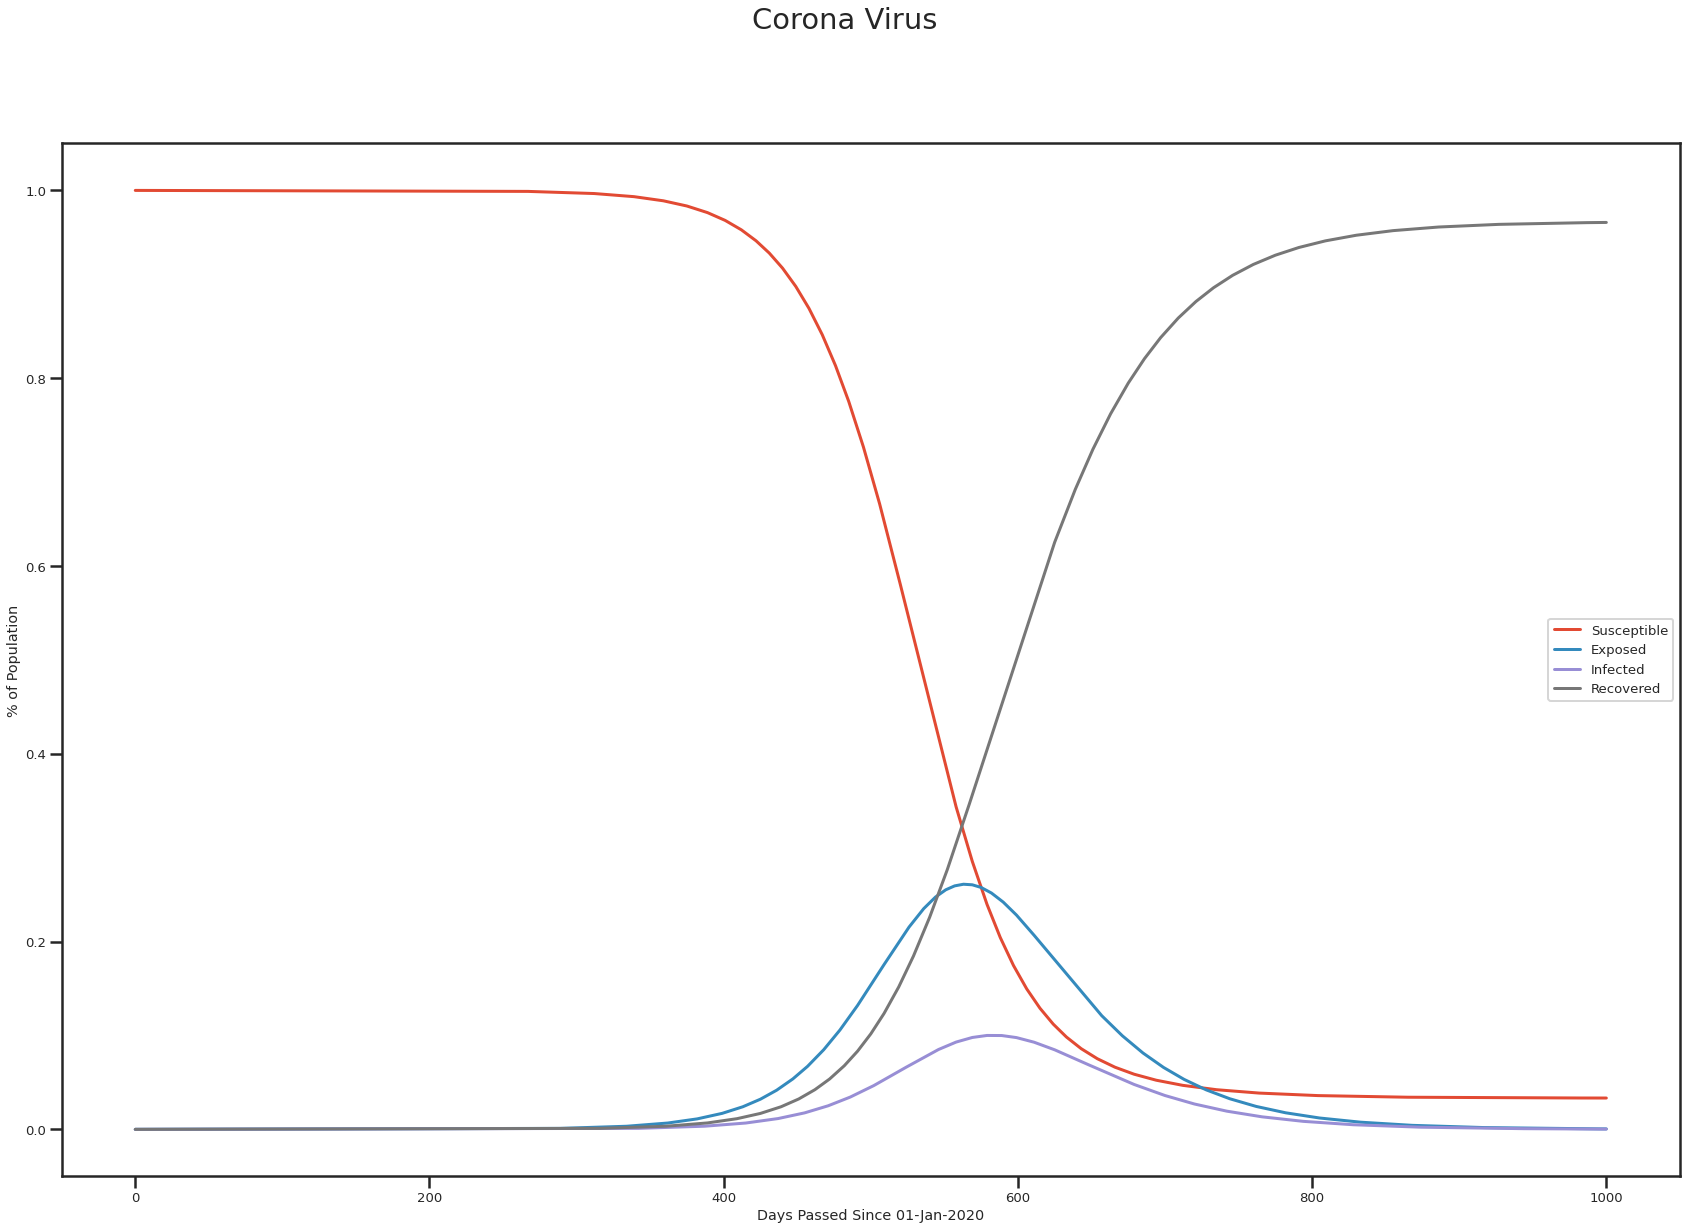

In [ ]:
#@markdown <center><h2><br>How Normal Unoptimized SEIR Model Looks</h2></center><br>

def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return [S,E, I,R]
  
t_max = 100
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 1000000
init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2
beta = 1.75
gamma = 0.5
params = alpha, beta, gamma
# Run simulation
results = base_seir_model(init_vals, params, t)

plt.figure(figsize=(Graphs_Width,Graphs_Height))
plt.suptitle(Sup_Title, fontsize = 29)

for i in results:
  plt.plot(i )
plt.legend(['Susceptible','Exposed','Infected','Recovered'])
plt.ylabel('% of Population')
plt.xlabel('Days Passed Since 01-Jan-2020')

## SEIRD Model

## India In Intial Phase
Optimized infection rate:  0.9660869166824768
Optimized recovered rate:  0.0030155848546408047
Optimized exposed rate:  0.09428398234226203
Optimized reinfection rate:  33.250222672657706
Optimized Death rate:  0.002723514349275098


## India after Phase
Optimize infection rate:  1.1170263380184655
Optimize recovered rate:  0.170086061884728
Optimize exposed rate:  0.17578570540010827
Optimized reinfection rate:  0.1814244904154204
Optimized Death rate:  0.00028505986242192163


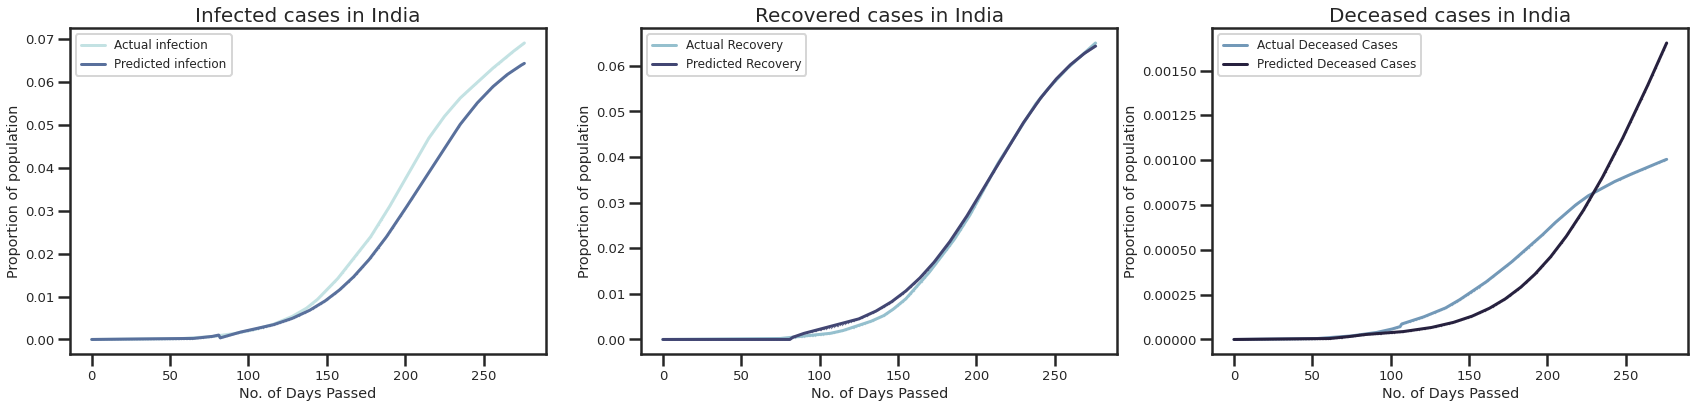

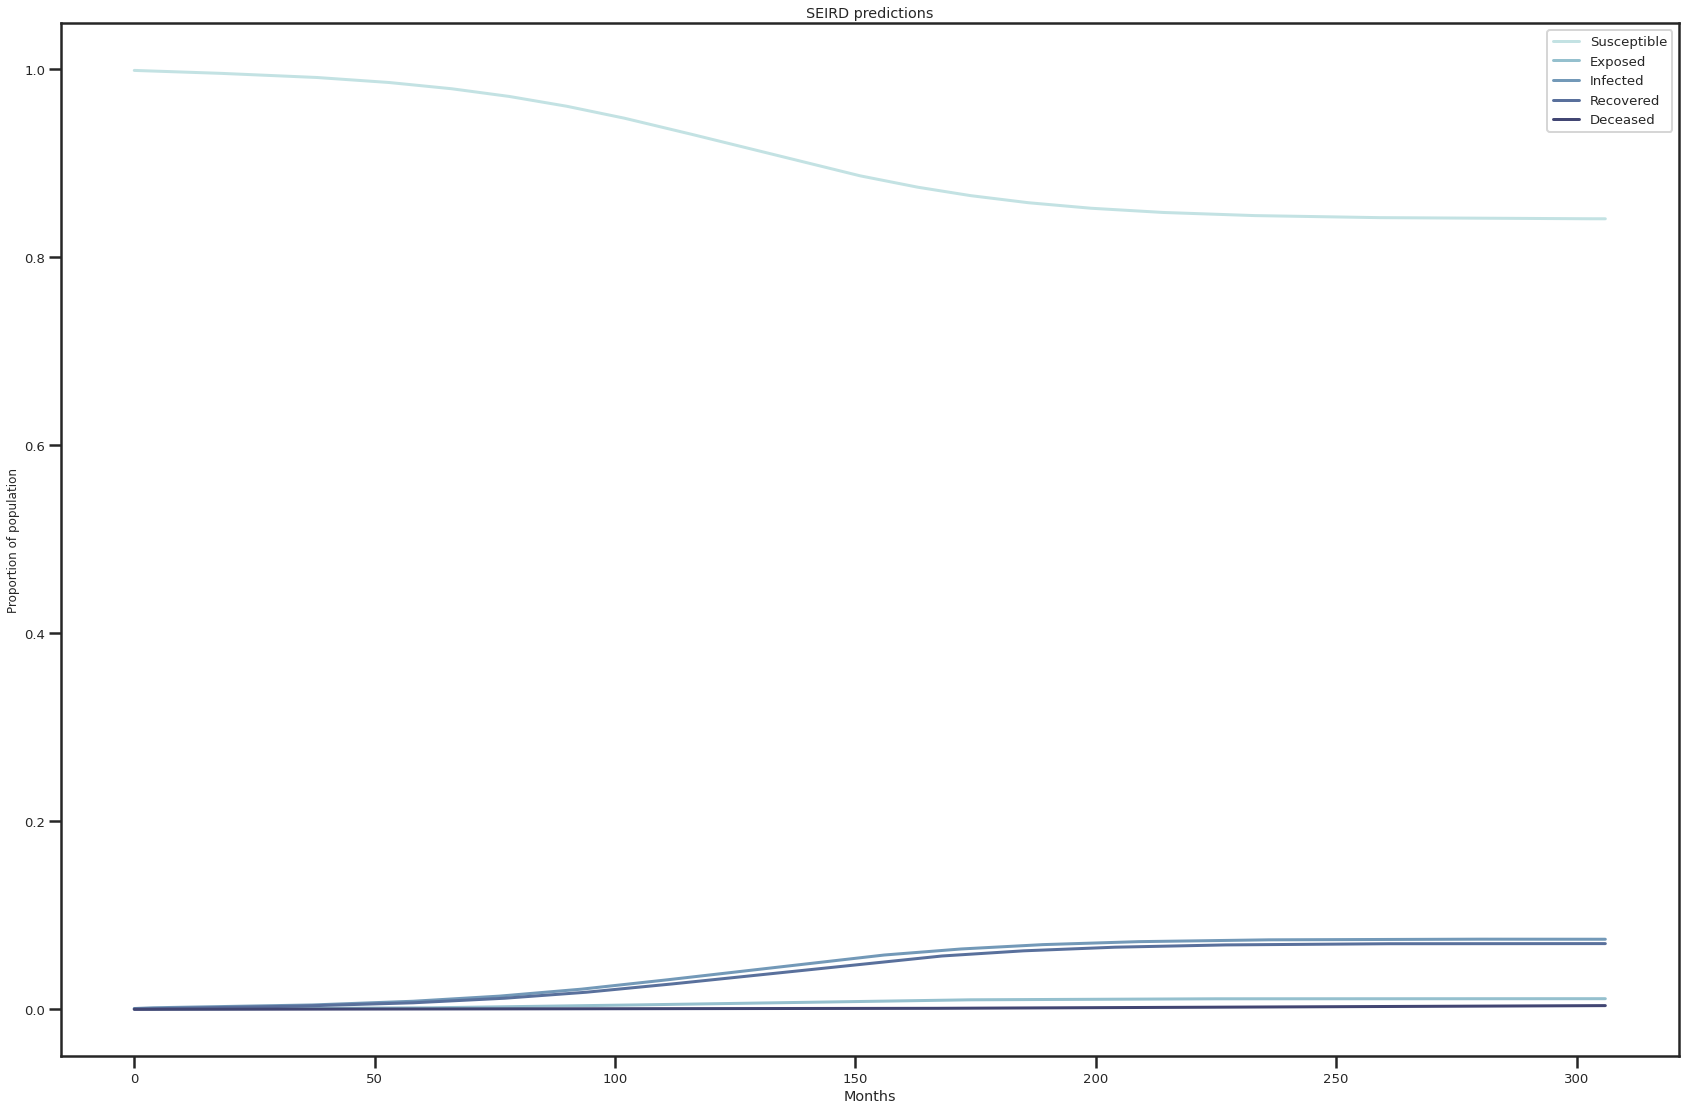

In [ ]:
#@markdown <h3>⬅️ Click Here to START Fitting</h3>
#@markdown <br><center><img src='https://www.researchgate.net/profile/Aboubakary_Diakhaby/publication/280141961/figure/fig1/AS:669979791863820@1536747038195/The-SIRD-model-flow-chart-Basic-model-with-death-and-the-recovered-becoming-susceptible.ppm' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2><br>Predict Corona Virus Cases in Country With SEIRD Model</h2></center><br>
Days_From_Exposed_To_Infected = 14 #@param {type:"slider", min:0, max:21, step:1}
Phase_Differnce = 81 #@param {type:"slider", min:0, max:300, step:1}
Consider_Exposed_as_Infectious = True #@param {type:"boolean"}

def seird_v2_model_ode(y, t, params): 
  # Parameters to find
  infection_rate = params[0]
  recovery_rate = params[1]
  exposed_rate = params[2]
  reinfection_rate = params[3]
  death_rate = params[4]
  
  # Y variables
  s = y[0]
  e = y[1]
  i = y[2]
  r = y[3]
  d = y[4]
  # SIR ODE System 
  dsdt = -exposed_rate*s*i + reinfection_rate*r
  dedt = (exposed_rate*s*i) - (infection_rate*e)
  didt = (infection_rate*e) - (recovery_rate*i + death_rate*i)
  drdt = recovery_rate*i - reinfection_rate*r 
  dddt = death_rate*i
    
  # Return our system
  return (dsdt, dedt, didt, drdt, dddt)


def seird_model_ode(y, t, params): 
  # Parameters to find
  infection_rate = params[0]
  recovery_rate = params[1]
  exposed_rate = params[2]
  reinfection_rate = params[3]
  death_rate = params[4]
  
  # Y variables
  s = y[0]
  e = y[1]
  i = y[2]
  r = y[3]
  d = y[4]
  # SIR ODE System 
  dsdt = -exposed_rate*s*(i+e) + reinfection_rate*r
  dedt = (exposed_rate*s*(i+e)) - (infection_rate*e)
  didt = (infection_rate*e) - (recovery_rate*i + death_rate*i)
  drdt = recovery_rate*i - reinfection_rate*r
  dddt = death_rate*i
    
  # Return our system
  return (dsdt, dedt, didt, drdt, dddt)

def calculate_seird_model(params, t, initial_condition):
  if Consider_Exposed_as_Infectious:
    seird_ode = lambda y,t:seird_model_ode(y,t, params)
  else:
    seird_ode = lambda y,t:seird_v2_model_ode(y,t, params)
  ode_result = integrate.odeint(func=seird_ode, y0=initial_condition, t=t)
  return ode_result

def fit_seird_model(params_to_fit, t, initial_condition, i_r_true):
  fit_result = calculate_seird_model(params_to_fit, t, initial_condition)
  residual_i = i_r_true[0] - fit_result[:,2]
  residual_r = i_r_true[1] - fit_result[:,3]
  residual_d = i_r_true[2] - fit_result[:,4]
  residual = np.concatenate((residual_i, residual_r , residual_d))
  return residual 

def seird_predict(N, status,lockdownDay,countryName):
  #Initial Values of SEIRD
  I_start = status.loc[0, 'Confirmed']/N
  E_start = (status.loc[Days_From_Exposed_To_Infected, 'Confirmed'] - status.loc[0, 'Confirmed'])/N
  S_start = 1 - E_start - I_start
  R_start = status.loc[0, 'Recovered']/N
  D_start = status.loc[0, 'Deceased']/N
  ic = (S_start, E_start, I_start, R_start , D_start)

  #Dividing the Data to Two Phases
  beforelockdown=status.loc[0:lockdownDay]
  afterlockdown=status.loc[lockdownDay+1:]
  i_r_true_bf = (list(beforelockdown['Confirmed']/N), list(beforelockdown['Recovered']/N) , list(beforelockdown['Deceased']/N))
  i_r_true_af = (list(afterlockdown['Confirmed']/N), list(afterlockdown['Recovered']/N) , list(afterlockdown['Deceased']/N))

  time_opt_bf = range(0, lockdownDay+1)
  time_opt_af = range(0, len(afterlockdown))
  time_opt =range(0,len(status))
  
  # Find Minimum for Start Day of Exposed Data

  E_start_day = min(len(status['Days_Passed']),len(beforelockdown)+Days_From_Exposed_To_Infected)
  E_start_af = (status.loc[E_start_day, 'Confirmed'] - status.loc[len(beforelockdown), 'Confirmed'])/N
  I_start_af = status.loc[len(beforelockdown), 'Confirmed']/N
  S_start_af = 1 - E_start_af - I_start_af
  R_start_af = status.loc[len(beforelockdown), 'Recovered']/N
  D_start_af = status.loc[len(beforelockdown) , 'Deceased']/N

  # Calculating Optimal Solution
  ic_af = (S_start_af, E_start_af, I_start_af, R_start_af, D_start_af)  
  params_start_guess = [0.01, 0.001, 0.005, 0.001 , 0.00005]
  optimal_params, success = optimize.leastsq(fit_seird_model,
    x0=params_start_guess,
    args=(time_opt_bf, ic, i_r_true_bf),
    ftol=1.49012e-22)
  optimal_params_af, success = optimize.leastsq(fit_seird_model,
    x0=params_start_guess,
    args=(time_opt_af, ic_af, i_r_true_af),
    ftol=1.49012e-22)
  
  # Printing Optimal Solution
  print('## '+countryName+' In Intial Phase')
  print('Optimized infection rate: ', optimal_params[0])
  print('Optimized recovered rate: ', optimal_params[1])
  print('Optimized exposed rate: ', optimal_params[2])
  print('Optimized reinfection rate: ', optimal_params[3])
  print('Optimized Death rate: ', optimal_params[4])
  print('\n')
  print('## '+countryName+' after Phase')
  print('Optimize infection rate: ', optimal_params_af[0])
  print('Optimize recovered rate: ', optimal_params_af[1])
  print('Optimize exposed rate: ', optimal_params_af[2])
  print('Optimized reinfection rate: ', optimal_params_af[3])
  print('Optimized Death rate: ', optimal_params_af[4])
  ir = optimal_params[0]
  rr = optimal_params[1]
  er = optimal_params[2]
  rir = optimal_params[3]
  dr = optimal_params[4]
  ir_af = optimal_params_af[0]
  rr_af = optimal_params_af[1]
  er_af = optimal_params_af[2]
  rir_af = optimal_params_af[3]
  dr_af = optimal_params_af[4]

  fit_result_bf = calculate_seird_model((ir, rr, er, rir , dr), time_opt_bf, ic)
  fit_result_af = calculate_seird_model((ir_af, rr_af, er_af, rir_af , dr_af), time_opt_af, ic_af)

  plot_color = list(sns.color_palette(Style_Color,n_colors=6).as_hex())
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=False, sharex=False, figsize=[Graphs_Width,int(Graphs_Height/3)])
  # fig.text(0.5, 0.04, 'Number of days after March-01 2020', ha='center', fontsize=18)

  ax1.set_title('Infected cases in '+ countryName,fontsize=20)
  ax1.plot(time_opt, i_r_true_bf[0]+i_r_true_af[0], 'o-', color= plot_color[0] , markersize = 0.3)
  ax1.plot(time_opt, np.hstack((fit_result_bf[:,2],fit_result_af[:,3])), 'o-', color= plot_color[3] , markersize=0.3)
  ax1.legend(['Actual infection', 'Predicted infection'],loc=2, fontsize=12)
  ax1.set_ylabel('Proportion of population')
  ax1.set_xlabel('No. of Days Passed')
  
  ax2.set_title('Recovered cases in '+countryName,fontsize=20)    
  ax2.plot(time_opt, i_r_true_bf[1]+i_r_true_af[1], 'o-', color= plot_color[1] ,  markersize = .3)
  ax2.plot(time_opt, np.hstack((fit_result_bf[:,3],fit_result_af[:,3])), 'o-', color= plot_color[4],markersize=0.3)
  ax2.legend(['Actual Recovery', 'Predicted Recovery'],loc=2, fontsize=12)
  ax2.set_ylabel('Proportion of population')
  ax2.set_xlabel('No. of Days Passed')

  ax3.set_title('Deceased cases in '+countryName,fontsize=20)    
  ax3.plot(time_opt, i_r_true_bf[2]+i_r_true_af[2], 'o-', color= plot_color[2] ,  markersize = .3)
  ax3.plot(time_opt, np.hstack((fit_result_bf[:,4],fit_result_af[:,4])), 'o-', color= plot_color[5],markersize=0.3)
  ax3.legend(['Actual Deceased Cases', 'Predicted Deceased Cases'],loc=2, fontsize=12)
  ax3.set_ylabel('Proportion of population')
  ax3.set_xlabel('No. of Days Passed')

  datetime_pred = pd.date_range(start="2020-03-01",end="2021-01-01", freq='D')
  pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
  pred_range = range(0, len(pred_time))
  pred_result = calculate_seird_model((ir_af, rr_af, er_af, rir_af, dr_af), pred_range, ic_af)
  # time_axis = [pred_time[i] for i in[0, 29, 60, 90, 121, 151, 182, 213, 243, 274, 304]]
  # time_labels = ['Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.', 'Jan.']
  
  ## Plot SEIDR
  fig, ax = plt.subplots(figsize=[Graphs_Width,Graphs_Height])

  ax.plot(pred_range, pred_result[:,0],color=plot_color[0] ) #susceptible
  ax.plot(pred_range, pred_result[:,1],color=plot_color[1] ) #exposed
  ax.plot(pred_range, pred_result[:,2],color=plot_color[2] ) #infected
  ax.plot(pred_range, pred_result[:,3], color = plot_color[3] ) #recovered
  ax.plot(pred_range, pred_result[:,4], color = plot_color[4] ) #deceased
  # ax.plot(pred_time, pred_result[:,4], color = plot_color[4] ) #deceased
  ax.legend(loc=1, labels=['Susceptible', 'Exposed', 'Infected', 'Recovered' , 'Deceased'])
  ax.set_title('SEIRD predictions')
  ax.set_xlabel('Months')
  ax.set_ylabel('Proportion of population', fontsize=12)
  # plt.xticks(time_axis, time_labels, rotation='vertical');

seird_predict(138*1e6 ,India_, Phase_Differnce, 'India');

## Prophet Model

Text(0.5, 0, 'Days Passed Since 01-Mar-2020')

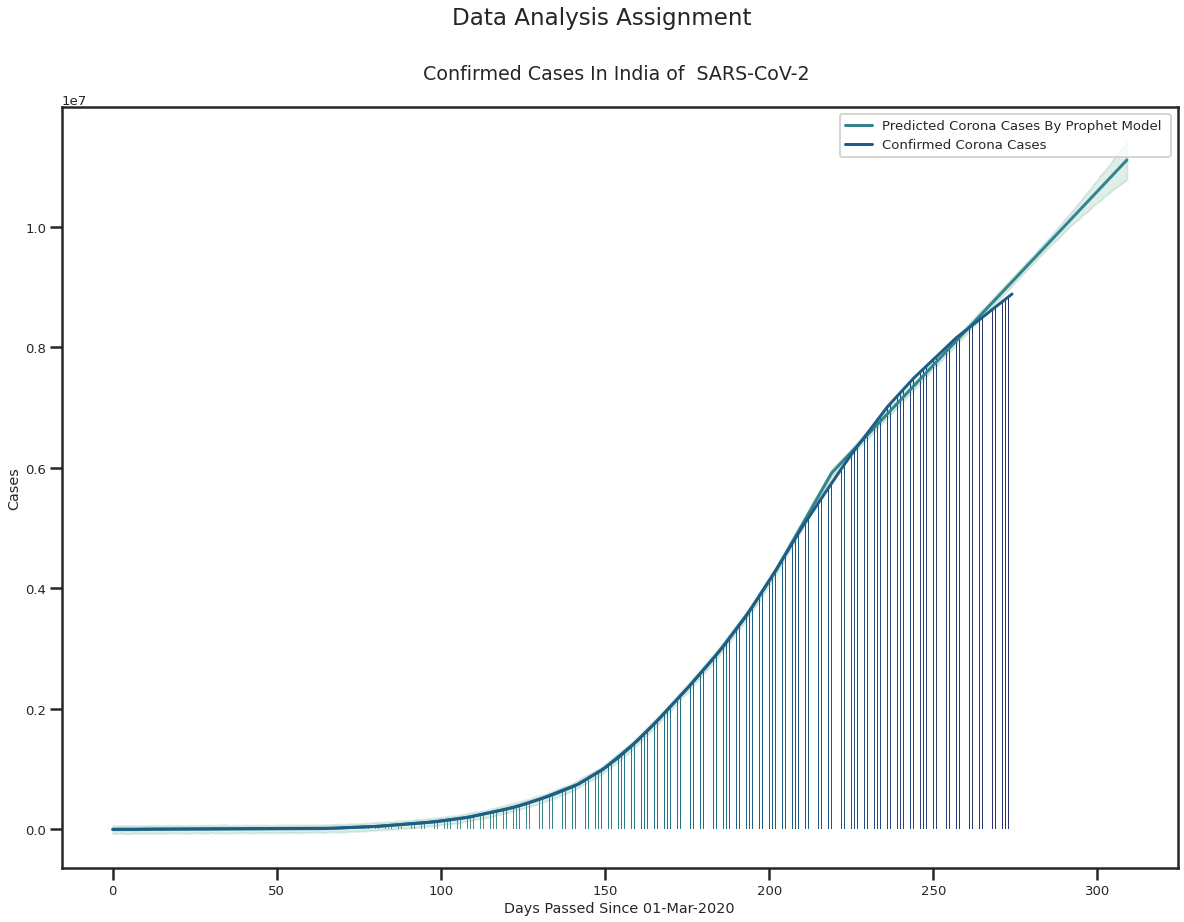

In [ ]:
#@markdown <h3>⬅️ Click Here to START Fitting</h3>
#@markdown <br><center><img src='https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.pngall.com%2Fwp-content%2Fuploads%2F2016%2F07%2FFacebook-Download-PNG.png&f=1&nofb=1' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2><br>Prophet Model for Forecasting</h2></center><br>

Plot_Column = "Recovered" #@param ['Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_','Tested_', 'Active_']
Location = "India" #@param ['Kerala', 'Delhi', 'Telangana', 'India', 'Rajasthan', 'Haryana','UP', 'Ladakh', 'TN', 'J&K', 'Karnataka', 'Maharashtra', 'Punjab','Andra P', 'HP', 'Uttarakhand', 'Odisha', 'Puducherry','West Bengal', 'Chandigarh', 'Chhattisgarh', 'Gujarat', 'MP','Bihar', 'Manipur', 'Goa', 'Mizoram', 'A&N', 'Assam', 'Jharkhand','Arun P', 'Nagaland', 'Tripura', 'D&D', 'Meghalaya', 'Sikkim','Other']
Predict_For = 35 #@param {type:"slider", min:0, max:100, step:1}


prophet_data = Completed_[Completed_.State == Location][['Date' , Plot_Column]]
prophet_data['Date'] = pd.to_datetime(prophet_data['Date'])
prophet_data.columns = ['ds','y']

m = Prophet()
m.fit(prophet_data)
future = m.make_future_dataframe(periods=Predict_For)
forecast = m.predict(future)
clear_output()
plot_color = list(sns.color_palette(Style_Color,n_colors=3).as_hex())
plt.figure(figsize=(Graphs_Width,Graphs_Height))

plt.bar(list(prophet_data.reset_index().index) , prophet_data['y'].values, width = 0.2 , linewidth = 0 , color = list(sns.color_palette(Style_Color,n_colors=prophet_data.shape[0]).as_hex()) )
plt.fill_between(list(forecast.index), forecast['yhat_lower'].values, forecast['yhat_upper'].values, color = plot_color[0] , alpha = 0.2 )
plt.plot(forecast['yhat'].values, label = 'Predicted Corona Cases By Prophet Model ' , color = plot_color[1] )
plt.plot(prophet_data['y'].values, label = 'Confirmed Corona Cases ' , color = plot_color[2] )

plt.suptitle('Data Analysis Assignment', fontsize = 23)
plt.title('Confirmed Cases In India of  SARS-CoV-2 \n', fontsize = 19)
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Days Passed Since 01-Mar-2020')
plt.subplots_adjust(top=SubPlot_Top)

# plt.savefig('/content/{} {}.{}'.format(Save_Name , time.time() , Format_To_Save) , bbox_inches = 'tight')


## Support Vector Regressor

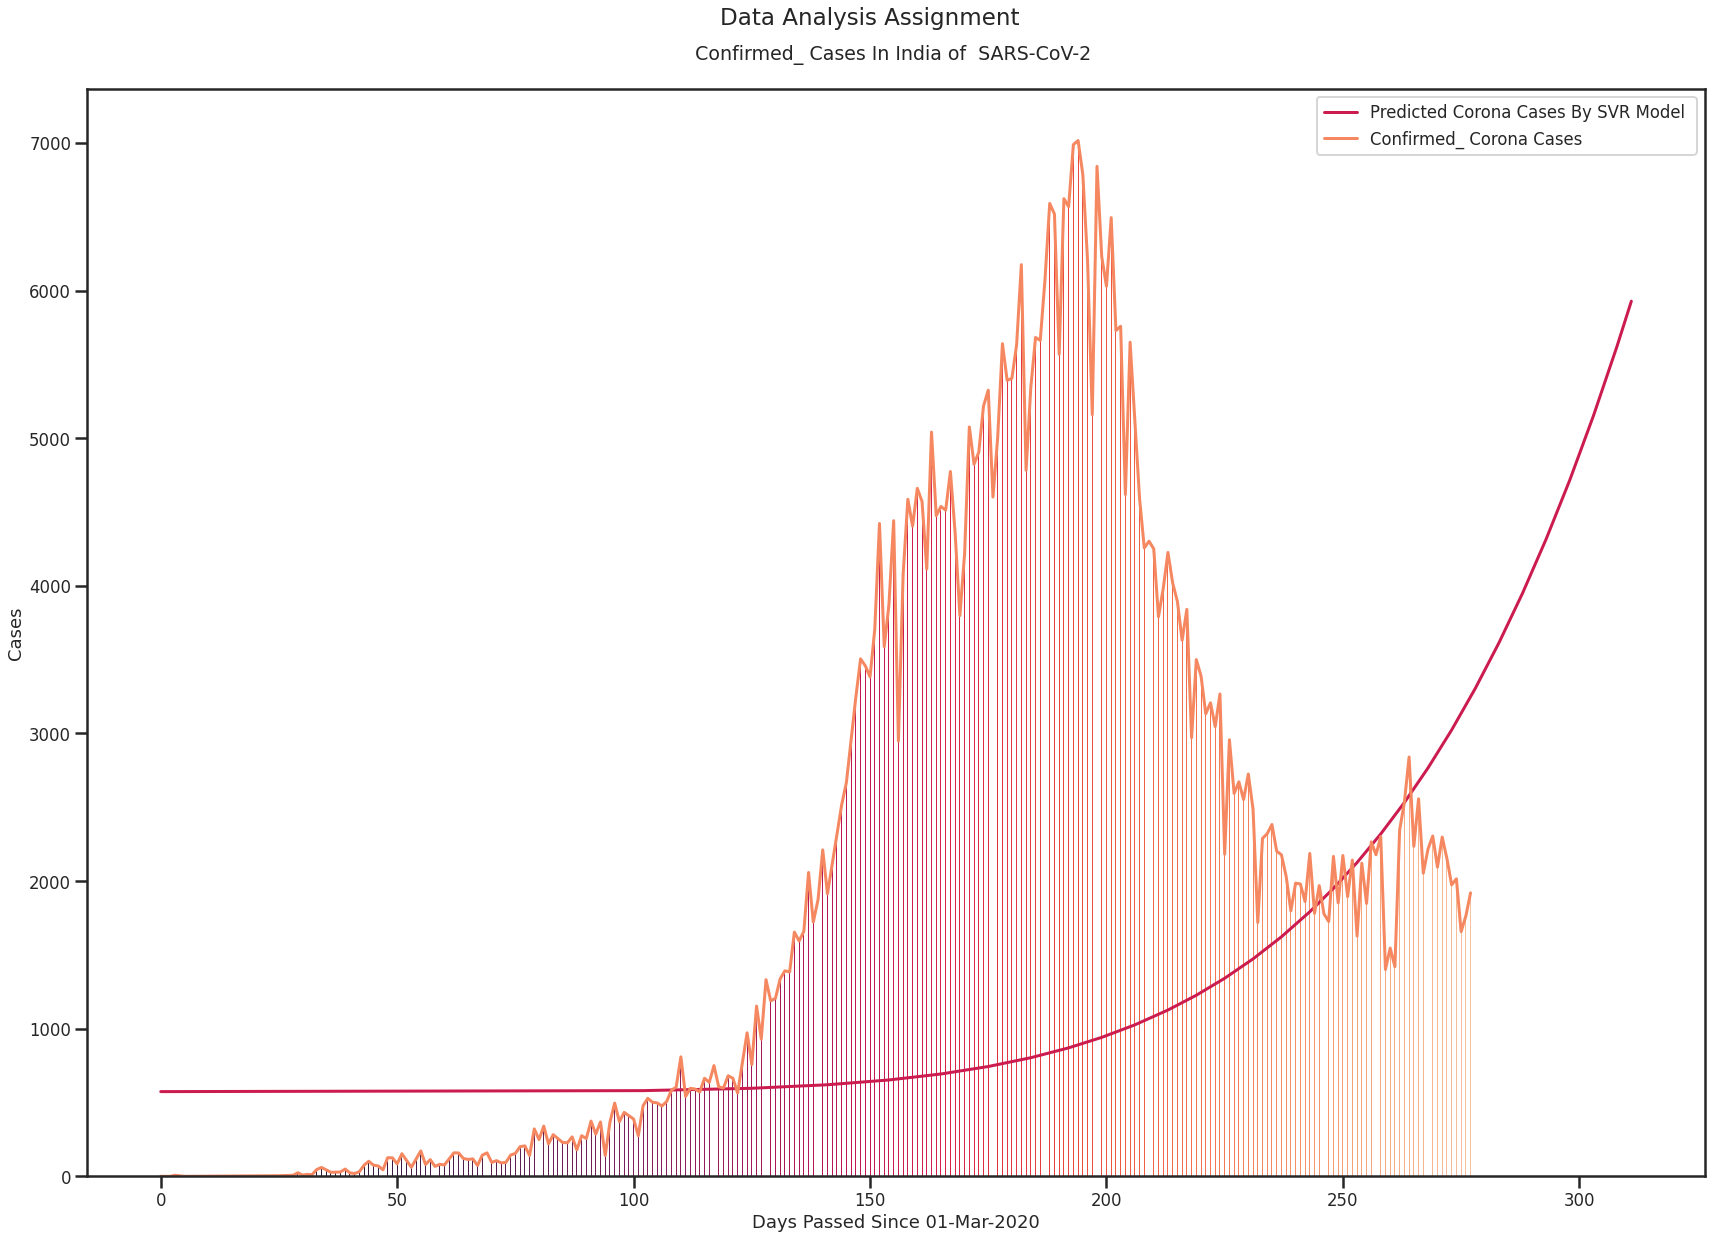

In [ ]:
#@markdown <h3>⬅️ Click Here to START Fitting</h3>
#@markdown <br><center><img src='https://svmwebsolutions.com/wp-content/uploads/2019/04/logo.png' height="200" alt="Gdrive-logo"/></center>
#@markdown <center><h2><br>SVM Model for Forecasting</h2></center><br>

Plot_Column = "Confirmed_" #@param ['Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested', 'Active', 'Confirmed_', 'Recovered_', 'Deceased_', 'Other_','Tested_', 'Active_']
Location = "UP" #@param ['Kerala', 'Delhi', 'Telangana', 'India', 'Rajasthan', 'Haryana','UP', 'Ladakh', 'TN', 'J&K', 'Karnataka', 'Maharashtra', 'Punjab','Andra P', 'HP', 'Uttarakhand', 'Odisha', 'Puducherry','West Bengal', 'Chandigarh', 'Chhattisgarh', 'Gujarat', 'MP','Bihar', 'Manipur', 'Goa', 'Mizoram', 'A&N', 'Assam', 'Jharkhand','Arun P', 'Nagaland', 'Tripura', 'D&D', 'Meghalaya', 'Sikkim','Other']
Kernel_SVM = "poly" #@param['poly','linear','rbf','sigmoid']
Predict_For = 35 #@param {type:"slider", min:0, max:100, step:1}
#@markdown <br><h4><i>* Note - SVR Show Poor Result Worst than expected</i></h4>

svm=SVR(C=1,degree=6,kernel=Kernel_SVM , epsilon=0.01)
# C -> Regularization Parameter
# Degree -> Degree of Polynomial Kernel to use (Ignored for Others)
# Kernel -> Kernel to use for Prediction

data = Completed_[Completed_['State'] == Location]
#Fitting model on the training data
svm.fit(data['Days_Passed'].values.reshape(-1,1) , data[Plot_Column].values.reshape(-1,1))
prediction_valid_svm=svm.predict(np.array(range(int(data['Days_Passed'].max()+Predict_For))).reshape(-1,1))

clear_output()
plot_color = list(sns.color_palette(Style_Color,n_colors=3).as_hex())
plt.figure(figsize=(Graphs_Width,Graphs_Height))

plt.bar(list(data['Days_Passed'].values) ,data[Plot_Column].values, width = 0.2 , linewidth = 0 , color = list(sns.color_palette(Style_Color,n_colors=len(prediction_valid_svm)).as_hex()) )
# plt.fill_between(list(forecast.index), forecast['yhat_lower'].values, forecast['yhat_upper'].values, color = plot_color[0] , alpha = 0.2 )
plt.plot(prediction_valid_svm, label = 'Predicted Corona Cases By SVR Model ' , color = plot_color[1] )
plt.plot(data[Plot_Column].values.reshape(-1,1), label = '{} Corona Cases '.format(Plot_Column) , color = plot_color[2] )

plt.suptitle('Data Analysis Assignment', fontsize = 23)
plt.title('{} Cases In India of  SARS-CoV-2 \n'.format(Plot_Column), fontsize = 19)
plt.legend()
plt.ylabel('Cases')
plt.xlabel('Days Passed Since 01-Mar-2020')
plt.subplots_adjust(top=SubPlot_Top)


# Unused Codes

In [ ]:

# Global cases
global_confirm_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
global_death_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
global_recover_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
# US cases
us_confirm_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
us_death_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
us_state_loc_csv = 'https://gist.githubusercontent.com/mbostock/9535021/raw/eaed7e5632735a6609f02d0ba0e55c031e14200d/us-state-capitals.csv'

Confirmed = pd.read_csv(global_confirm_csv)
Death = pd.read_csv(global_death_csv) 
Recovered = pd.read_csv(global_recover_csv)
Confirmed_us = pd.read_csv(us_confirm_csv)
Death_us = pd.read_csv(us_death_csv)
us_state_location = pd.read_csv(us_state_loc_csv)

Confirmed.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Death.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Recovered.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])

def join_national_data(confirmed, death, recovered):
    total_case = confirmed.join(death.set_index('date'), on='date').join(recovered.set_index('date'), on='date')
    total_case.reset_index(inplace=True, drop=True)
    return total_case



# function to extract the data of different cases in different country
def extract_national_data(df, country, case):
    df_extract = df[df['Country/Region'] == country].sum(axis=0)
    df_extract = df_extract.T.reset_index()
    df_extract = df_extract.iloc[1:]
    df_extract.columns = ['date', case]
    df_extract.date = pd.to_datetime(df_extract.date)
    return df_extract

us_confirmed = extract_national_data(Confirmed, 'US', 'positive')
us_death = extract_national_data(Death, 'US', 'death')
us_recovered = extract_national_data(Recovered, 'US', 'recovered')

us_status = join_national_data(us_confirmed, us_death, us_recovered)


in_confirmed = extract_national_data(Confirmed, 'India', 'positive')
in_death = extract_national_data(Death, 'India', 'death')
in_recovered = extract_national_data(Recovered, 'India', 'recovered')

in_status = join_national_data(us_confirmed, us_death, us_recovered)




In [ ]:
wget.download('https://github.com/datameet/covid19/blob/master/data/all_totals.json','/content/drive/MyDrive/COVID/All_totals_datameet.json')
wget.download('https://github.com/datameet/covid19/blob/master/data/mohfw.json', '/content/drive/MyDrive/COVID/mohfw_datameet.json')
wget.download('https://hub.mph.in.gov/dataset/89cfa2e3-3319-4d31-a60d-710f76856588/resource/8b8e6cd7-ede2-4c41-a9bd-4266df783145/download/covid_report_county.xlsx','/content/drive/MyDrive/COVID/covid_report_county.xlsx')
wget.download('https://hub.mph.in.gov/dataset/ab9d97ab-84e3-4c19-97f8-af045ee51882/resource/182b6742-edac-442d-8eeb-62f96b17773e/download/covid_report_date.xlsx' , '/content/drive/MyDrive/COVID/covid_report_date.xlsx')
wget.download('https://hub.mph.in.gov/dataset/6bcfb11c-6b9e-44b2-be7f-a2910d28949a/resource/7661f008-81b5-4ff2-8e46-f59ad5aad456/download/covid_report_death_date_agegrp.xlsx' , '/content/drive/MyDrive/COVID/covid_report_death_date_agegrp.xlsx')
wget.download('https://hub.mph.in.gov/dataset/62ddcb15-bbe8-477b-bb2e-175ee5af8629/resource/2538d7f1-391b-4733-90b3-9e95cd5f3ea6/download/covid_report_demographics.xlsx' , '/content/drive/MyDrive/COVID/covid_report_demographics.xlsx')
wget.download('https://covid.ourworldindata.org/data/owid-covid-data.csv','/content/drive/MyDrive/COVID/Covid_data.csv')
wget.download('https://covid.ourworldindata.org/data/ecdc/full_data.csv','/content/drive/MyDrive/COVID/Covid_full_data.csv')
wget.download('https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv' , '/content/drive/MyDrive/COVID/JHU_Confirmed.csv')
wget.download('https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv' , '/content/drive/MyDrive/COVID/JHU_Recovered.csv')
wget.download('https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv' , '/content/drive/MyDrive/COVID/JHU_Deaths.csv')
wget.download('https://api.covid19india.org/csv/latest/states.csv','/content/drive/MyDrive/COVID/India/states_.csv')
wget.download('https://api.covid19india.org/csv/latest/districts.csv','/content/drive/MyDrive/COVID/India/districts_.csv')
wget.download('https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson')
State_list = ["Assam", "Chandigarh","Karnataka" , "Manipur", "Meghalaya" "Meghalaya","Nagaland" ,"Punjab",
              "Rajasthan", "Sikkim" ,"Tripura" , "Uttarakhand" , "Telangana" , "Bihar" , "Kerala" , 
              "Madhya Pradesh" , "Andaman & Nicobar" , "Gujarat" , "Lakshadweep" , "Odisha" , 
              "Dadra and Nagar Haveli and Daman and Diu" , "Ladakh" , "Jammu & Kashmir" , "Chhattisgarh" , "Delhi" ,
              "Goa" , "Haryana" , "Himachal Pradesh" , "Jharkhand" , "Tamil Nadu" , "Uttar Pradesh" , "West Bengal" , 
              "Andhra Pradesh" , "Puducherry"  , "Maharashtra" , "Arunachal Pradesh" ]

'/content/drive/MyDrive/COVID/covid_report_demographics.xlsx'

In [ ]:
districts = pd.read_csv('/content/drive/MyDrive/COVID/India/districts_.csv')
states = pd.read_csv('/content/drive/MyDrive/COVID/India/states_.csv')
states = pd.concat([pd.DataFrame([['2020-03-01','Kerala',0,0,0,0,0]],columns = states.columns) , states] ,axis = 0)
states.sort_values(by = ['Date'])
states.fillna(0 , inplace = True)
districts.fillna(0 , inplace = True)
states['Active'] = states['Confirmed'] - (states['Recovered'] + states['Deceased'])
states['Month'] = states['Date'].apply(lambda x: x.split('-')[1])
states['Month'] = states['Month'].astype(int)
states = states[states['Month']>2]
date_unique = states.Date.unique()

# states['Day'] = states['Date'].apply(lambda x: x.split('-')[2])
# states['Day'] = states['Day'].astype(int)
# states= states.assign(Pre_1 = lambda x: x.Month *31+ x.Day)


In [ ]:
for datest in date_unique:
  state_cases = Completed_[Completed_.Date == datest]
  state_cases=state_cases.sort_values('Confirmed', ascending= False)
  total_cases = state_cases['Confirmed'].sum()
  # state_cases=state_cases.head(20)
  plt.figure(figsize=(25,22))
  ax = plt.subplot(1,1,1)
  plt.suptitle('Data Analysis Assignment', fontsize = 29)
  plt.title('\nTop States with SARS-CoV-2 Cases ( March to November )\n' , fontsize = 23)
  graph = sns.barplot(data=state_cases,y='State',x='Confirmed',color=sns.color_palette('Set3')[4],label='Confirmed' , orient = 'h')
  sns.barplot(data=state_cases,y='State',x='Recovered',color=sns.color_palette('Set3')[5],label='Cured' , orient = 'h')
  # sns.barplot(data=state_cases,y='State',x='Active',color=sns.color_palette('viridis')[3],label='Active', ci = 'sd')
  sns.barplot(data=state_cases,y='State',x='Deceased',color=sns.color_palette('Set3')[3],label='Deaths', orient = 'h')
  # plt.xticks(rotation=90)
  plt.ylabel('States')
  plt.xlabel('Number of Cases')
  # plt.xlim(0,Completed_['Confirmed'].max()+Completed_['Confirmed'].max()/10 )
  plt.xlim(0,state_cases['Confirmed'].max()+state_cases['Confirmed'].max()/10 )
  plt.legend(loc = 8)
  anchored_text = AnchoredText("Month : {}\nDays Passed : {}\nTotal Confirmed Cases : {}".format(state_cases.Month.unique()[0] ,  state_cases.Days_Passed.unique()[0],int(total_cases)), borderpad=1.0, pad = 1.0, loc=7 , frameon= True )
  ax.add_artist(anchored_text)
  # plt.text(0.95, 0.01, 'colored text in axes coords',
  #         verticalalignment='bottom', horizontalalignment='right',
  #         color='green', fontsize=15)
  for p in graph.patches[:20]:
    _x = p.get_x() + p.get_width() 
    _y = p.get_y() + p.get_height()/2 + float(0.2)
    value = ((int(p.get_width())/total_cases)*100)
    if np.isnan(value):
      value = 0.0
    graph.text(_x , _y , ' {:.2f}%'.format(value) , ha = 'left', color = sns.color_palette('rocket')[1])
  plt.savefig('Figures/box_plot_states_large_{}.jpg'.format(datest) , bbox_inches = 'tight')

In [ ]:
def make_video():
  fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
  # dim = (int(1721/3),int(1421/3))
  dim = (1721,1421)
  out = cv2.VideoWriter('/content/drive/MyDrive/COVID/States_war_slow_.avi' , fourcc , 10 , dim)
  for i in date_unique:
    img_path = 'Figures/box_plot_states_large_{}.jpg'.format(i)
    frame = cv2.imread(img_path)
    frame = cv2.resize(frame , dsize = dim)
    out.write(frame)
  out.release()
make_video()

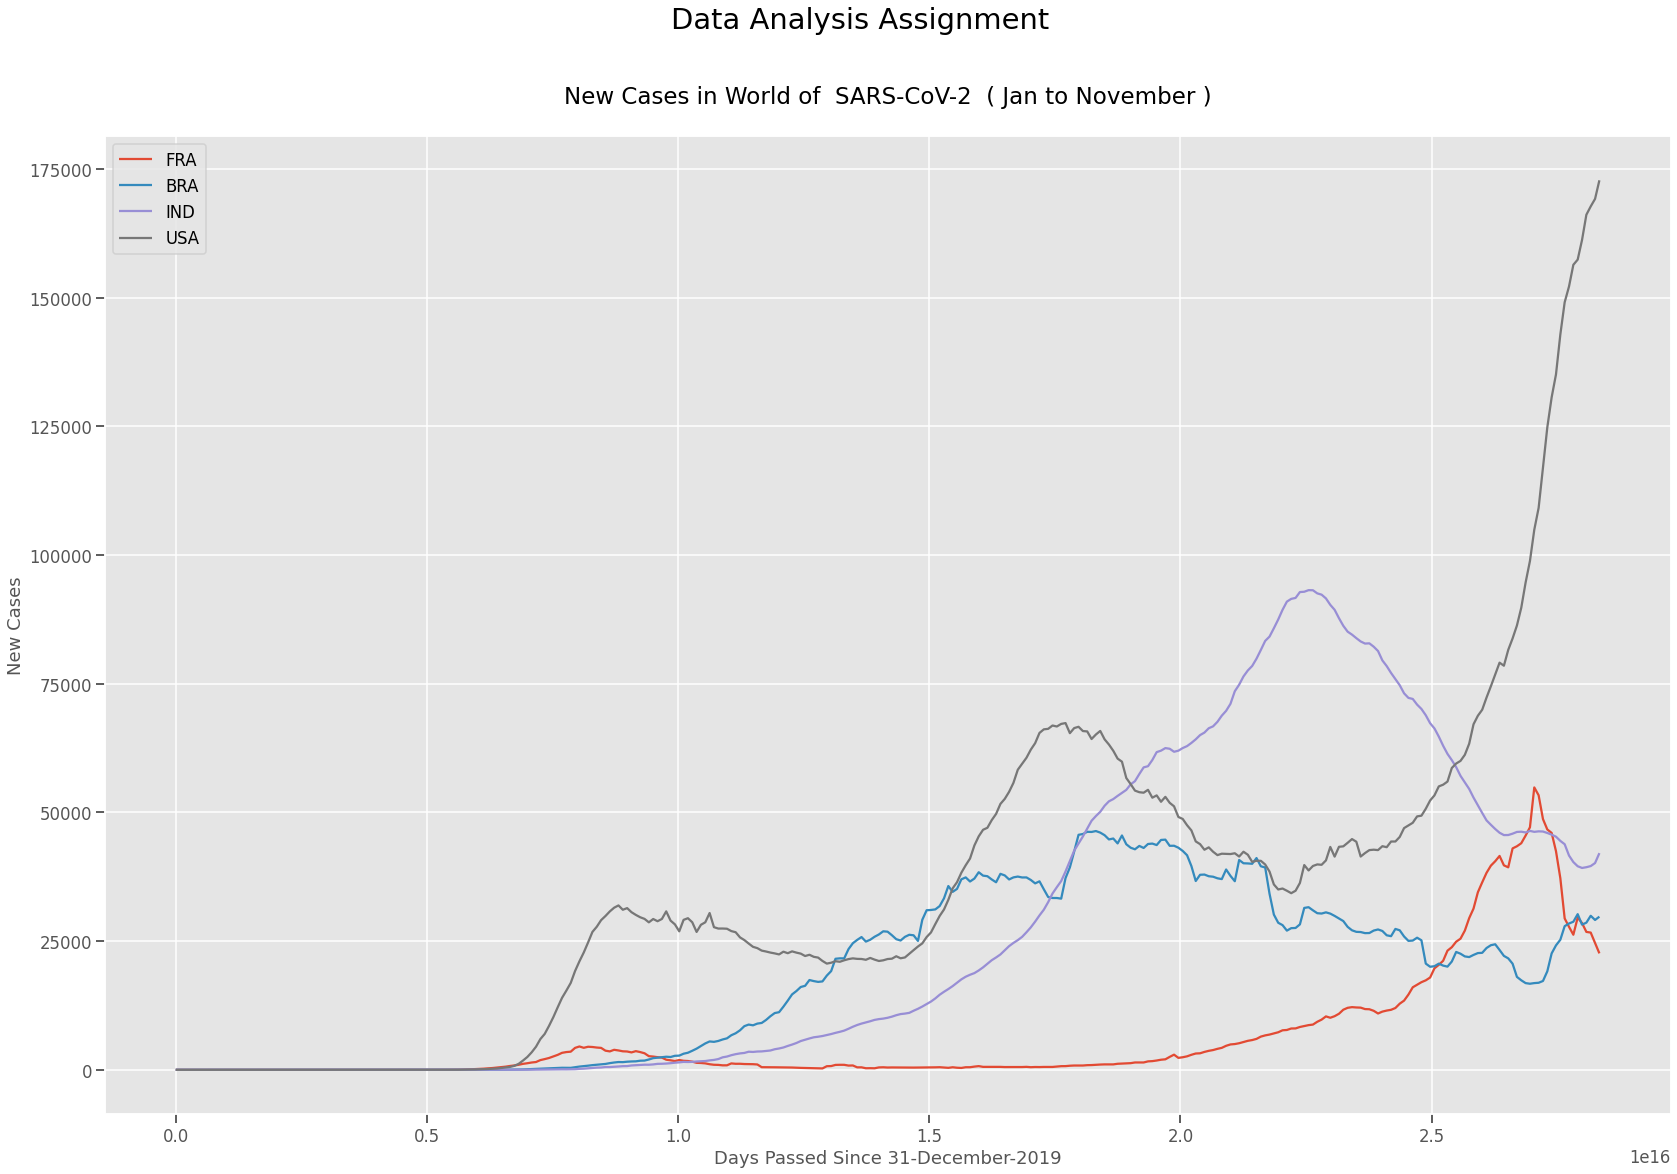

In [ ]:
colors = sns.color_palette("rocket")
plt.figure(figsize=(25,18))

# for iso in ['CHL', 'BEL', 'UKR', 'ZAF', 'IRN', 'POL', 'DEU', 'PER', 'MEX', 'COL', 'ARG', 'ITA', 'GBR', 'ESP', 'RUS', 'FRA', 'BRA', 'IND', 'USA']:
# for iso in ['ITA', 'GBR', 'ESP', 'RUS', 'FRA', 'BRA', 'IND', 'USA']:
for iso in ['FRA', 'BRA', 'IND', 'USA']:
  plt.plot(World_[World_['iso_code'] == iso]['Days_Passed'].values , World_[World_['iso_code'] == iso]['new_cases_smoothed'].values , label = iso )
plt.suptitle('Data Analysis Assignment', fontsize = 29)
plt.title('\nNew Cases in World of  SARS-CoV-2  ( Jan to November )\n' , fontsize = 23)
plt.legend()
plt.ylabel('New Cases')
plt.xlabel('Days Passed Since 31-December-2019')
plt.savefig('/content/drive/MyDrive/COVID/India/World New Cases 3.jpg' , bbox_inches = 'tight')

plt.show()

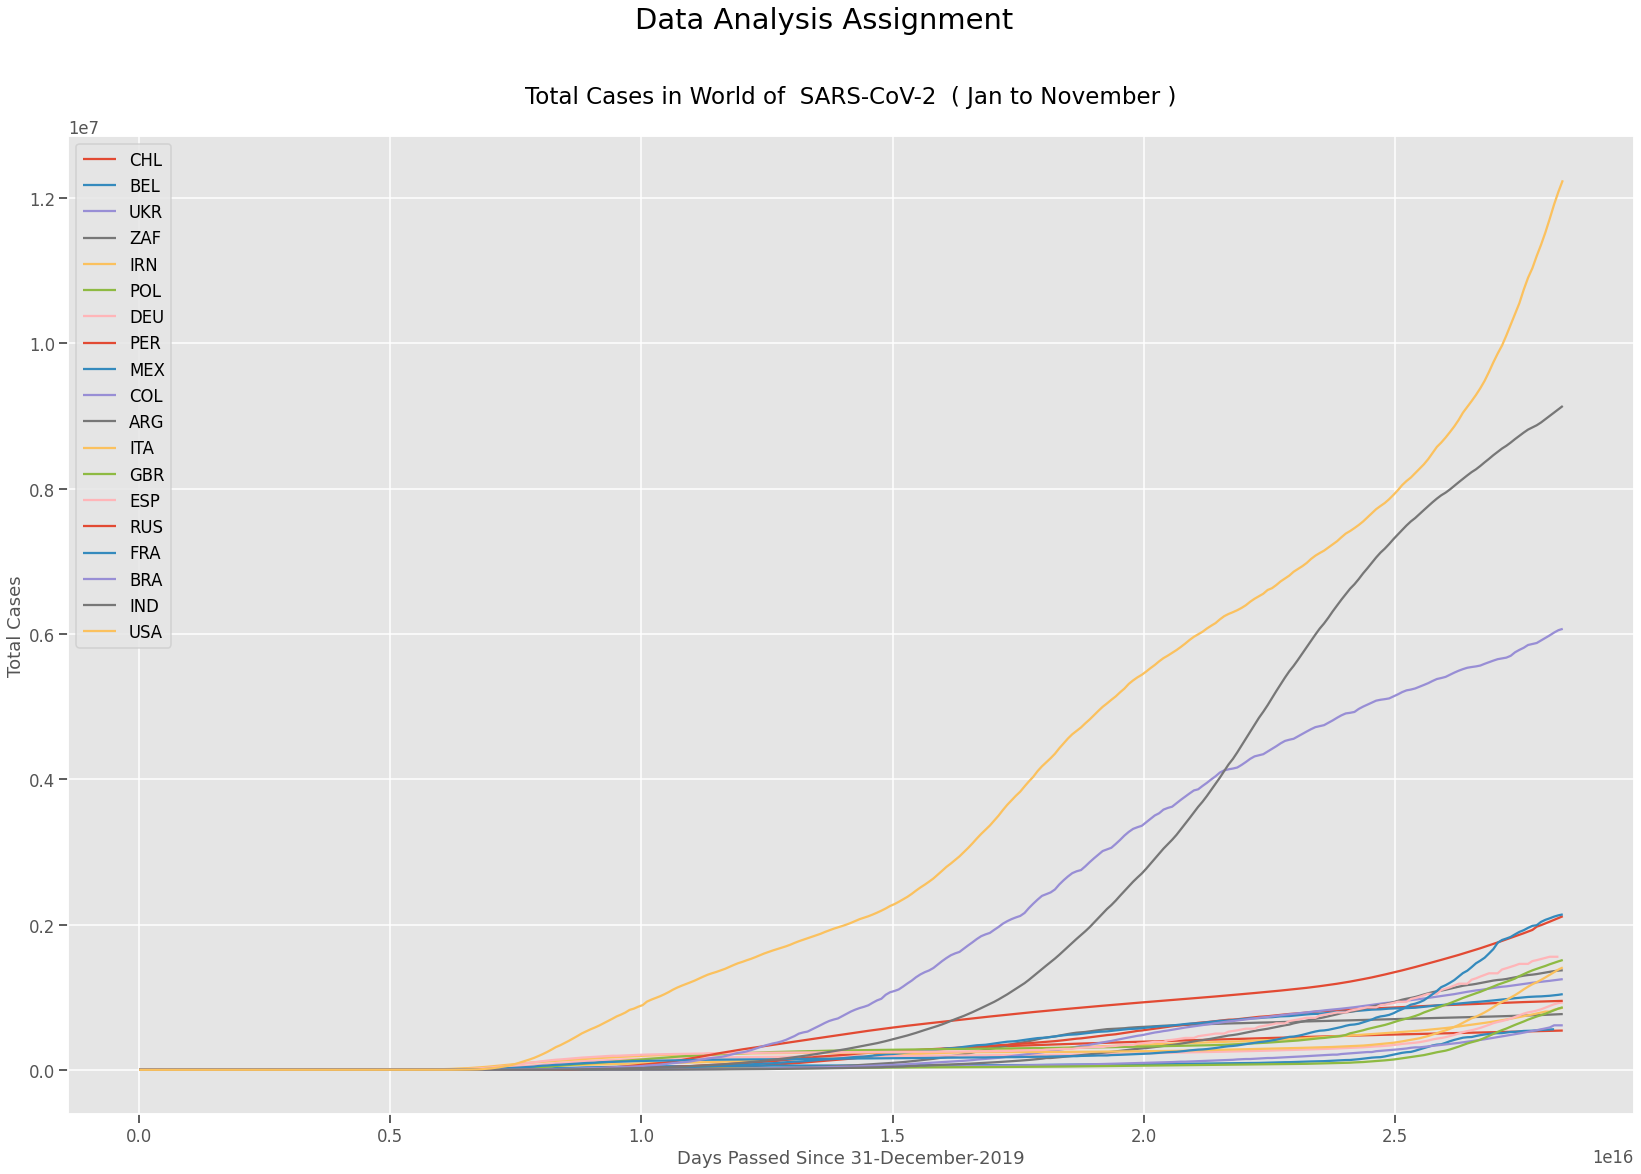

In [ ]:
colors = sns.color_palette("rocket")
plt.figure(figsize=(25,18))

for iso in ['CHL', 'BEL', 'UKR', 'ZAF', 'IRN', 'POL', 'DEU', 'PER', 'MEX', 'COL', 'ARG', 'ITA', 'GBR', 'ESP', 'RUS', 'FRA', 'BRA', 'IND', 'USA']:
# for iso in ['ITA', 'GBR', 'ESP', 'RUS', 'FRA', 'BRA', 'IND', 'USA']:
# for iso in ['FRA', 'BRA', 'IND', 'USA']:
  plt.plot(World_[World_['iso_code'] == iso]['Days_Passed'].values , World_[World_['iso_code'] == iso]['total_cases'].values , label = iso )
plt.suptitle('Data Analysis Assignment', fontsize = 29)
plt.title('\nTotal Cases in World of  SARS-CoV-2  ( Jan to November )\n' , fontsize = 23)
plt.legend()
plt.ylabel('Total Cases')
plt.xlabel('Days Passed Since 31-December-2019')
plt.savefig('/content/drive/MyDrive/COVID/India/World Total Cases 1.jpg' , bbox_inches = 'tight')

plt.show()